# EARLY SAMPLES (<= 10 PCW) - CM007, CM009, CM011, CM020 

In [1]:
import scipy.spatial
import scipy.sparse
import anndata
import pandas as pd
import scanpy as sc
import annoy
import numpy as np

In [2]:
def prepare_scaled(adata, min_genes=0):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    #normalise to median
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)

In [3]:
def knn(iss, gex, gex_only, 
        obs_to_take=None, 
        round_counts=True, 
        computation="annoy", 
        neighbours=15
       ):
    #identify the KNN, preparing a (distances, indices) tuple
    if computation == "annoy":
        #build the GEX index
        ckd = annoy.AnnoyIndex(gex.X.shape[1], metric="euclidean")
        for i in np.arange(gex.X.shape[0]):
            ckd.add_item(i,gex.X[i,:])
        ckd.build(10)
        #query the GEX index with the ISS data
        ckdo_ind = []
        ckdo_dist = []
        for i in np.arange(iss.X.shape[0]):
            holder = ckd.get_nns_by_vector(iss.X[i,:], neighbours, include_distances=True)
            ckdo_ind.append(holder[0])
            ckdo_dist.append(holder[1])
        ckdout = (np.asarray(ckdo_dist),np.asarray(ckdo_ind))
    elif computation == "cKDTree":
        #build the GEX index
        ckd = scipy.spatial.cKDTree(gex.X)
        #query the GEX index with the ISS data
        ckdout = ckd.query(x=iss.X, k=neighbours, workers=-1)
    else:
        raise ValueError("Invalid computation, must be 'annoy' or 'cKDTree'")
    #turn KNN output into a scanpy-like graph
    #the indices need to be flattened, the default row-major style works
    indices = ckdout[1].flatten()
    #the indptr is once every neighbours, but needs an extra entry at the end
    indptr = neighbours * np.arange(iss.shape[0]+1)
    #the data is ones. for now. use float32 as that's what scanpy likes as default
    data = np.ones(iss.shape[0]*neighbours, dtype=np.float32)
    #construct the KNN graph!
    #need to specify the shape as there may be cells at the end that don't get picked up
    #and this will throw the dimensions off when doing matrix operations shortly
    pbs = scipy.sparse.csr_matrix((data, indices, indptr), shape=[iss.shape[0], gex.shape[0]])
    #get the annotations and fractions of the specified obs columns in the KNN
    #start the obs pool with what already resides in the ISS object
    pbs_obs = iss.obs.copy()
    if obs_to_take is not None:
        #just in case a single is passed as a string
        if type(obs_to_take) is not list:
            obs_to_take = [obs_to_take]
        #now we can iterate over this nicely
        #using the logic of milopy's annotate_nhoods()
        for anno_col in obs_to_take:
            anno_dummies = pd.get_dummies(gex.obs[anno_col])
            anno_count = pbs.dot(anno_dummies.values)
            #apparently an np.array falls out from the above
            #which then in turn needs [:,None] here for the division to work properly
            anno_frac = np.array(anno_count / anno_count.sum(1)[:,None])
            anno_frac = pd.DataFrame(
                anno_frac,
                index=iss.obs_names,
                columns=anno_dummies.columns,
            )
            pbs_obs[anno_col] = anno_frac.idxmax(1)
            pbs_obs[anno_col + "_fraction"] = anno_frac.max(1)
    #the expression is a mean rather than a sum, make the data to add up to one per row
    pbs.data = (pbs.data / neighbours)
    X = pbs.dot(gex_only.X)
    #round the data to nearest integer if instructed
    if round_counts:
        X.data = np.round(X.data)
        X.eliminate_zeros()
    #now we can build the object easily
    out = anndata.AnnData(X, var=gex_only.var, obs=pbs_obs)
    return out

In [4]:
def patch(iss, gex, 
          min_genes=0, 
          obs_to_take=None, 
          round_counts=True, 
          computation="annoy", 
          neighbours=15
         ):
    """
    Identify the nearest neighbours of low dimensionality observations 
    in related higher dimensionality data. Approximate features absent  
    from the low dimensionality data as high dimensionality neighbour 
    means. The data is log-normalised and z-scored prior to KNN 
    inference.
    
    Input
    -----
    iss : ``AnnData``
        The low dimensionality data object, with raw counts in ``.X``.
    gex : ``AnnData``
        The high dimensionality data object, with raw counts in ``.X``.
    min_genes : ``int``, optional (default: 3)
        Passed to ``scanpy.pp.filter_cells()`` ran on the shared feature 
        space of ``iss`` and ``gex``.
    obs_to_take : ``str`` or list of ``str``, optional (default: ``None``)
        If provided, will report the most common value of the specified 
        ``gex.obs`` column(s) for the neighbours of each ``iss`` cell.
    round_counts : ``bool``, optional (default: ``True``)
        If ``True``, will round the computed counts to the nearest 
        integer.
    computation : ``str``, optional (default: ``"annoy"``)
        The package supports KNN inference via annoy (specify 
        ``"annoy"``) and scipy's cKDTree (specify ``"cKDTree"). Annoy 
        identifies approximate neighbours and runs quicker, cKDTree 
        identifies exact neighbours and is a bit slower.
    neighbours : ``int``, optional (default: 15)
        How many neighbours in ``gex`` to identify for each ``iss`` cell.
    """
    #copy the objects to avoid modifying the originals
    iss = iss.copy()
    gex = gex.copy()
    #subset the ISS to genes that appear in the GEX
    iss = iss[:, [i in gex.var_names for i in iss.var_names]]
    #separate GEX into shared gene space and not shared gene space
    #gex_only = gex[:, [i not in iss.var_names for i in gex.var_names]]
    gex_only = gex.copy()
    gex = gex[:, iss.var_names]
    #turn both objects for KNNing into a log-normalised, z-scored form
    prepare_scaled(iss, min_genes=0)
    prepare_scaled(gex, min_genes=0)
    #this might remove some cells from the GEX, mirror in the gex_only
    gex_only = gex_only[gex.obs_names]
    #identify the KNN and use it to approximate expression
    return knn(iss=iss, 
               gex=gex, 
               gex_only=gex_only, 
               obs_to_take=obs_to_take,
               round_counts=round_counts,
               computation=computation,
               neighbours=neighbours
              )

In [5]:
adata_sc = sc.read('/nfs/team292/vl6/FetalReproductiveTract/early_labeltransfer.h5ad')
CM007 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM007_annotated.h5ad')
CM007.obs_names = ['CM007_' + i for i in CM007.obs_names]
CM009 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM009_annotated.h5ad')
CM009.obs_names = ['CM009_' + i for i in CM009.obs_names]
CM011 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM011_annotated.h5ad')
CM011.obs_names = ['CM011_' + i for i in CM011.obs_names]
CM020 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM020_annotated.h5ad')
CM020.obs_names = ['CM020_' + i for i in CM020.obs_names]
adata_sc.shape, CM007.shape, CM009.shape, CM011.shape, CM020.shape

((149880, 28956), (8391, 171), (56627, 171), (28470, 171), (54756, 171))

In [6]:
adata_sp = CM007.concatenate([CM009, CM011, CM020],
            join='outer',index_unique=None, fill_value=0, uns_merge='unique')

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) co

In [7]:
adata_sp.shape # differences between HOX code and original panel

(148244, 175)

In [8]:
adata_sp.obs.head()

sample  total_counts  n_genes_by_counts leiden broad_anatomy  \
CM007_1  CM007          81.0                  9      3         Gonad   
CM007_2  CM007          78.0                 20      3         Gonad   
CM007_3  CM007          61.0                  9      1         Gonad   
CM007_4  CM007          74.0                 18      1         Gonad   
CM007_5  CM007          42.0                  9      1         Gonad   

         broad_anatomy_number  L2_dist_broad_anatomy_Ducts  \
CM007_1                    10                          NaN   
CM007_2                    10                          NaN   
CM007_3                    10                          NaN   
CM007_4                    10                          NaN   
CM007_5                    10                          NaN   

         L2_dist_broad_anatomy_Adrenal  L2_dist_broad_anatomy_Gonad  \
CM007_1                            NaN                          NaN   
CM007_2                            NaN                          NaN   
CM007_3                            NaN                          NaN   
CM007_4                            NaN                          NaN   
CM007_5                            NaN                          NaN   

         L2_dist_broad_anatomy_Nephros  L2_dist_broad_anatomy_UrogenitalSinus  \
CM007_1                            NaN                                    NaN   
CM007_2                            NaN                                    NaN   
CM007_3                            NaN                                    NaN   
CM007_4                            NaN                                    NaN   
CM007_5                            NaN                                    NaN   

         L2_dist_broad_anatomy_Genital Tubercle  \
CM007_1                                     NaN   
CM007_2                                     NaN   
CM007_3                                     NaN   
CM007_4                                     NaN   
CM007_5                                     NaN   

         L2_dist_broad_anatomy_LabioScrotal Swelling  \
CM007_1                                          NaN   
CM007_2                                          NaN   
CM007_3                                          NaN   
CM007_4                                          NaN   
CM007_5                                          NaN   

         L2_dist_broad_anatomy_Urogenital Sinus batch  
CM007_1                                     NaN     0  
CM007_2                                     NaN     0  
CM007_3                                     NaN     0  
CM007_4                                     NaN     0  
CM007_5                                     NaN     0

## Remove gonads because they are not in the reference

In [9]:
adata_sp.obs['broad_anatomy'].value_counts(dropna = False)

Ducts                    36411
Genital Tubercle         25964
Adrenal                  20957
Gonad                    15998
Urogenital Sinus         14780
LabioScrotal Swelling    12150
Nephros                  11983
UrogenitalSinus           7250
Unassigned                2383
Background                 368
Name: broad_anatomy, dtype: int64

In [10]:
adata_sp = adata_sp[[i not in ['Gonad', 'Background', 'Unassigned'] for i in adata_sp.obs['broad_anatomy']]]
adata_sp.shape

(129495, 175)

In [11]:
adata_sc.obs['celltype'].value_counts()

Wolffian/Mesonephros Mese      28263
Urogenital Sinus Lig           13817
Lower Urogenital Sinus Mese    10932
Corpus Cavernosum              10035
Upper Urogenital Sinus Mese     8656
Corpus Spongiosum               6462
Coelomic Epi                    6282
Neural                          5785
Müllerian Mese                  4996
Uterus Mese                     4258
Glans                           4238
Kidney - Mese Progenitor        3975
Labio-Scrotal Swelling          3899
Vas Deferens Mese               3563
Wolffian Epi                    3232
Müllerian Epi                   2556
Prepuce                         2536
Endothelial                     2325
Fallopian Mese                  2178
Schwann                         2106
Kidney - Ureteric Bud           2098
Fallopian Lig                   2026
Perivascular                    1999
Wolffian/Mesonephros Lig        1907
Urogenital Sinus Epi            1828
Kidney - Podocyte               1585
Adrenal Cortex                  1451
K

In [12]:
adata_sc = adata_sc[[i not in ['Fallopian Mese', 'Fallopian Lig',
                               'Uterus Mese', 
                             'Vas Deferens Mese' , #'UrethralPlate', 'Preputial_Lamina',
                              ] for i in adata_sc.obs['celltype']]]

In [13]:
# Remove cell types that have less than 1000 cells in the scRNA-seq dataset as representation might be incorrect
cell_type_counts = adata_sc.obs['celltype'].value_counts()
valid_cell_types = cell_type_counts[cell_type_counts >= 1000].index.to_list()
adata_sc = adata_sc[[i in valid_cell_types for i in adata_sc.obs['celltype']]]

In [14]:
adata_sc.obs['celltype'].value_counts()

Wolffian/Mesonephros Mese      28263
Urogenital Sinus Lig           13817
Lower Urogenital Sinus Mese    10932
Corpus Cavernosum              10035
Upper Urogenital Sinus Mese     8656
Corpus Spongiosum               6462
Coelomic Epi                    6282
Neural                          5785
Müllerian Mese                  4996
Glans                           4238
Kidney - Mese Progenitor        3975
Labio-Scrotal Swelling          3899
Wolffian Epi                    3232
Müllerian Epi                   2556
Prepuce                         2536
Endothelial                     2325
Schwann                         2106
Kidney - Ureteric Bud           2098
Perivascular                    1999
Wolffian/Mesonephros Lig        1907
Urogenital Sinus Epi            1828
Kidney - Podocyte               1585
Adrenal Cortex                  1451
Kidney - Loop of Henle          1097
Kidney - S-Shaped Body          1065
Preputial Lamina Epi            1006
Name: celltype, dtype: int64

In [15]:
# Random downsampling per cell type 
import random
from itertools import chain
def downsample(adata, labels, n): 
    
    myindex = adata.obs[labels].value_counts().index 
    myvalues = adata.obs[labels].value_counts().values
    clusters = pd.Series(myvalues, index = myindex)
    
    # Find clusters with > n cells 
    cl2downsample = clusters.index[ clusters.values > n ]

    # save all barcode ids from small clusters
    holder = []
    holder.append( adata.obs_names[[ i not in cl2downsample for i in adata.obs[labels] ]] ) 

    # randomly sample n cells in the cl2downsample
    for cl in cl2downsample:
        print(cl)
        cl_sample = adata[[ i == cl for i in adata.obs[labels]]].obs_names
    
        cl_downsample = random.sample(set(cl_sample), n )
        holder.append(cl_downsample)
    
    # samples to include
    samples = list(chain(*holder))

    # Filter adata_count
    adata = adata[[ i in samples for i in adata.obs_names ]]
    return adata

In [16]:
#adata_sc = downsample(adata_sc, 'celltype', 3000)

In [17]:
#adata_sc.obs['celltype'].value_counts()

In [18]:
len(set(adata_sp.var_names).intersection(adata_sc.var_names))


174

In [19]:
set(adata_sp.var_names)- set(adata_sc.var_names)

{'TCN1'}

In [20]:
out = patch(iss=adata_sp, gex=adata_sc, obs_to_take="celltype")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [21]:
out.obsm = adata_sp.obsm

In [22]:
import squidpy as sq

<AxesSubplot: >

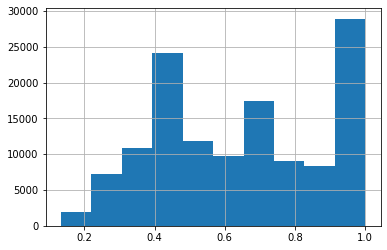

In [23]:
out.obs['celltype_fraction'].hist()

In [29]:
out.obs[['celltype', 'celltype_fraction']].to_csv('/nfs/team292/vl6/FetalReproductiveTract/ISS/pre10pcw_ISS_deconvolution.csv')

In [30]:
np.min(out.X)

0.0

## Visualise ISS dotplot for reviewers

<ipython-input-24-da1575d442cf>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sp.obs['celltype'] = out.obs['celltype']


<AxesSubplot: >

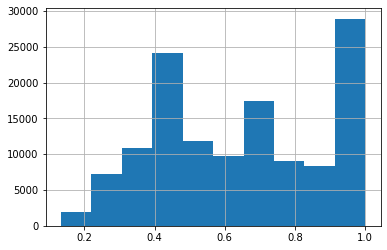

In [24]:
adata_sp.obs['celltype'] = out.obs['celltype']
adata_sp.obs['celltype_fraction'] = out.obs['celltype_fraction']
adata_sp.obs['celltype_fraction'].hist()

In [25]:
adata_sp.var_names[100:150]

Index(['MSX2', 'MUC5B', 'MYH11', 'NKD1', 'NOTUM', 'NPHS1', 'NPHS2', 'OMD',
       'OVGP1', 'P2RX1', 'PART1', 'PAX8', 'PDGFRA', 'PDZK1IP1', 'PGF', 'PGR',
       'PKHD1L1', 'PLAC1', 'PLP1', 'PLVAP', 'PRAC1', 'PRDM8', 'PTGER3',
       'PTPRC', 'PTPRZ1', 'RERGL', 'RGS5', 'RORB', 'RUNX1', 'RUNX2', 'RXRG',
       'SCN7A', 'SEMA3D', 'SEPTIN4', 'SHISA3', 'SIX1', 'SLC12A1', 'SLC14A1',
       'SLC1A1', 'SLC34A1', 'SNX1', 'SNX31', 'SOX17', 'SOX9', 'SP7', 'SPAG11B',
       'SPDEF', 'SPINK1', 'SPINK2', 'SRD5A2'],
      dtype='object')

In [26]:
adata_sp.obs['celltype'].value_counts()

Wolffian/Mesonephros Mese      27086
Urogenital Sinus Lig           24540
Upper Urogenital Sinus Mese    11485
Lower Urogenital Sinus Mese    11070
Corpus Cavernosum               7695
Neural                          6440
Müllerian Mese                  5561
Wolffian/Mesonephros Lig        3596
Wolffian Epi                    3260
Endothelial                     3018
Coelomic Epi                    2878
Kidney - Podocyte               2536
Corpus Spongiosum               2442
Labio-Scrotal Swelling          2423
Glans                           2406
Prepuce                         2302
Kidney - Mese Progenitor        2278
Perivascular                    1387
Müllerian Epi                   1251
Schwann                         1162
Kidney - Ureteric Bud            966
Adrenal Cortex                   904
Preputial Lamina Epi             802
Kidney - S-Shaped Body           792
Urogenital Sinus Epi             640
Kidney - Loop of Henle           575
Name: celltype, dtype: int64

In [27]:
adata_sp = adata_sp[[i >= 0.8 for i in adata_sp.obs['celltype_fraction']]]

In [28]:
adata_sp.obs['celltype'].value_counts()

Wolffian/Mesonephros Mese      14088
Urogenital Sinus Lig            4925
Neural                          4476
Lower Urogenital Sinus Mese     3616
Wolffian Epi                    2518
Kidney - Podocyte               2376
Upper Urogenital Sinus Mese     2230
Endothelial                     2033
Coelomic Epi                    1907
Corpus Cavernosum               1903
Müllerian Mese                   853
Müllerian Epi                    670
Kidney - Ureteric Bud            646
Preputial Lamina Epi             640
Glans                            582
Schwann                          516
Urogenital Sinus Epi             437
Prepuce                          372
Perivascular                     280
Kidney - Loop of Henle           272
Labio-Scrotal Swelling           263
Kidney - S-Shaped Body           248
Wolffian/Mesonephros Lig         151
Adrenal Cortex                   135
Corpus Spongiosum                 80
Kidney - Mese Progenitor          55
Name: celltype, dtype: int64

In [29]:
adata_sp = adata_sp[[i in ['Coelomic Epi', 'Müllerian Epi', 'Müllerian Mese','Wolffian Epi',
    'Wolffian/Mesonephros Mese', 'Wolffian/Mesonephros Lig', 
    'Urogenital Sinus Epi','Upper Urogenital Sinus Mese',
    'Lower Urogenital Sinus Mese','Urogenital Sinus Lig',
     'Preputial Lamina Epi',  'Glans',
     'Corpus Cavernosum',
       'Corpus Spongiosum', 
       'Prepuce',
       'Labio-Scrotal Swelling', 
        'Kidney - Loop of Henle', 'Kidney - Ureteric Bud', 'Kidney - S-Shaped Body', 
    'Kidney - Podocyte', 
     'Adrenal Cortex', 
     'Perivascular',  'Endothelial',  'Schwann', 'Neural',] for i in adata_sp.obs['celltype']]]

In [30]:
adata_sp.shape

(46217, 175)

In [31]:
np.max(adata_sp.X)

ArrayView(88., dtype=float32)

In [32]:
sc.pp.normalize_total(adata_sp)
sc.pp.log1p(adata_sp)
sc.pp.scale(adata_sp, max_value=10)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
np.max(adata_sp.X)

10.0

In [34]:
adata_sp.obs['celltype'] = adata_sp.obs['celltype'].astype('category')
adata_sp.obs['celltype'] = adata_sp.obs['celltype'].cat.reorder_categories(
    ['Coelomic Epi', 'Müllerian Epi', 'Müllerian Mese','Wolffian Epi',
    'Wolffian/Mesonephros Mese', 'Wolffian/Mesonephros Lig', 
    'Urogenital Sinus Epi','Upper Urogenital Sinus Mese',
    'Lower Urogenital Sinus Mese','Urogenital Sinus Lig',
     'Preputial Lamina Epi',  'Glans',
     'Corpus Cavernosum',
       'Corpus Spongiosum', 
       'Prepuce',
       'Labio-Scrotal Swelling', 
        'Kidney - Loop of Henle', 'Kidney - Ureteric Bud', 'Kidney - S-Shaped Body', 
    'Kidney - Podocyte', 
     'Adrenal Cortex', 
     'Perivascular',  'Endothelial',  'Schwann', 'Neural'])


In [35]:
# adata_sp = adata_sp[[i not in ['Perivascular', 'Erythroid'] for i in adata_sp.obs['celltype']]]

In [40]:
markers = ['EMX2', 'PAX8', 'LHX1', 'WNT4', 'WNT5A',
           'LRRN4', 'WNT7A', 'CPXM2', 'AMHR2',
           'WNT9B', 'GATA3', 'PLAC1', 'ADH1B', 
         'FOXA1','CPA6', 'GAP43', 'FOXF1', 'PRDM8',
           'KRT5', 'TP63',  'CRLF1', 'DLX5', 'FOXF2','AR', 'IRX2',
          'DEFB1','SLC12A1', 'DPYS', 'GLYAT', 'NPHS1', 'SHISA3', 
            'RGS5', 'CDH5', 'PLVAP', 'MPZ', 'PLP1', 'STMN2'
          ]

In [41]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                         frameon=True, vector_friendly=True, fontsize=14, figsize=[7,7], color_map=None, 
                         format='pdf', facecolor=None, transparent=False,)

In [42]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


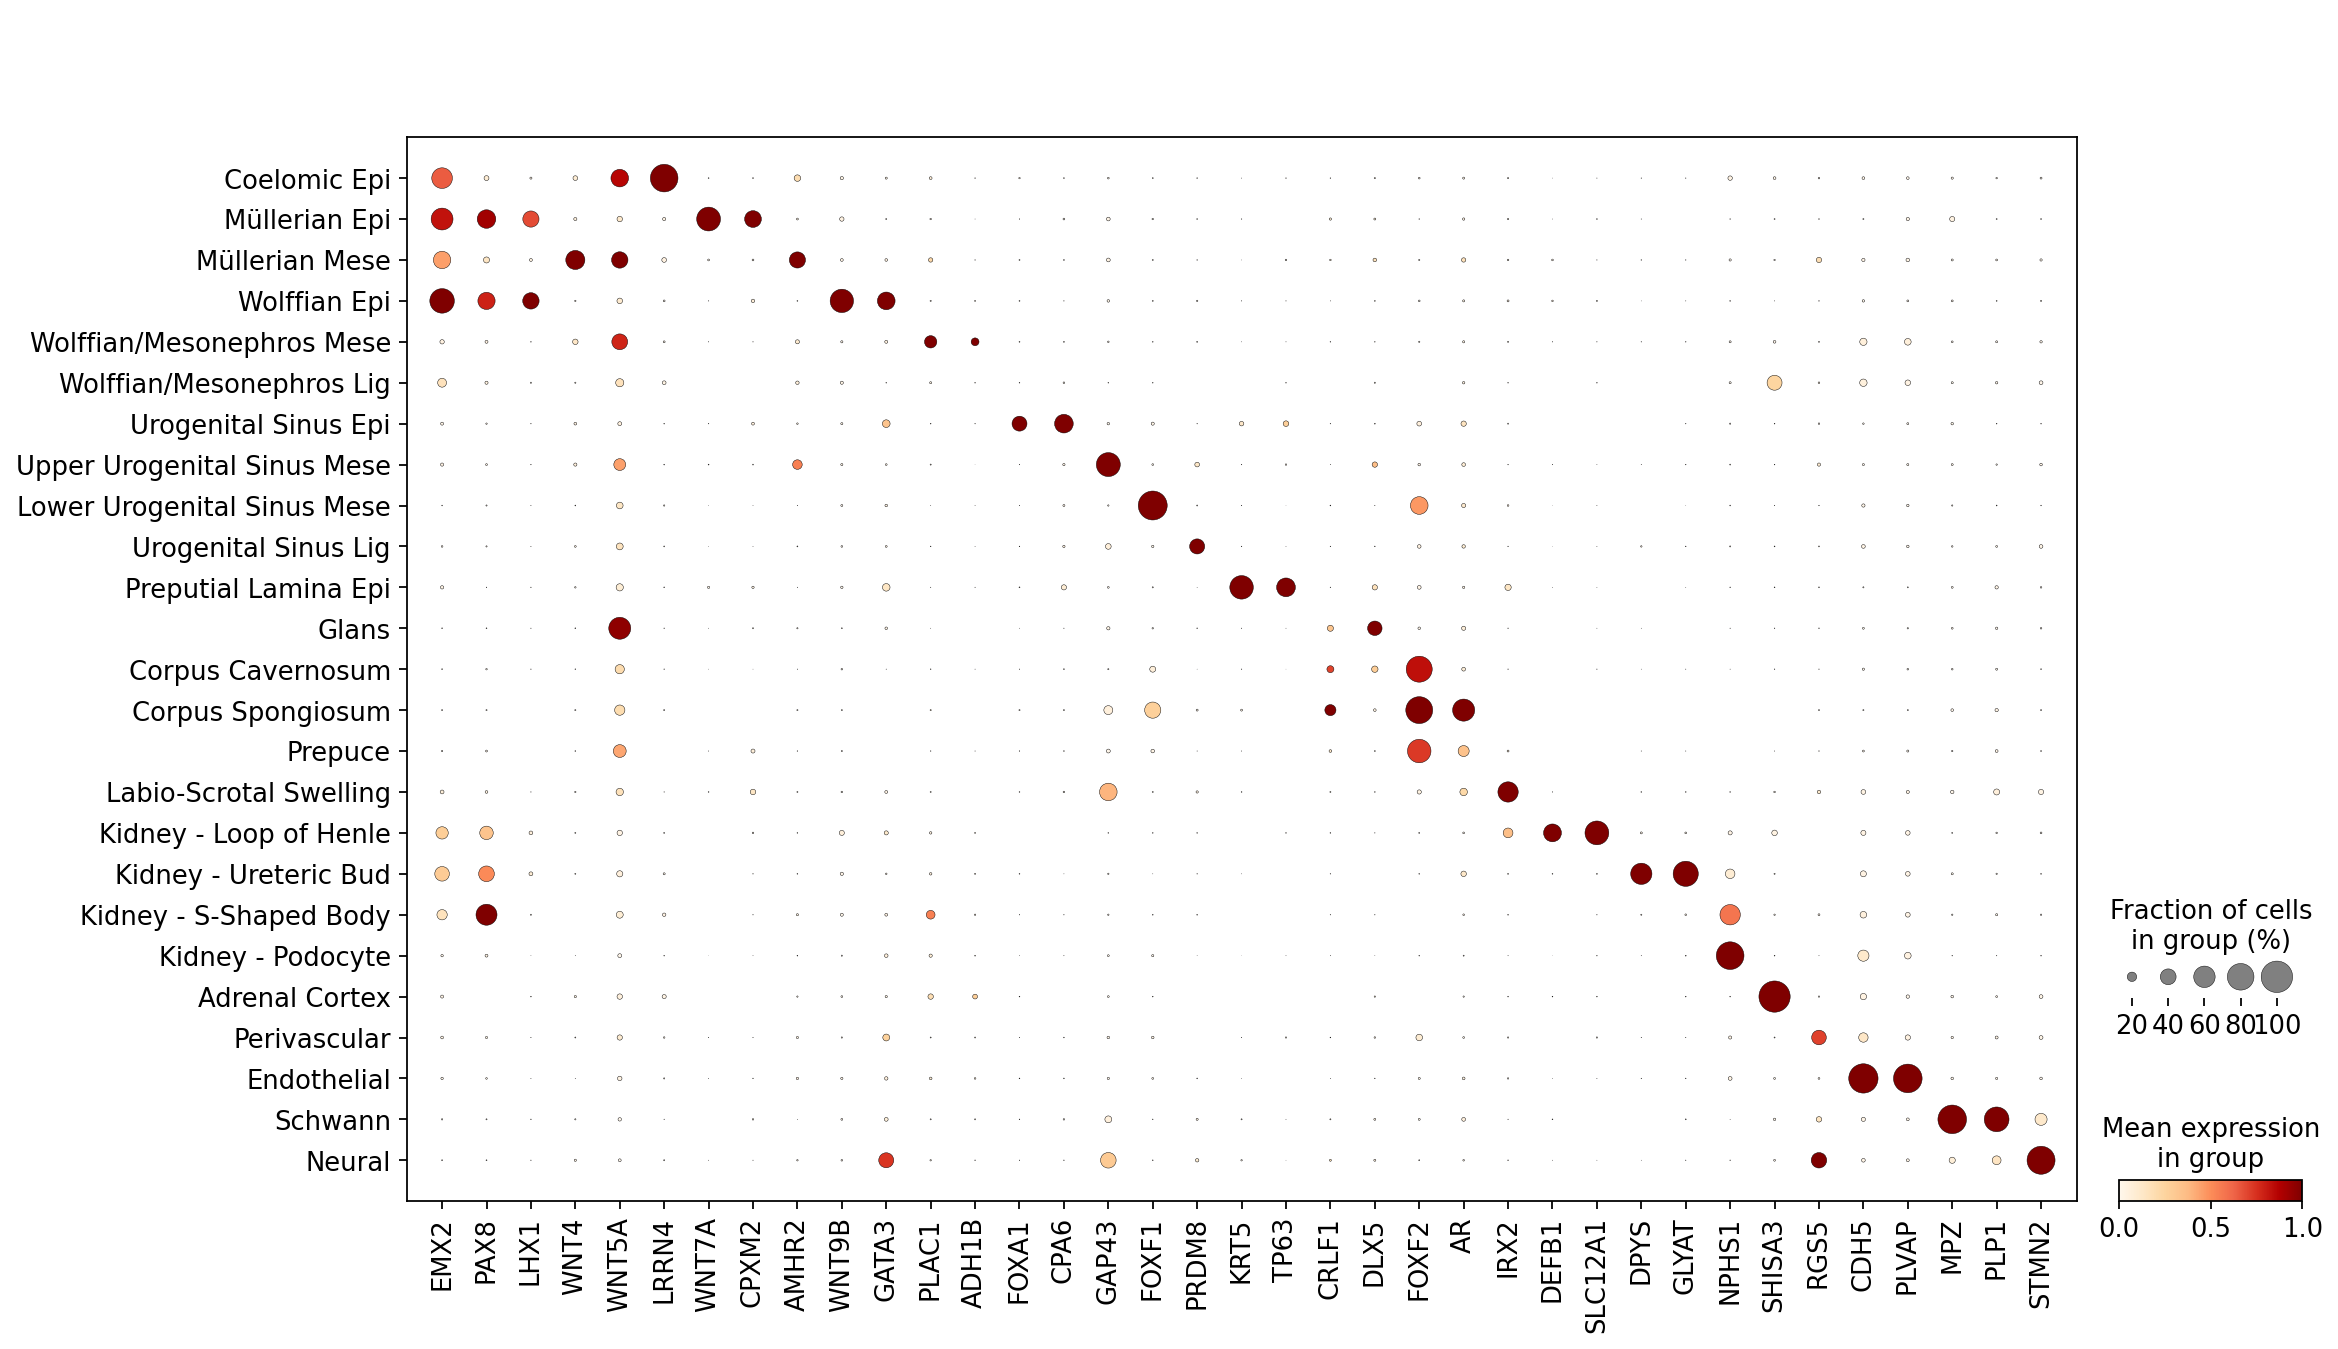

In [43]:
sc.pl.dotplot(adata_sp, var_names = markers, 
              groupby = 'celltype', standard_scale = 'var', color_map = 'OrRd', 
             save = 'iss_specificity_markers_dotplot_<10pcw')

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_4034580/1643353112.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)
/tmp/ipykernel_4034580/1643353112.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


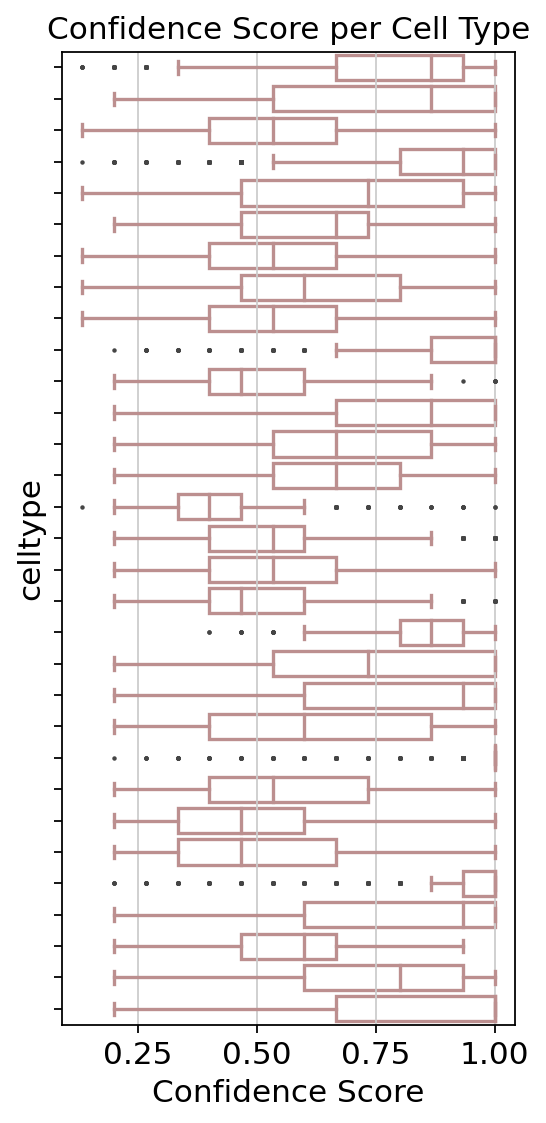

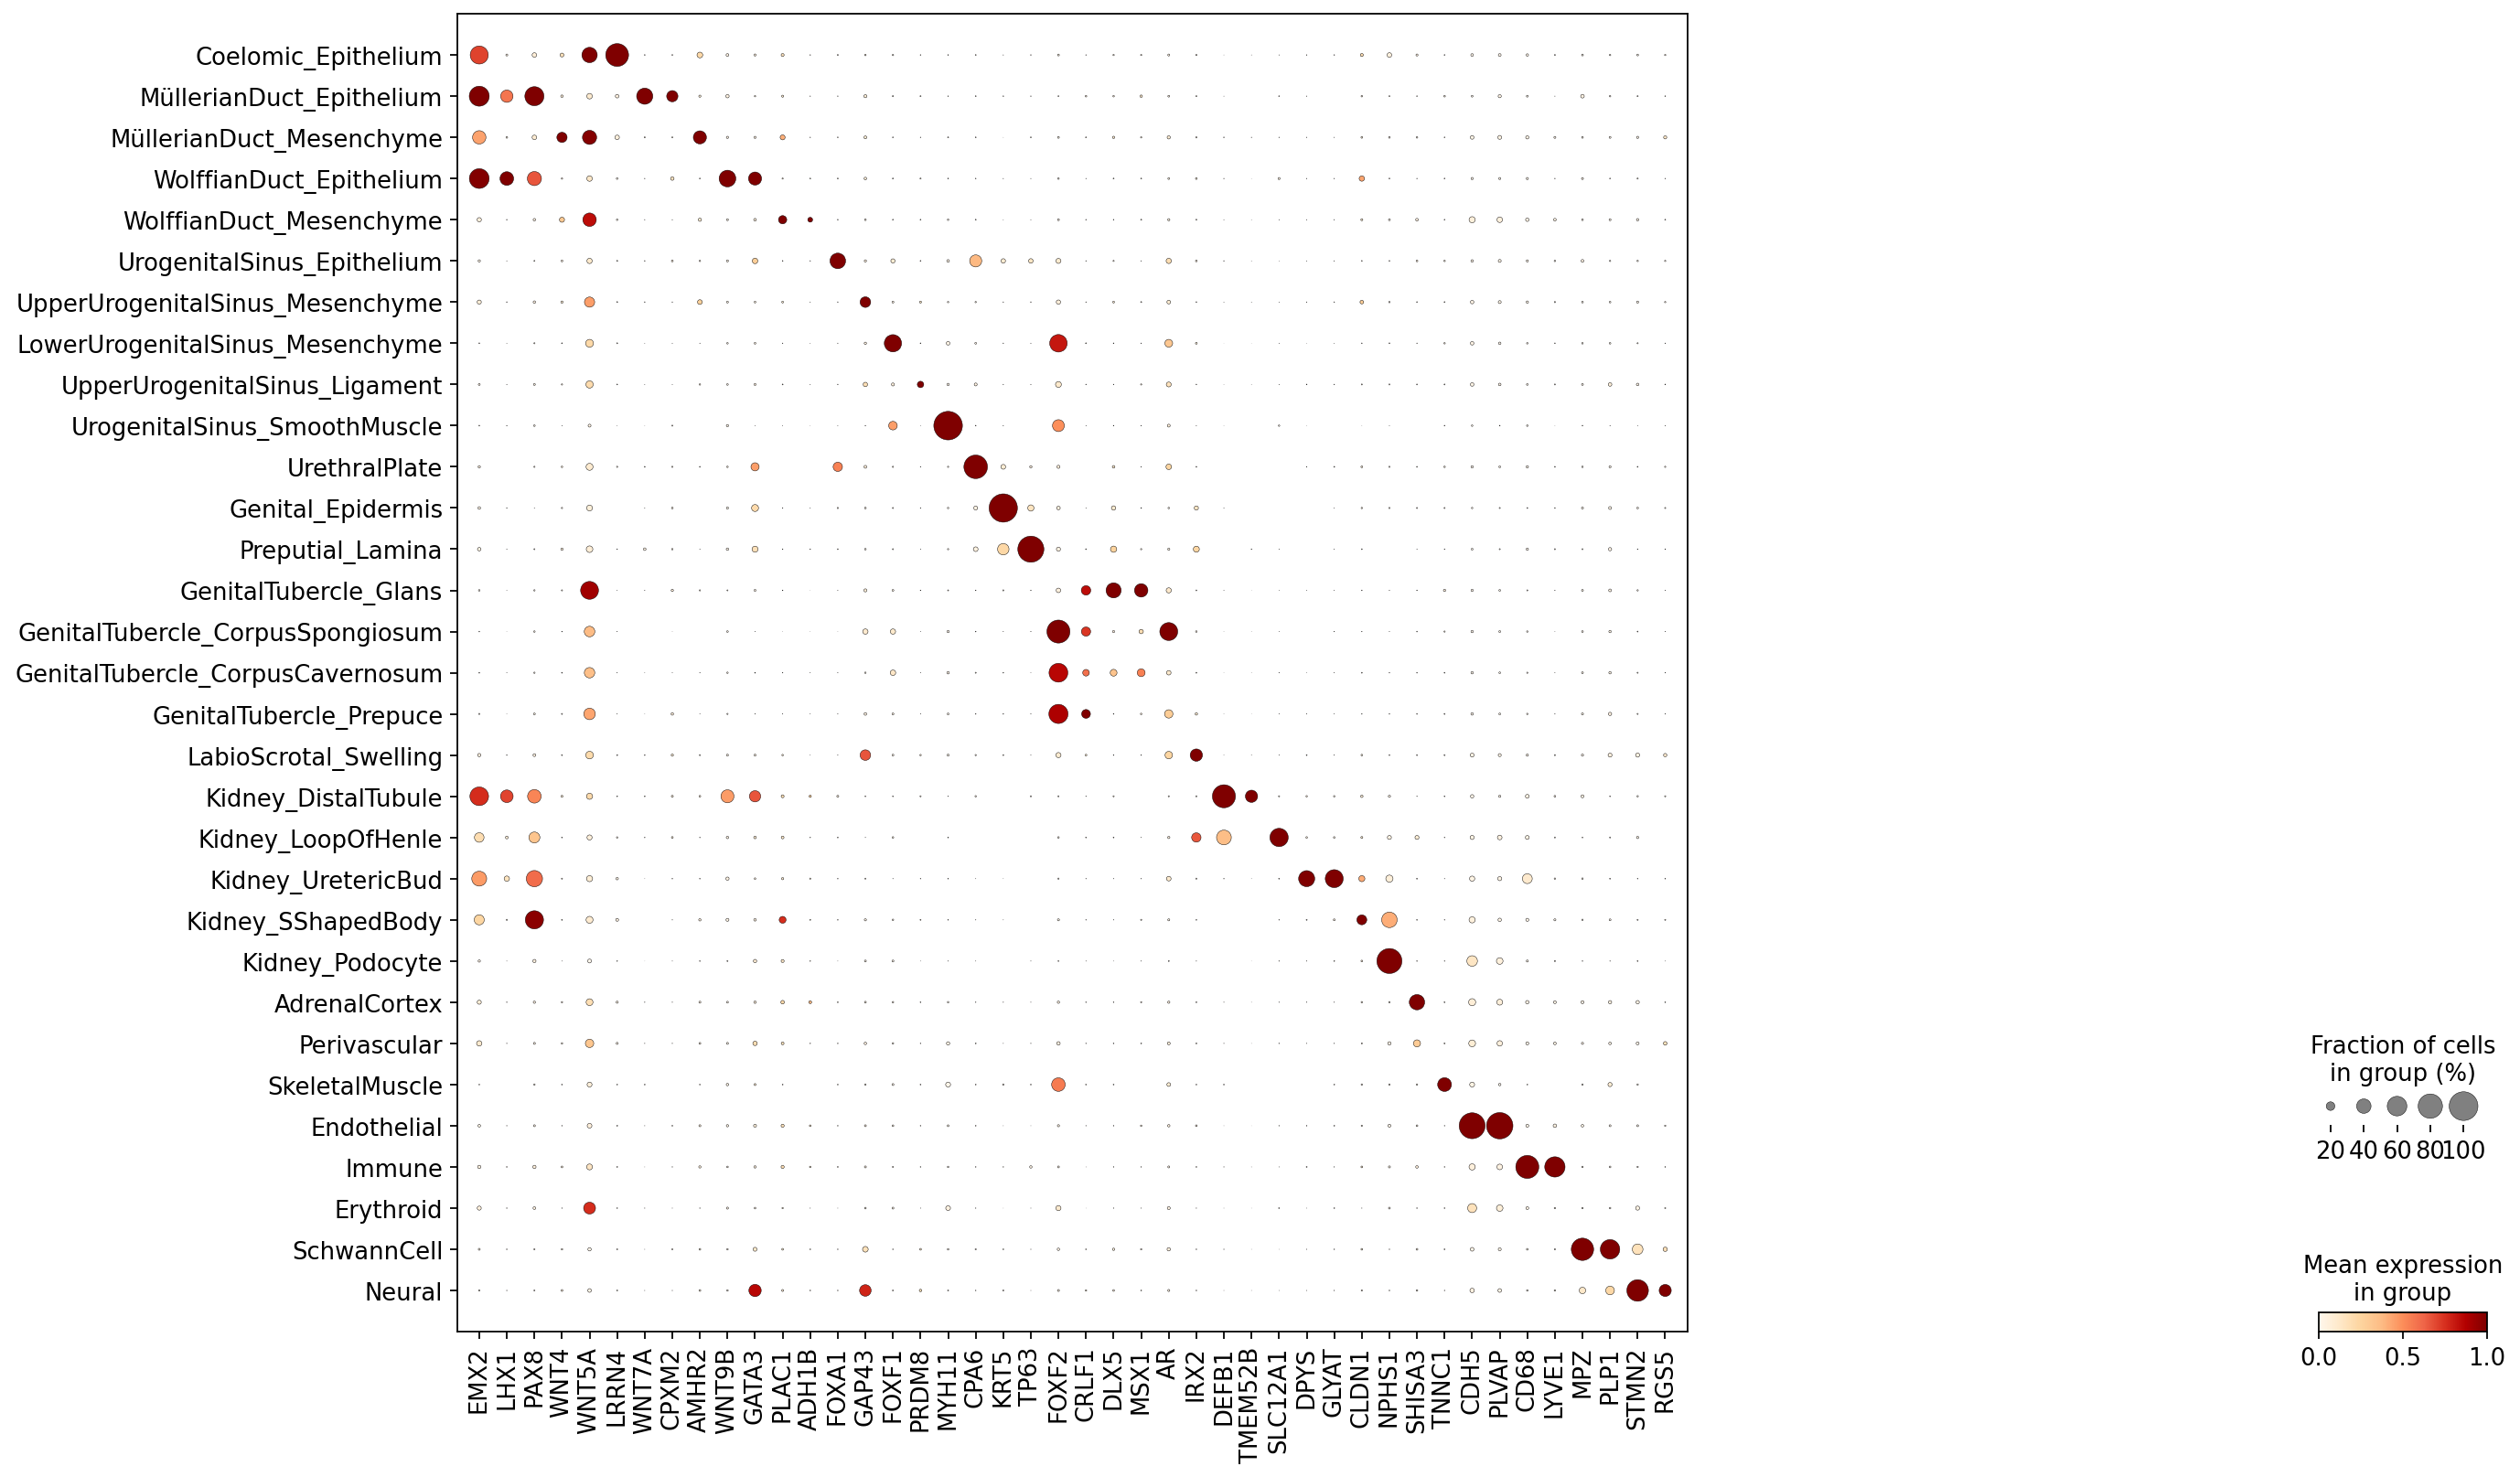

In [56]:
# Dotplot for gene expression
dotplot = sc.pl.dotplot(adata_sp, var_names = markers, 
              groupby = 'celltype', standard_scale = 'var', color_map = 'OrRd', return_fig=True)
# Extract the cell types from the dotplot for ordering
cell_types = adata_sp.obs['celltype'].unique()

# Create a new figure for the combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

# Plot the dotplot on the first axis
dotplot.get_axes()['mainplot_ax'].figure = fig
dotplot.get_axes()['mainplot_ax'].set_position(ax1.get_position())
ax1.remove()  # Remove placeholder axis
fig.axes.append(dotplot.get_axes()['mainplot_ax'])

# Now we will create the boxplot on the y-axis corresponding to cell types
confidence_data = adata_sp.obs[['celltype', 'celltype_fraction']]  # Assuming 'confidence_score' is in obs

# To align the boxplot vertically, we need to sort by cell_type
confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)

# Customizations for empty boxplot with grey contours and smaller outliers
boxprops = {'facecolor': 'none', 'edgecolor': 'rosybrown'}  # Empty box with grey edge
whiskerprops = {'color': 'rosybrown'}
capprops = {'color': 'rosybrown'}
medianprops = {'color': 'rosybrown'}
flierprops = {'marker': 'o', 'color': 'grey', 'markersize': 1}  # Smaller grey outliers

# Plot the boxplot with horizontal orientation to match the y-axis
sns.boxplot(y='celltype', x='celltype_fraction', data=confidence_data, ax=ax2, orient='h',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
            medianprops=medianprops, flierprops=flierprops)

# Adjust the title and layout
ax2.set_title('Confidence Score per Cell Type')
ax2.set_xlabel('Confidence Score')

# Make sure both plots align properly
plt.tight_layout()
# Save the figure as a PDF
plt.savefig("iss_dotplot_boxplot<10pcw.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [ ]:
# Create a new figure for the combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

# Create a dotplot for gene expression, with cell types on the y-axis and draw it on the specified axis
sc.pl.dotplot(adata_sp, var_names = markers, 
              groupby = 'celltype', standard_scale = 'var', color_map = 'OrRd', ax=ax1, show=False)

# Now we will create the boxplot on the y-axis corresponding to cell types
confidence_data = adata_sp.obs[['celltype', 'celltype_fraction']]  # Assuming 'confidence_score' is in obs

# To align the boxplot vertically, we need to sort by cell_type
confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)

# Customizations for empty boxplot with grey contours and smaller outliers
boxprops = {'facecolor': 'none', 'edgecolor': 'darkgrey'}  # Empty box with grey edge
whiskerprops = {'color': 'darkgrey'}
capprops = {'color': 'darkgrey'}
medianprops = {'color': 'darkgrey'}
flierprops = {'marker': 'o', 'color': 'grey', 'markersize': 1}  # Smaller grey outliers

# Plot the boxplot with horizontal orientation to match the y-axis
sns.boxplot(y='celltype', x='celltype_fraction', data=confidence_data, ax=ax2, orient='h',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
            medianprops=medianprops, flierprops=flierprops)

# Adjust the title and layout
ax2.set_title('Confidence Score per Cell Type')
ax2.set_xlabel('Confidence Score')

# Make sure both plots align properly
plt.tight_layout()

# Save the figure as a PDF, ensuring both plots are saved
plt.savefig("iss_dotplot_boxplot<10pcw.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_4034580/3609372806.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)


## Evaluate cell type proportions per annotated anatomical structure 

In [64]:
out2 = out[[i >= 0.8 for i in out.obs['celltype_fraction']]]

In [65]:
out2.obs['celltype'].value_counts()

Wolffian/Mesonephros Mese      14088
Urogenital Sinus Lig            4925
Neural                          4476
Lower Urogenital Sinus Mese     3616
Wolffian Epi                    2518
Kidney - Podocyte               2376
Upper Urogenital Sinus Mese     2230
Endothelial                     2033
Coelomic Epi                    1907
Corpus Cavernosum               1903
Müllerian Mese                   853
Müllerian Epi                    670
Kidney - Ureteric Bud            646
Preputial Lamina Epi             640
Glans                            582
Schwann                          516
Urogenital Sinus Epi             437
Prepuce                          372
Perivascular                     280
Kidney - Loop of Henle           272
Labio-Scrotal Swelling           263
Kidney - S-Shaped Body           248
Wolffian/Mesonephros Lig         151
Adrenal Cortex                   135
Corpus Spongiosum                 80
Kidney - Mese Progenitor          55
Name: celltype, dtype: int64

In [66]:
out2.shape

(46272, 28956)

In [67]:
df_subset = out2.obs[['celltype', 'broad_anatomy']]

In [68]:
df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LabioScrotal Swelling', 'Genital Tubercle', df_subset['broad_anatomy'])

<ipython-input-68-2b1cfd5fbcfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LabioScrotal Swelling', 'Genital Tubercle', df_subset['broad_anatomy'])


In [69]:
df_subset['broad_anatomy'].value_counts()

Ducts               15636
Adrenal              8793
Genital Tubercle     6985
Nephros              6860
Urogenital Sinus     5664
UrogenitalSinus      2334
Name: broad_anatomy, dtype: int64

In [70]:
df_subset = df_subset[df_subset['broad_anatomy'].isin(['Ducts', 'Genital Tubercle',
                                                       'Urogenital Sinus'])]

In [71]:
# Creating pivot table
pivot_df = df_subset.pivot_table(index='broad_anatomy', columns='celltype', aggfunc='size', fill_value=0)

pivot_df.head()

celltype          Adrenal Cortex  Coelomic Epi  Corpus Cavernosum  \
broad_anatomy                                                       
Ducts                          2          1195                 58   
Genital Tubercle               0            36               1603   
Urogenital Sinus               0            29                104   

celltype          Corpus Spongiosum  Endothelial  Glans  \
broad_anatomy                                             
Ducts                             3          306     97   
Genital Tubercle                 56          189    445   
Urogenital Sinus                  6           70     14   

celltype          Kidney - Loop of Henle  Kidney - Mese Progenitor  \
broad_anatomy                                                        
Ducts                                 46                        16   
Genital Tubercle                       9                        13   
Urogenital Sinus                       3                         1   

celltype          Kidney - Podocyte  Kidney - S-Shaped Body  ...  \
broad_anatomy                                                ...   
Ducts                            42                      17  ...   
Genital Tubercle                 71                       8  ...   
Urogenital Sinus                 10                       0  ...   

celltype          Perivascular  Prepuce  Preputial Lamina Epi  Schwann  \
broad_anatomy                                                            
Ducts                       67       28                    23       43   
Genital Tubercle            69      310                   528      144   
Urogenital Sinus            92       17                    74       79   

celltype          Upper Urogenital Sinus Mese  Urogenital Sinus Epi  \
broad_anatomy                                                         
Ducts                                     982                    47   
Genital Tubercle                          362                    22   
Urogenital Sinus                          792                   294   

celltype          Urogenital Sinus Lig  Wolffian Epi  \
broad_anatomy                                          
Ducts                             1505          2271   
Genital Tubercle                  1062            10   
Urogenital Sinus                  1616            18   

celltype          Wolffian/Mesonephros Lig  Wolffian/Mesonephros Mese  
broad_anatomy                                                          
Ducts                                   44                       6586  
Genital Tubercle                        12                        480  
Urogenital Sinus                         3                        292  

[3 rows x 26 columns]

In [72]:
pivot_df.shape

(3, 26)

In [73]:
pivot_df.columns

Index(['Adrenal Cortex', 'Coelomic Epi', 'Corpus Cavernosum',
       'Corpus Spongiosum', 'Endothelial', 'Glans', 'Kidney - Loop of Henle',
       'Kidney - Mese Progenitor', 'Kidney - Podocyte',
       'Kidney - S-Shaped Body', 'Kidney - Ureteric Bud',
       'Labio-Scrotal Swelling', 'Lower Urogenital Sinus Mese',
       'Müllerian Epi', 'Müllerian Mese', 'Neural', 'Perivascular', 'Prepuce',
       'Preputial Lamina Epi', 'Schwann', 'Upper Urogenital Sinus Mese',
       'Urogenital Sinus Epi', 'Urogenital Sinus Lig', 'Wolffian Epi',
       'Wolffian/Mesonephros Lig', 'Wolffian/Mesonephros Mese'],
      dtype='object', name='celltype')

In [83]:
# Reorder columns
pivot_df = pivot_df[[
    'Coelomic Epi', 'Müllerian Epi', 'Müllerian Mese','Wolffian Epi',
    'Wolffian/Mesonephros Mese', 'Wolffian/Mesonephros Lig', 
    'Urogenital Sinus Epi','Upper Urogenital Sinus Mese',
    'Lower Urogenital Sinus Mese','Urogenital Sinus Lig',
     'Preputial Lamina Epi',  'Glans',
     'Corpus Cavernosum',
       'Corpus Spongiosum', 
       'Prepuce',
       'Labio-Scrotal Swelling',
                    ]]

In [84]:
pivot_df.shape

(3, 16)

In [85]:
pivot_df = pivot_df.reindex(['Ducts', 'Urogenital Sinus', 'Genital Tubercle'])

In [86]:
# Compute the mean and standard deviation for each cell type
mean = pivot_df.mean()
std = pivot_df.std()

# Compute the Z-score for each cell type in each anatomical location
z_scores = (pivot_df - mean) / std


In [87]:
z_scores

celltype          Coelomic Epi  Müllerian Epi  Müllerian Mese  Wolffian Epi  \
broad_anatomy                                                                 
Ducts                 1.154685       1.154684        1.154550      1.154695   
Urogenital Sinus     -0.582557      -0.582623       -0.593435     -0.574278   
Genital Tubercle     -0.572128      -0.572062       -0.561115     -0.580417   

celltype          Wolffian/Mesonephros Mese  Wolffian/Mesonephros Lig  \
broad_anatomy                                                           
Ducts                              1.154303                  1.129241   
Urogenital Sinus                  -0.603402                 -0.773453   
Genital Tubercle                  -0.550900                 -0.355788   

celltype          Urogenital Sinus Epi  Upper Urogenital Sinus Mese  \
broad_anatomy                                                         
Ducts                        -0.492208                     0.849999   
Urogenital Sinus              1.150703                     0.251851   
Genital Tubercle             -0.658495                    -1.101850   

celltype          Lower Urogenital Sinus Mese  Urogenital Sinus Lig  \
broad_anatomy                                                         
Ducts                               -1.153068              0.377558   
Urogenital Sinus                     0.523375              0.756254   
Genital Tubercle                     0.629693             -1.133812   

celltype          Preputial Lamina Epi     Glans  Corpus Cavernosum  \
broad_anatomy                                                         
Ducts                        -0.666639 -0.386283          -0.603318   
Urogenital Sinus             -0.483194 -0.749243          -0.550987   
Genital Tubercle              1.149833  1.135526           1.154305   

celltype          Corpus Spongiosum   Prepuce  Labio-Scrotal Swelling  
broad_anatomy                                                          
Ducts                     -0.627001 -0.543917               -0.332026  
Urogenital Sinus          -0.526233 -0.610150               -0.791755  
Genital Tubercle           1.153234  1.154067                1.123781

In [88]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [89]:
import seaborn as sns 

In [90]:
import matplotlib.pyplot as plt

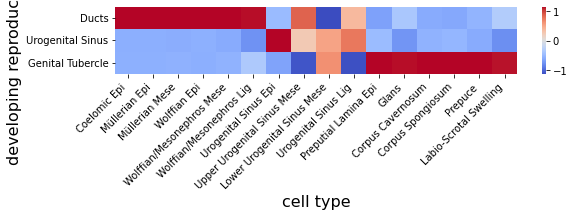

In [94]:
fig, ax = plt.subplots(figsize=(9, 1.25))         # Sample figsize in inches
g = sns.heatmap(z_scores, cmap='coolwarm', #annot=True, 
            # fmt='.1f', 
            ax = ax)

g.set_xlabel('cell type', fontsize=16)
g.set_ylabel('developing reproductive organ', fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation=45,  ha='right')

fig = g.get_figure()
fig.savefig("_ISS_less10pcw_abundance_per_anatomy_no_contaminants.pdf", bbox_inches='tight')
plt.show()

In [27]:
out.obs.head()

sample  total_counts  n_genes_by_counts leiden broad_anatomy  \
CM007_13  CM007          45.0                  9      0       Adrenal   
CM007_29  CM007          31.0                  6      1       Adrenal   
CM007_32  CM007          45.0                 10      1       Adrenal   
CM007_33  CM007          16.0                  4      1       Adrenal   
CM007_35  CM007          49.0                 11      1       Adrenal   

          broad_anatomy_number  L2_dist_broad_anatomy_Ducts  \
CM007_13                    11                          NaN   
CM007_29                    11                          NaN   
CM007_32                    11                          NaN   
CM007_33                    11                          NaN   
CM007_35                    11                          NaN   

          L2_dist_broad_anatomy_Adrenal  L2_dist_broad_anatomy_Gonad  \
CM007_13                            NaN                          NaN   
CM007_29                            NaN                          NaN   
CM007_32                            NaN                          NaN   
CM007_33                            NaN                          NaN   
CM007_35                            NaN                          NaN   

          L2_dist_broad_anatomy_Nephros  \
CM007_13                            NaN   
CM007_29                            NaN   
CM007_32                            NaN   
CM007_33                            NaN   
CM007_35                            NaN   

          L2_dist_broad_anatomy_UrogenitalSinus  \
CM007_13                                    NaN   
CM007_29                                    NaN   
CM007_32                                    NaN   
CM007_33                                    NaN   
CM007_35                                    NaN   

          L2_dist_broad_anatomy_Genital Tubercle  \
CM007_13                                     NaN   
CM007_29                                     NaN   
CM007_32                                     NaN   
CM007_33                                     NaN   
CM007_35                                     NaN   

          L2_dist_broad_anatomy_LabioScrotal Swelling  \
CM007_13                                          NaN   
CM007_29                                          NaN   
CM007_32                                          NaN   
CM007_33                                          NaN   
CM007_35                                          NaN   

          L2_dist_broad_anatomy_Urogenital Sinus batch  n_genes  \
CM007_13                                     NaN     0        9   
CM007_29                                     NaN     0        6   
CM007_32                                     NaN     0       10   
CM007_33                                     NaN     0        4   
CM007_35                                     NaN     0       11   

                          celltype  celltype_fraction  
CM007_13              Coelomic Epi           0.866667  
CM007_29              Coelomic Epi           0.933333  
CM007_32      Urogenital Sinus Lig           0.600000  
CM007_33              Coelomic Epi           0.866667  
CM007_35  Wolffian/Mesonephros Lig           0.666667

In [28]:
for s in [CM007, CM009, CM011, CM020]: 
    s.obs['celltype'] = s.obs_names.map(out.obs['celltype'].to_dict())
    s.obs['celltype'] = s.obs['celltype'].astype('str')
    s.obs['celltype_fraction'] = s.obs_names.map(out.obs['celltype_fraction'].to_dict())

## CM020

Adrenal Cortex
Coelomic Epi
Corpus Cavernosum
Corpus Spongiosum
Endothelial
Glans
Kidney - Loop of Henle
Kidney - Mese Progenitor
Kidney - Podocyte
Kidney - S-Shaped Body


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Kidney - Ureteric Bud
Labio-Scrotal Swelling
Lower Urogenital Sinus Mese


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Müllerian Epi
Müllerian Mese
Neural
Perivascular
Prepuce
Preputial Lamina Epi
Schwann
Upper Urogenital Sinus Mese


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Urogenital Sinus Epi
Urogenital Sinus Lig
Wolffian Epi
Wolffian/Mesonephros Lig
Wolffian/Mesonephros Mese
nan


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

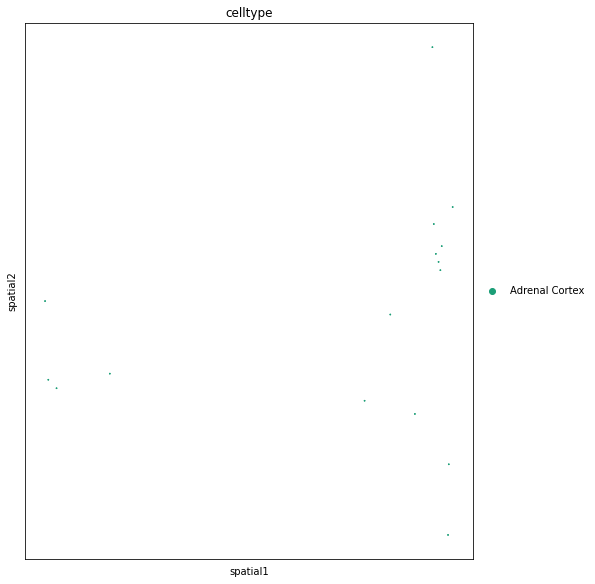

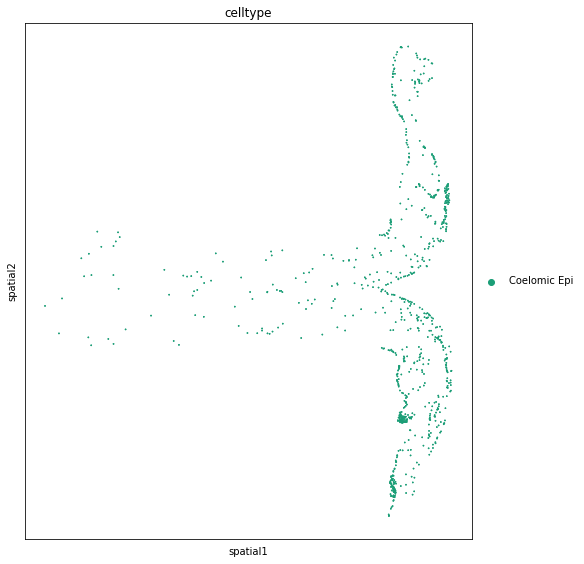

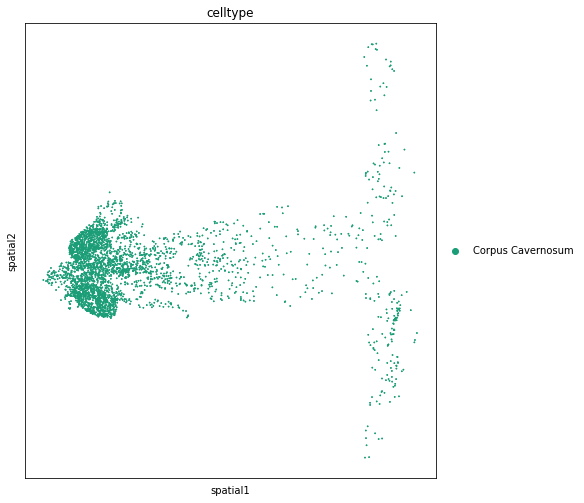

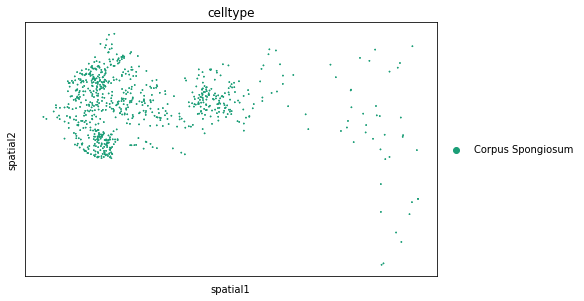

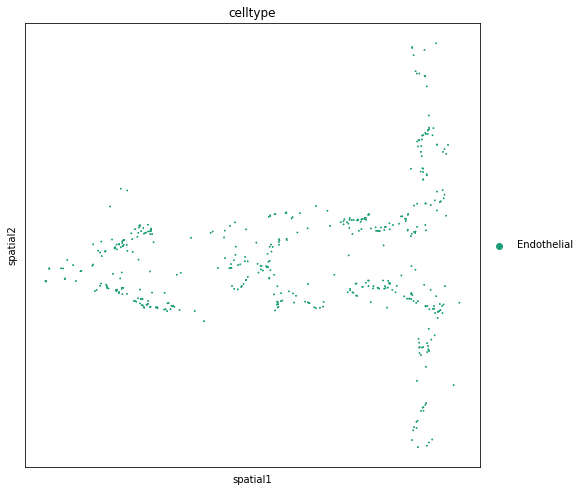

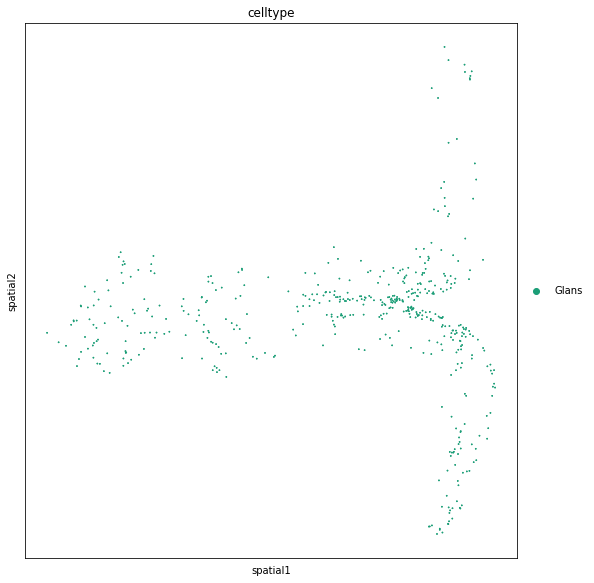

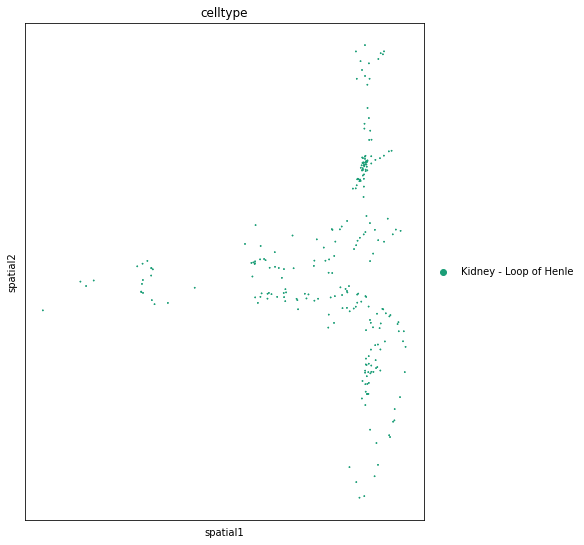

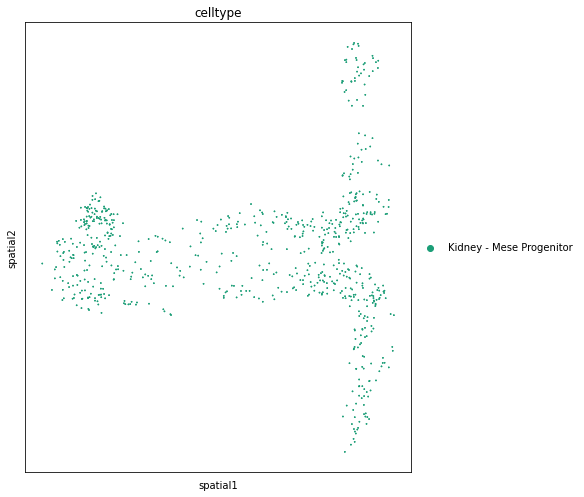

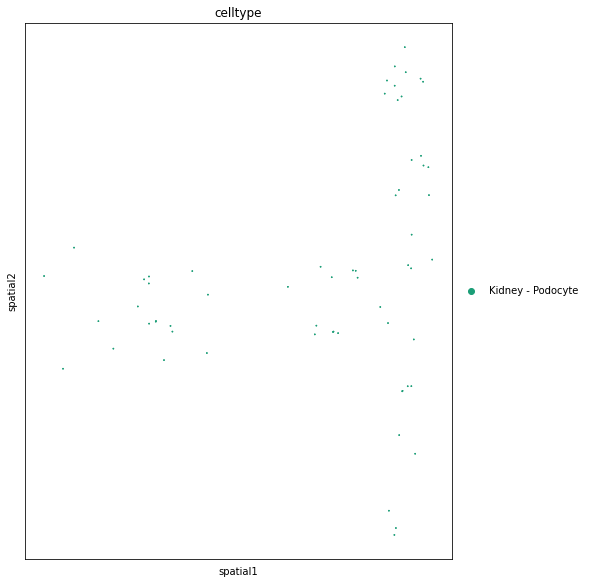

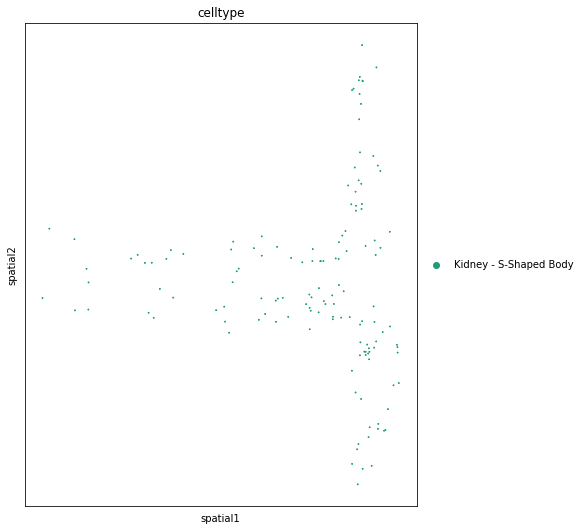

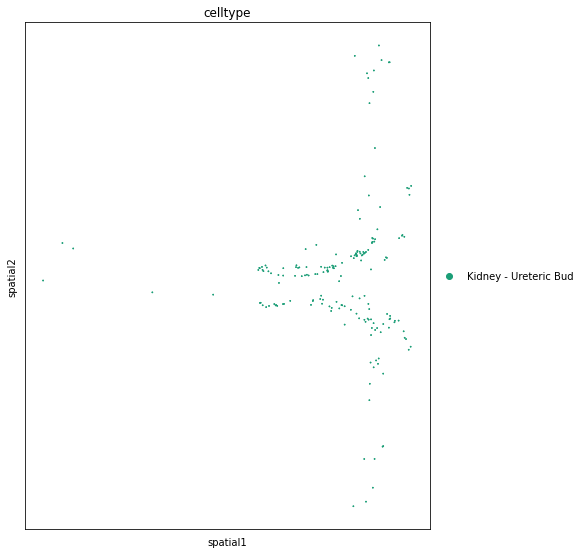

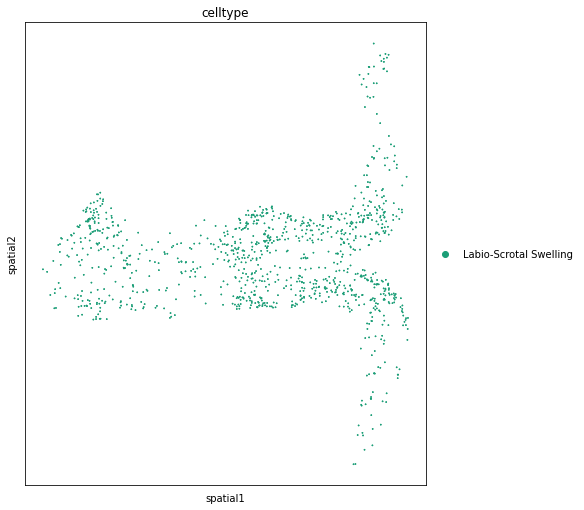

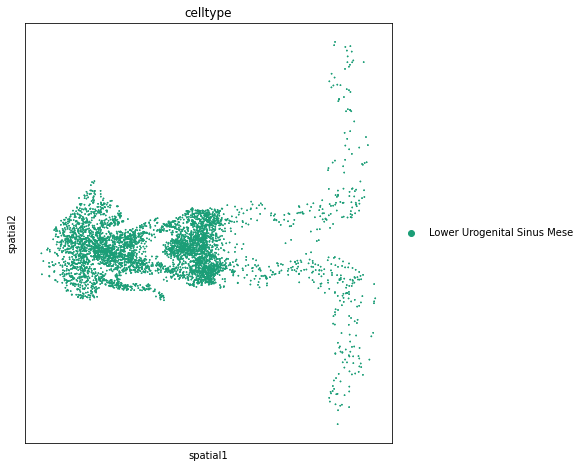

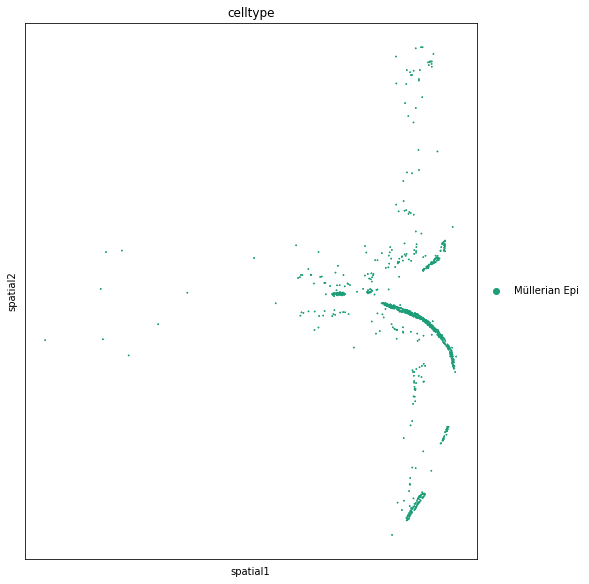

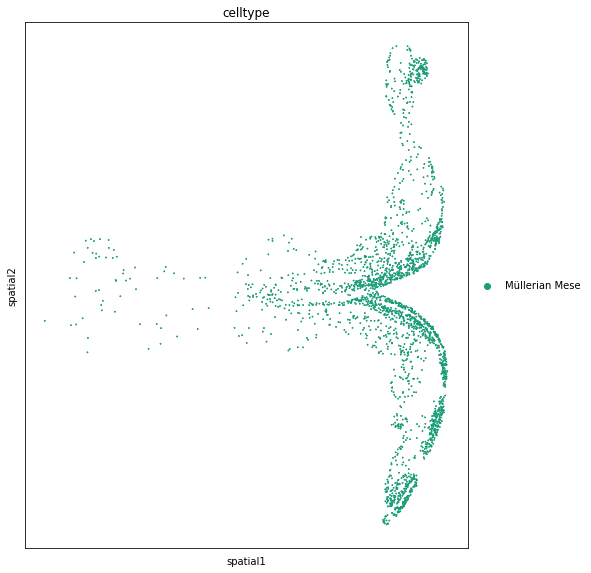

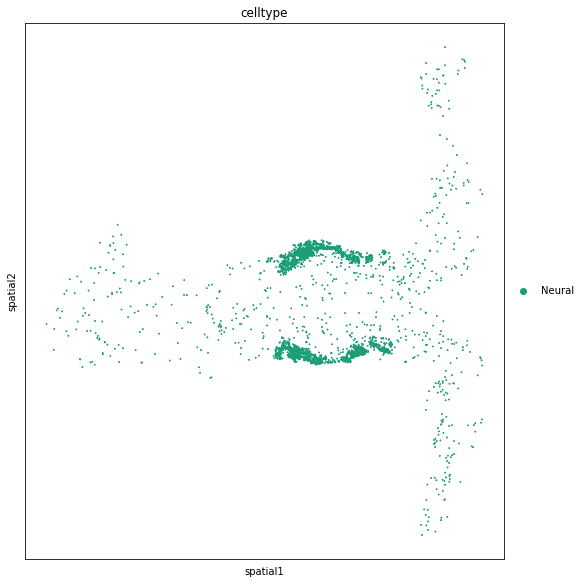

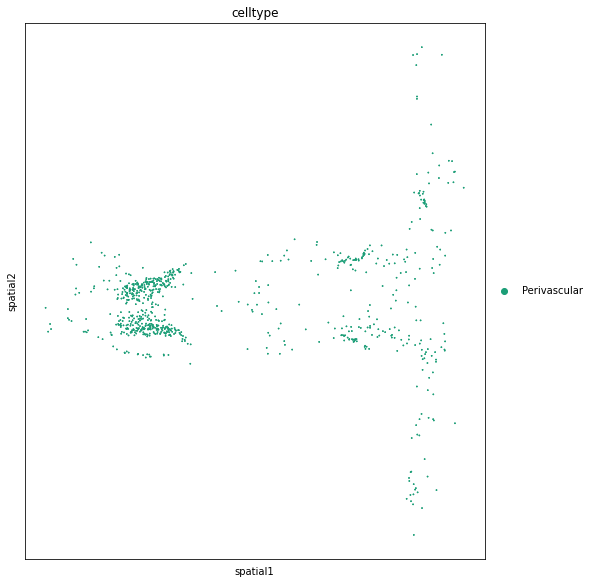

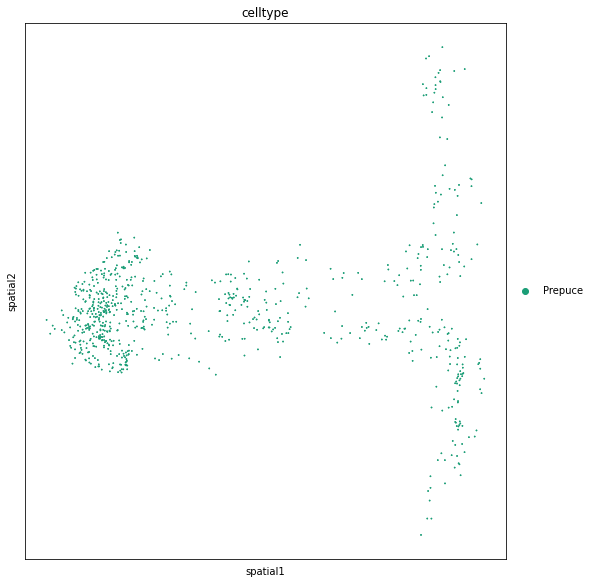

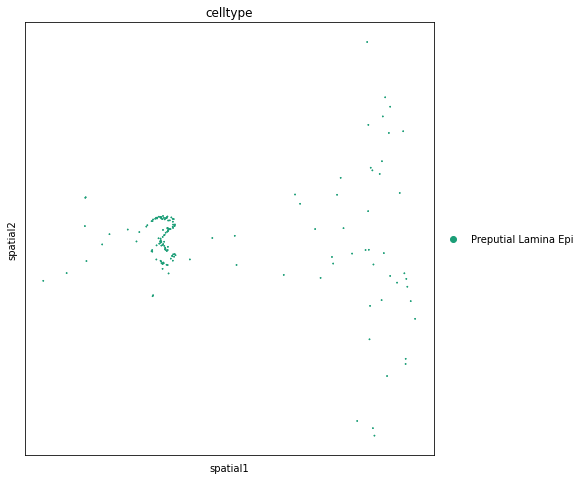

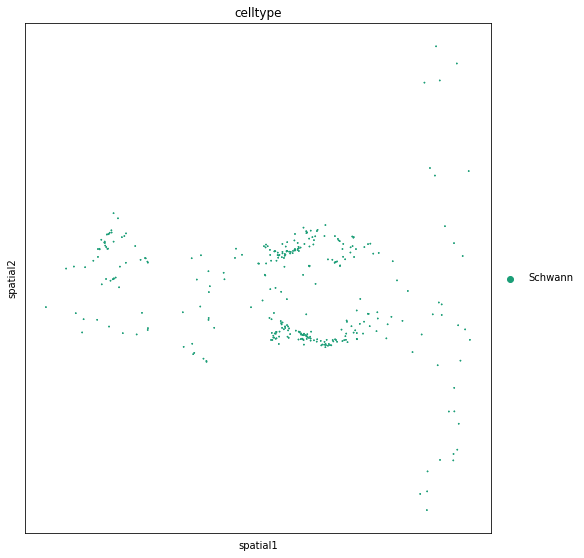

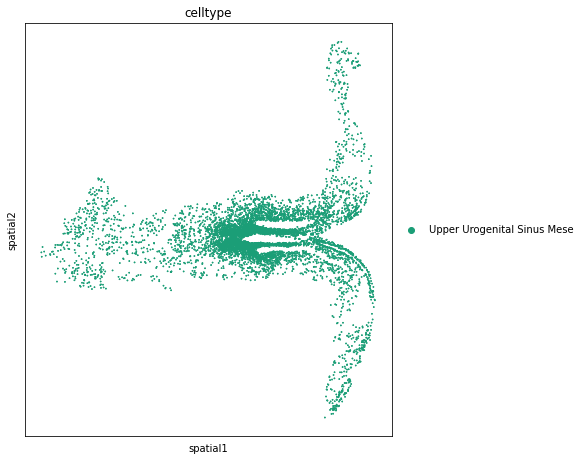

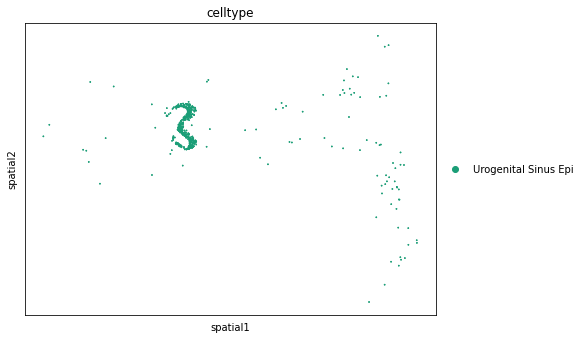

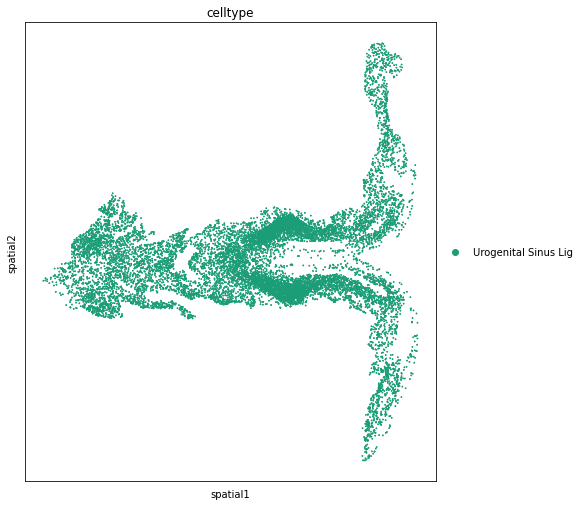

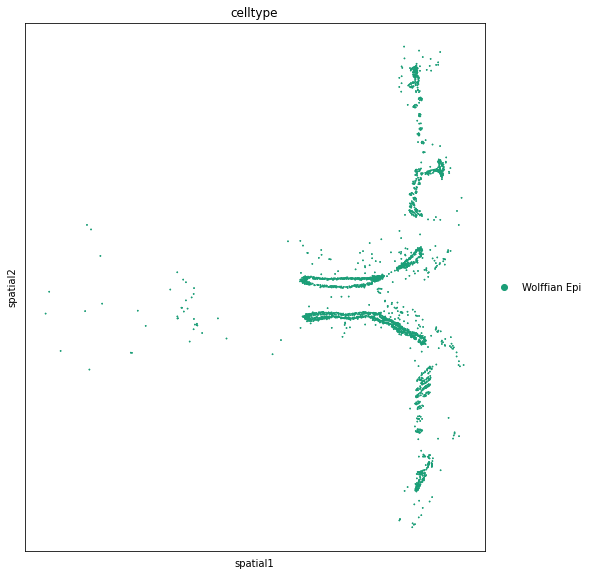

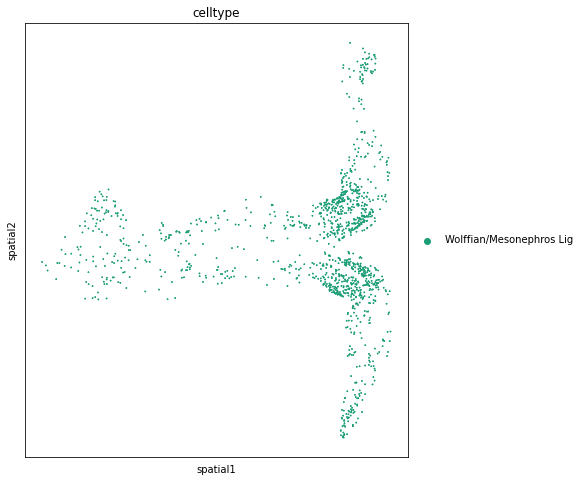

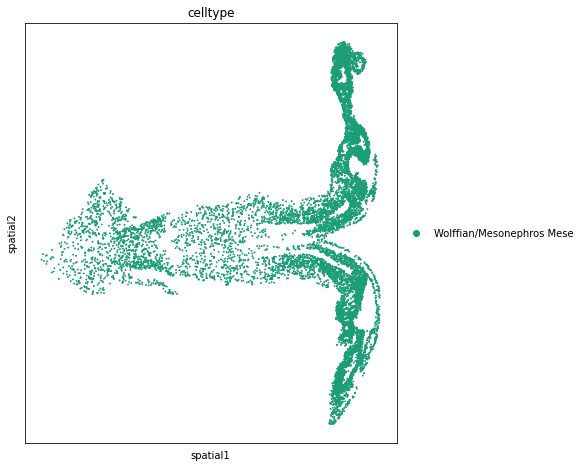

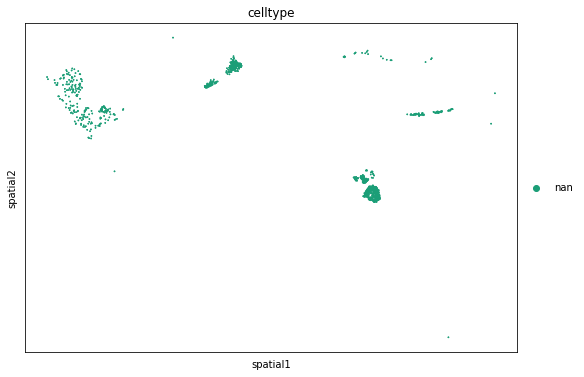

In [29]:
for i in np.unique(CM020.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM020,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [30]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                         frameon=True, vector_friendly=True, fontsize=14, figsize=[7,7], color_map=None, 
                         format='pdf', facecolor=None, transparent=False,)

In [31]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [32]:
np.unique(CM020.obs['celltype'])

array(['Adrenal Cortex', 'Coelomic Epi', 'Corpus Cavernosum',
       'Corpus Spongiosum', 'Endothelial', 'Glans',
       'Kidney - Loop of Henle', 'Kidney - Mese Progenitor',
       'Kidney - Podocyte', 'Kidney - S-Shaped Body',
       'Kidney - Ureteric Bud', 'Labio-Scrotal Swelling',
       'Lower Urogenital Sinus Mese', 'Müllerian Epi', 'Müllerian Mese',
       'Neural', 'Perivascular', 'Prepuce', 'Preputial Lamina Epi',
       'Schwann', 'Upper Urogenital Sinus Mese', 'Urogenital Sinus Epi',
       'Urogenital Sinus Lig', 'Wolffian Epi', 'Wolffian/Mesonephros Lig',
       'Wolffian/Mesonephros Mese', 'nan'], dtype=object)

In [33]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Urogenital Sinus Epi', 
                            'Upper Urogenital Sinus Mese',
                            'Lower Urogenital Sinus Mese'
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM020.obs['ugs'] = CM020.obs.apply(new_column, axis=1)

In [34]:
CM020.obs['ugs'].value_counts(dropna=False)

NaN                            50982
Upper Urogenital Sinus Mese     1797
Lower Urogenital Sinus Mese     1634
Urogenital Sinus Epi             343
Name: ugs, dtype: int64

In [39]:
CM020.obs['ugs'] = CM020.obs['ugs'].astype(str)
CM020.obs['ugs'] = CM020.obs['ugs'].astype('category')
CM020.obs['ugs'] = CM020.obs['ugs'].cat.reorder_categories([
    'Urogenital Sinus Epi', 'Upper Urogenital Sinus Mese', 'Lower Urogenital Sinus Mese',  'nan'
])


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


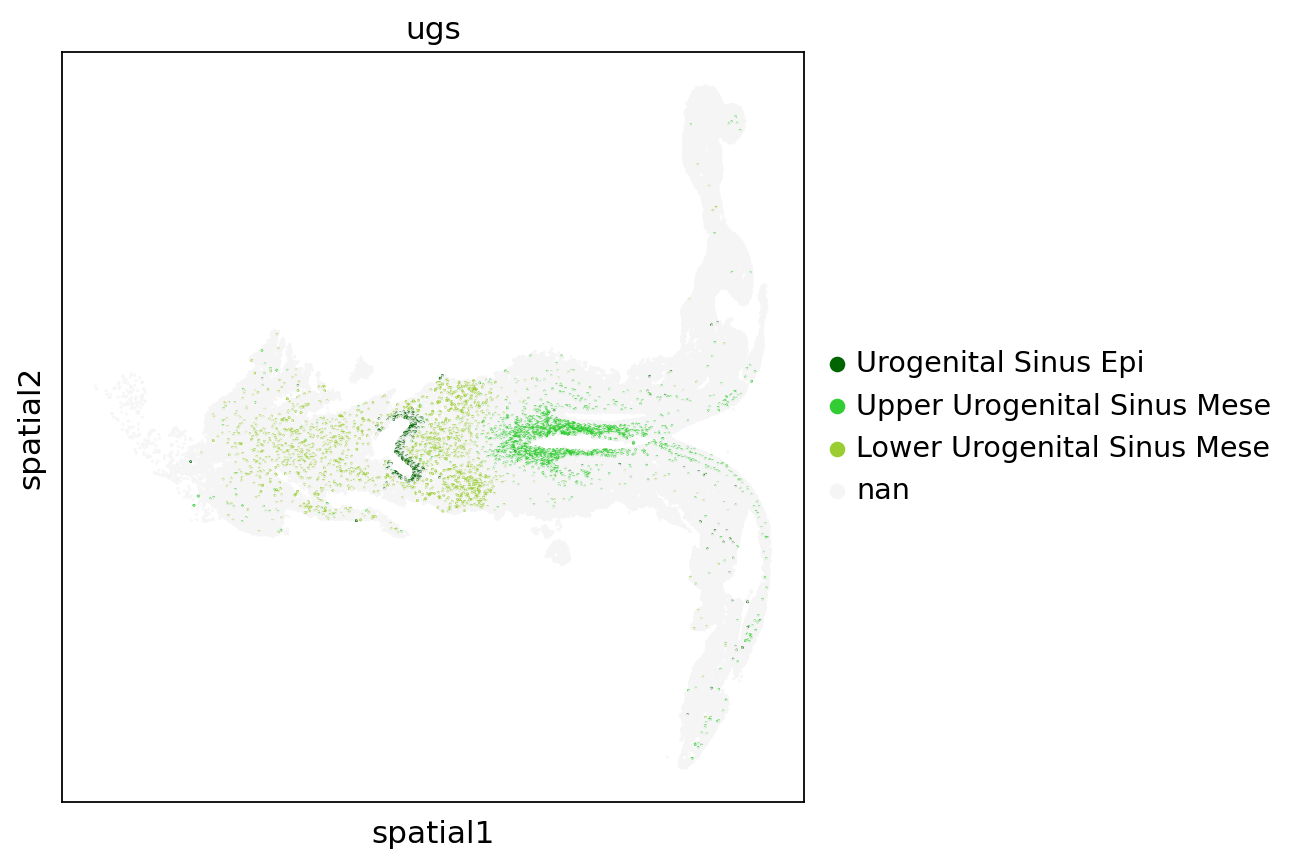

In [53]:
sq.pl.spatial_scatter(
    CM020,
    spatial_key="spatial",
    color=['ugs'],
    shape=None,
    use_raw = False,
    size=0.2,
    cmap = 'jet',
    figsize=(8,8), 
#           legend_loc = 'right margin',
#                             palette= { 'Urogenital Sinus Epi' : 'darkgreen',
#                                       'Upper Urogenital Sinus Mese' : 'limegreen', 
#                                       'Lower Urogenital Sinus Mese' : 'yellowgreen',
#                'nan' : 'whitesmoke'
#                                      },
    save = 'CM020_ugs_filtered.pdf'
)

In [101]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Coelomic Epi',  'Müllerian Epi', 
       'Wolffian Epi', 'Urogenital Sinus Epi', 
                            
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM020.obs['ducts'] = CM020.obs.apply(new_column, axis=1)


In [102]:
CM020.obs['ducts'].value_counts(dropna=False)

NaN                     51712
Wolffian Epi             1592
Coelomic Epi              555
Müllerian Epi             554
Urogenital Sinus Epi      343
Name: ducts, dtype: int64

In [103]:
CM020.obs['ducts'] = CM020.obs['ducts'].astype(str)
CM020.obs['ducts'] = CM020.obs['ducts'].astype('category')
CM020.obs['ducts'] = CM020.obs['ducts'].cat.reorder_categories([
    'Coelomic Epi',  'Müllerian Epi', 
       'Wolffian Epi', 'Urogenital Sinus Epi',  'nan'
])


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


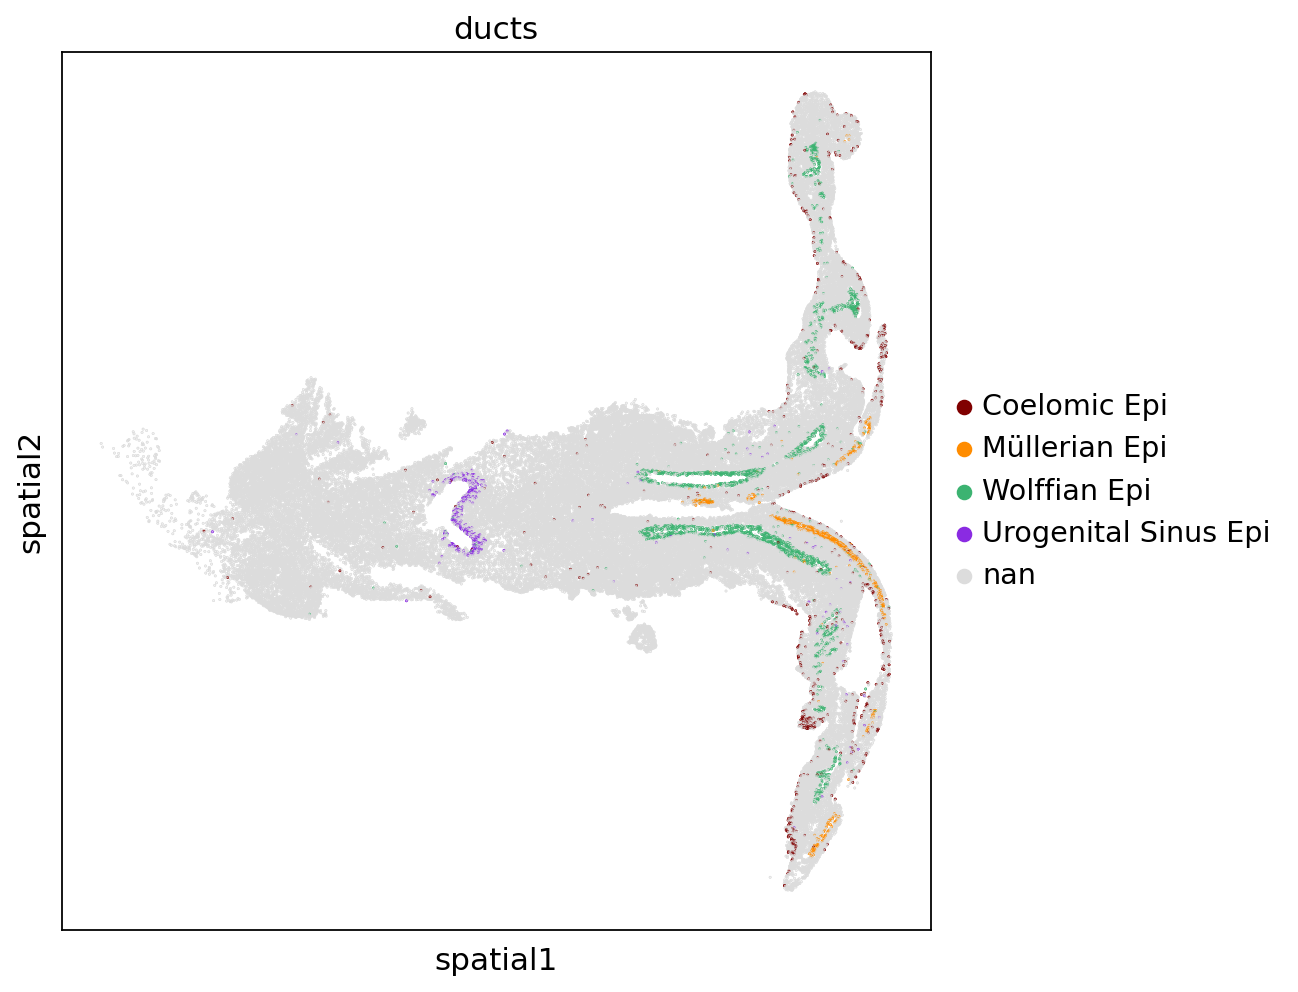

In [113]:
sq.pl.spatial_scatter(
    CM020,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=0.2,
    cmap = 'jet',
    figsize=(8,8), 
#           legend_loc = 'right margin',
#                             palette= {'Coelomic Epi' : 'maroon',  'Müllerian Epi' : 'darkorange', 
#        'Wolffian Epi' : 'mediumseagreen', 'Urogenital Sinus Epi' : 'blueviolet',
#                'nan' : 'gainsboro'
#                                      },
    save = 'CM020_ducts_filtered.pdf'
)

In [144]:
CM020.obs['broad_anatomy'].value_counts(dropna = False)

Ducts               29000
Urogenital Sinus    14780
Genital Tubercle     9663
Unassigned            597
Nephros               485
Background            231
Name: broad_anatomy, dtype: int64

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


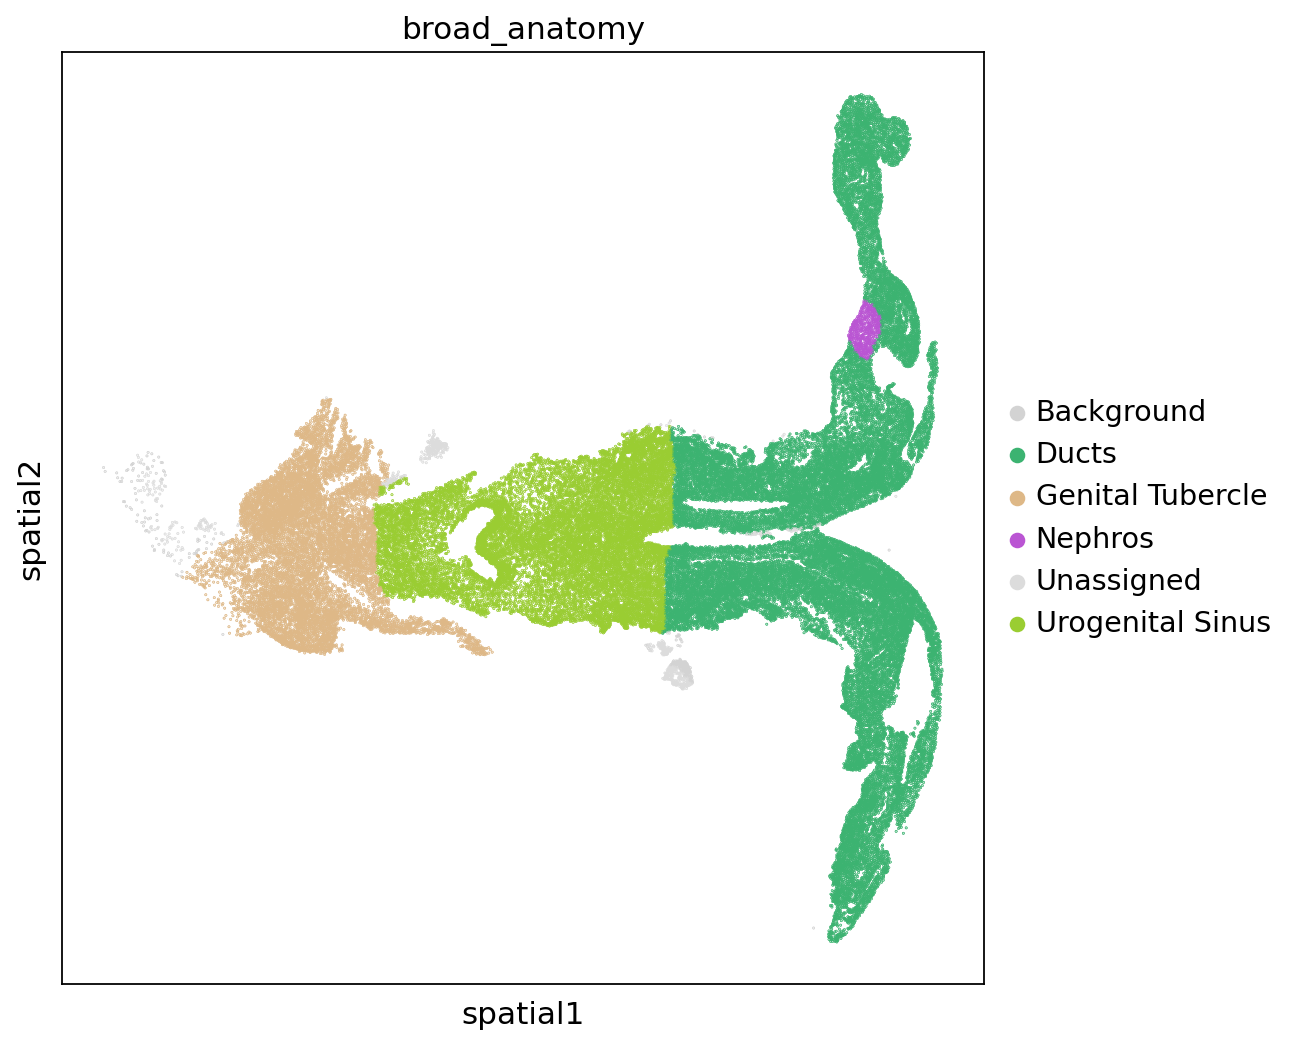

In [148]:
sq.pl.spatial_scatter(
    CM020,
    spatial_key="spatial",
    color=['broad_anatomy'],
    shape=None,
    use_raw = False,
    size=0.2,
    cmap = 'jet',
    figsize=(8,8), 
#            legend_loc = 'right margin',
#                              palette= {'Ducts' : 'mediumseagreen',  'Urogenital Sinus' : 'yellowgreen', 
#                     'Genital Tubercle' : 'burlywood',  
#                                        'Nephros' : 'mediumorchid', 
#                 'Unassigned' : 'gainsboro', 'Background' : 'lightgrey',
#                                       },
    save = 'CM020_ducts_anatomy.pdf'
)

## CM009

Adrenal Cortex
Coelomic Epi
Corpus Cavernosum
Corpus Spongiosum
Endothelial
Glans
Kidney - Loop of Henle
Kidney - Mese Progenitor


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Kidney - Podocyte
Kidney - S-Shaped Body
Kidney - Ureteric Bud
Labio-Scrotal Swelling
Lower Urogenital Sinus Mese
Müllerian Epi
Müllerian Mese
Neural


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Perivascular
Prepuce
Preputial Lamina Epi
Schwann
Upper Urogenital Sinus Mese
Urogenital Sinus Epi
Urogenital Sinus Lig
Wolffian Epi
Wolffian/Mesonephros Lig


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Wolffian/Mesonephros Mese
nan


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


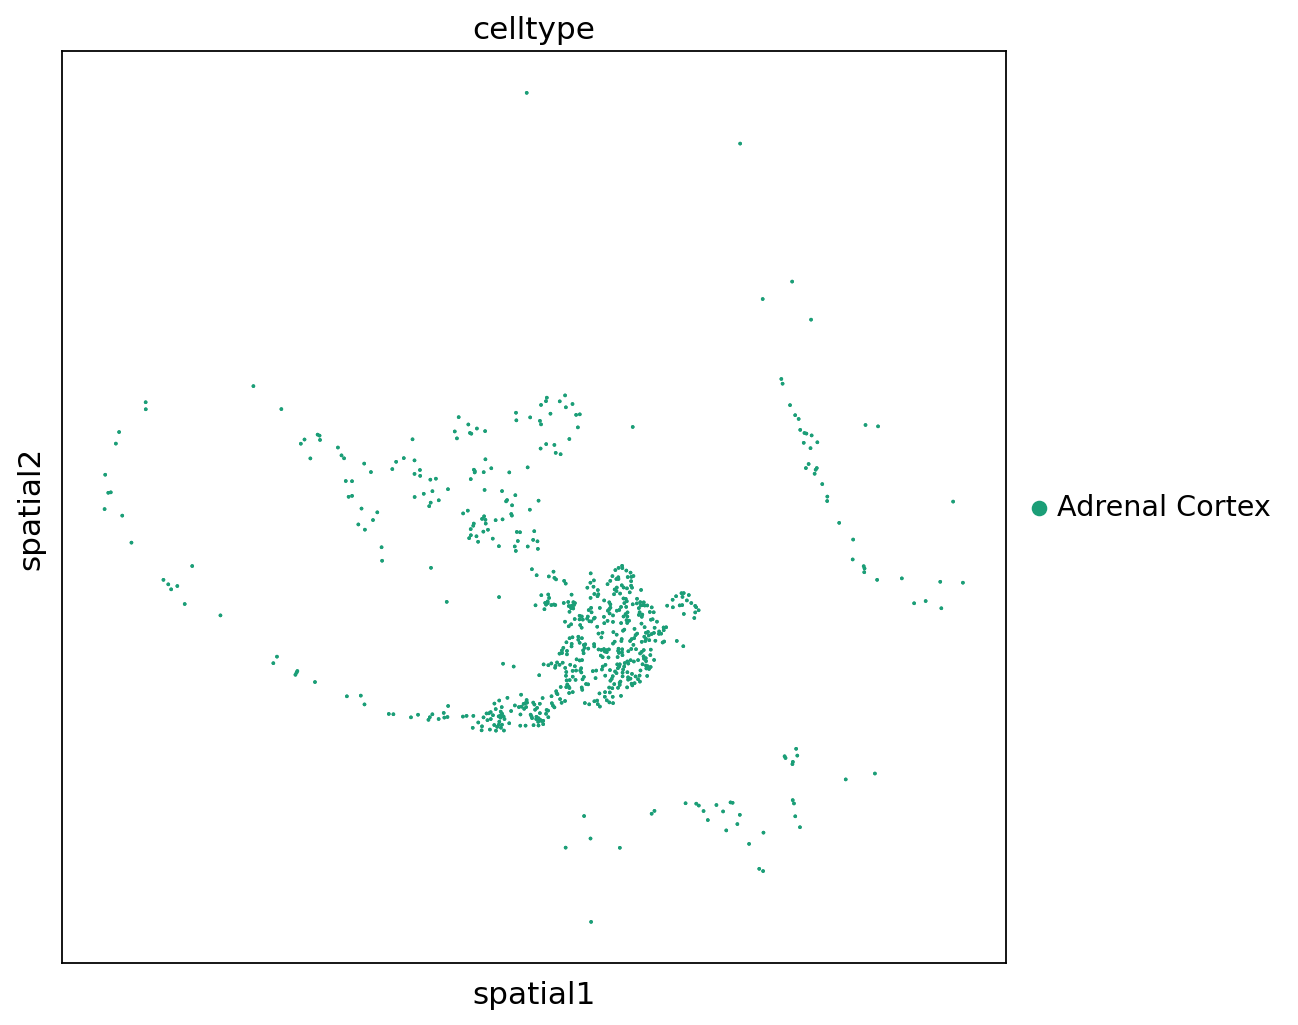

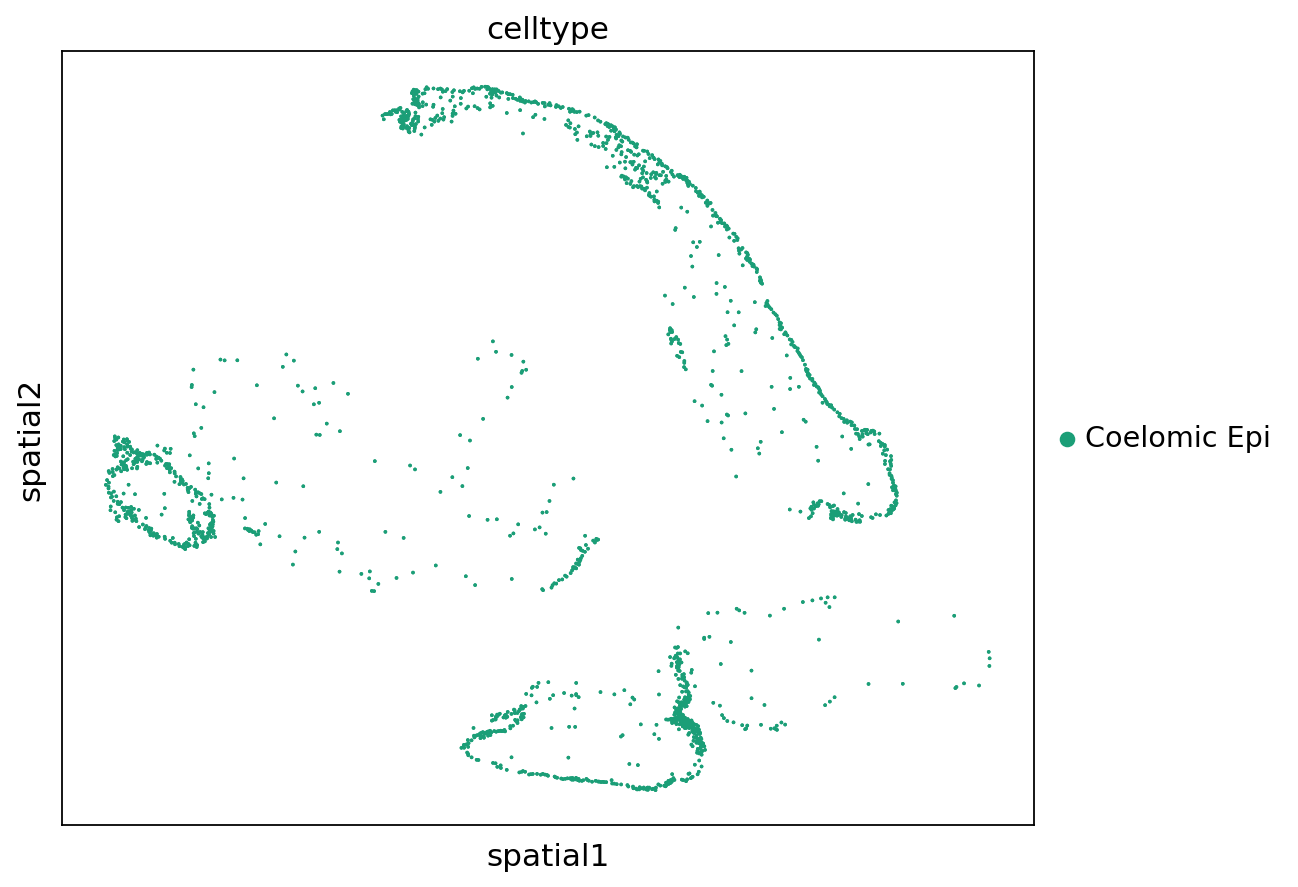

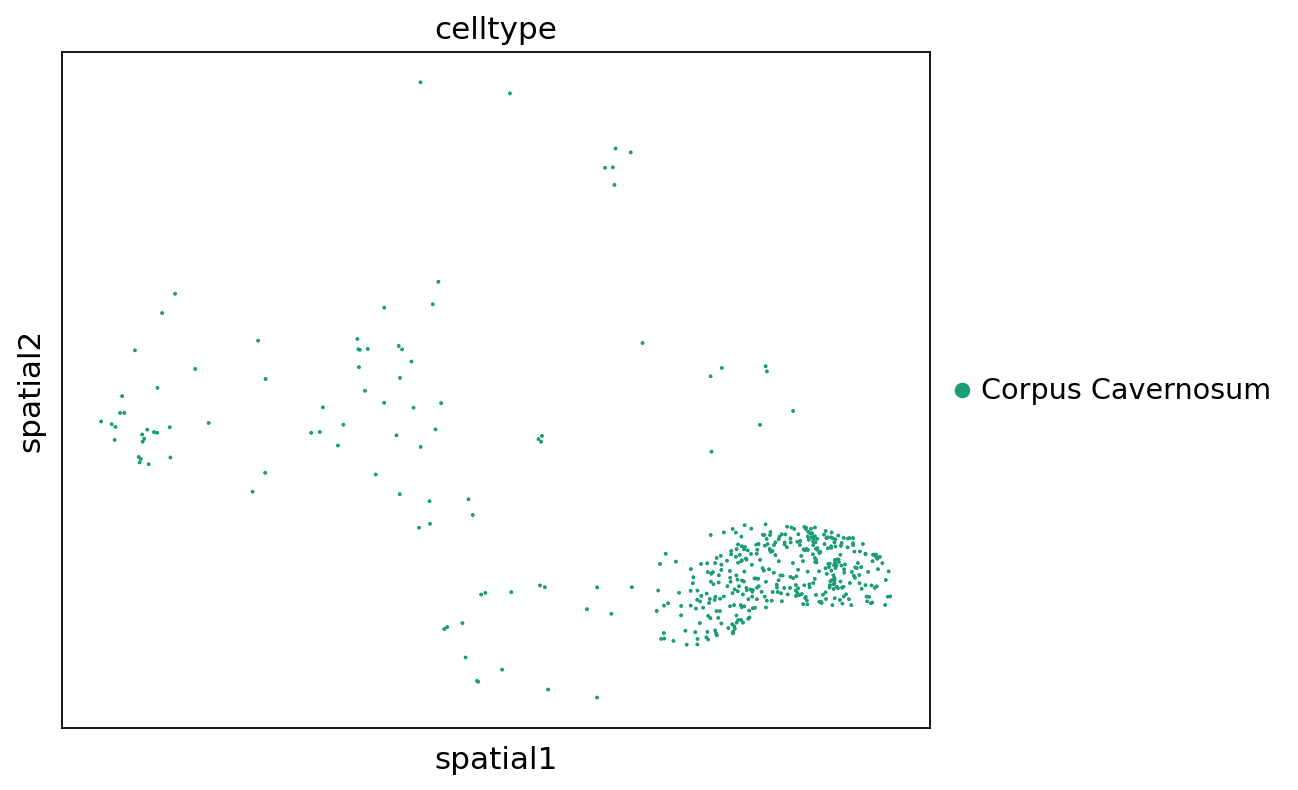

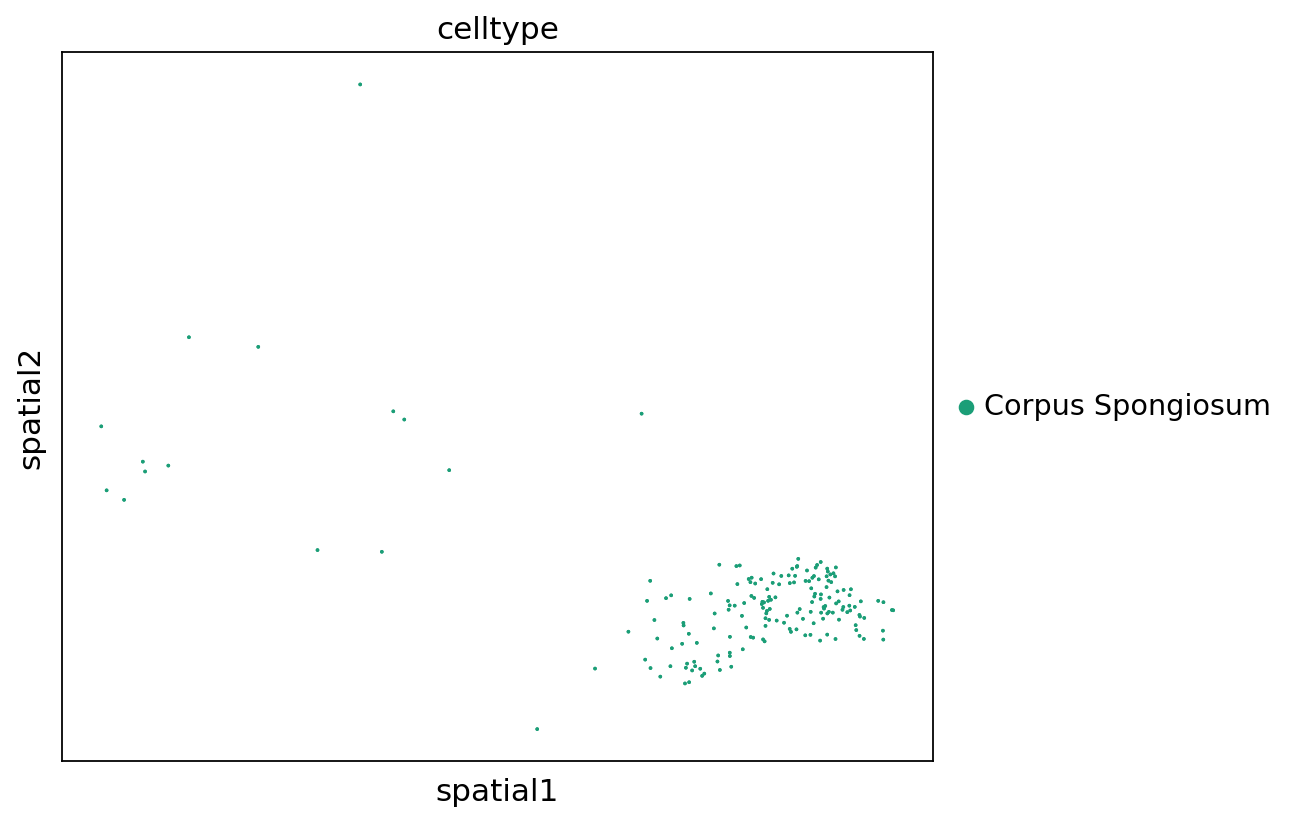

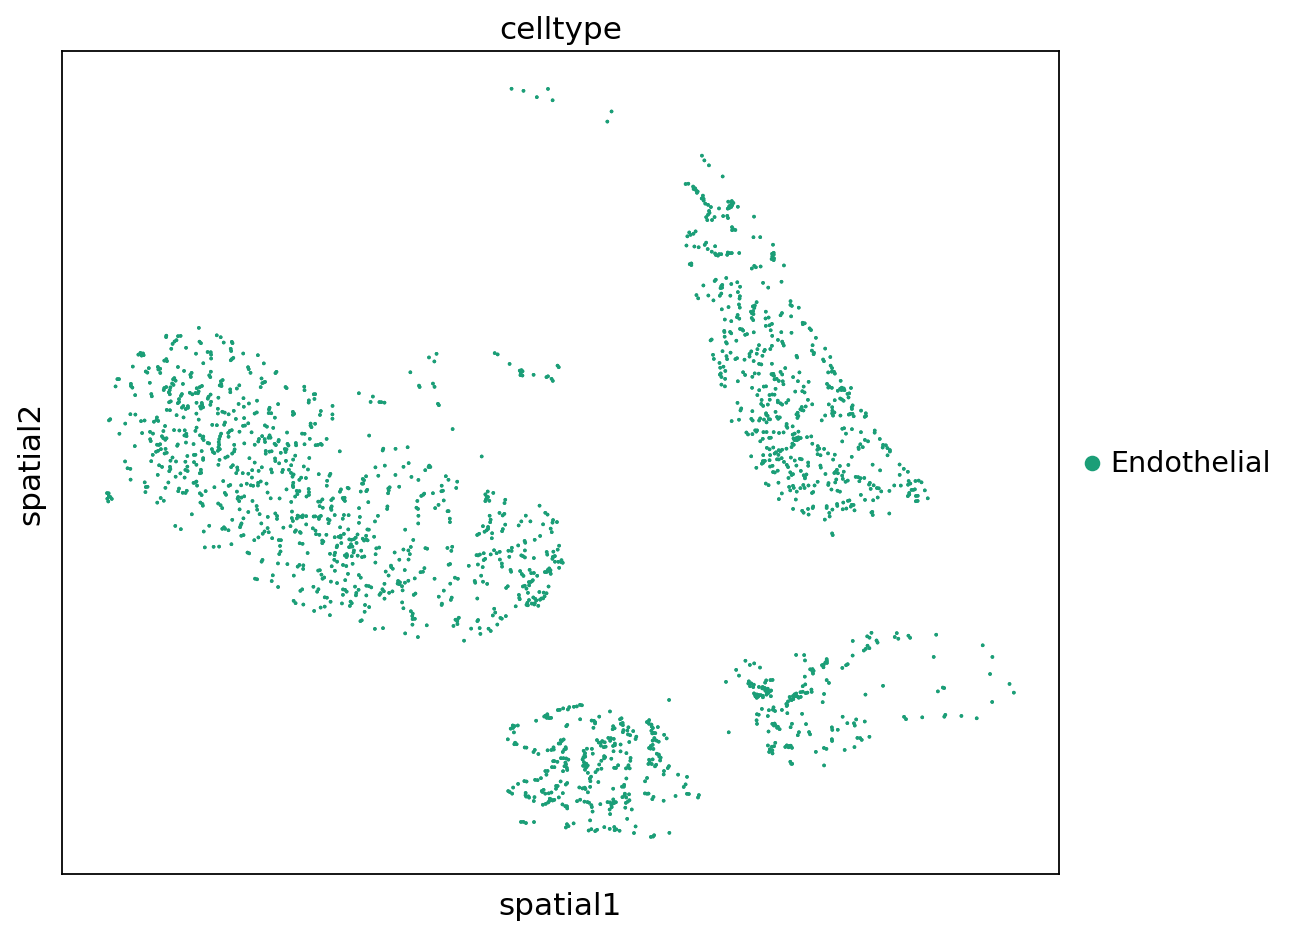

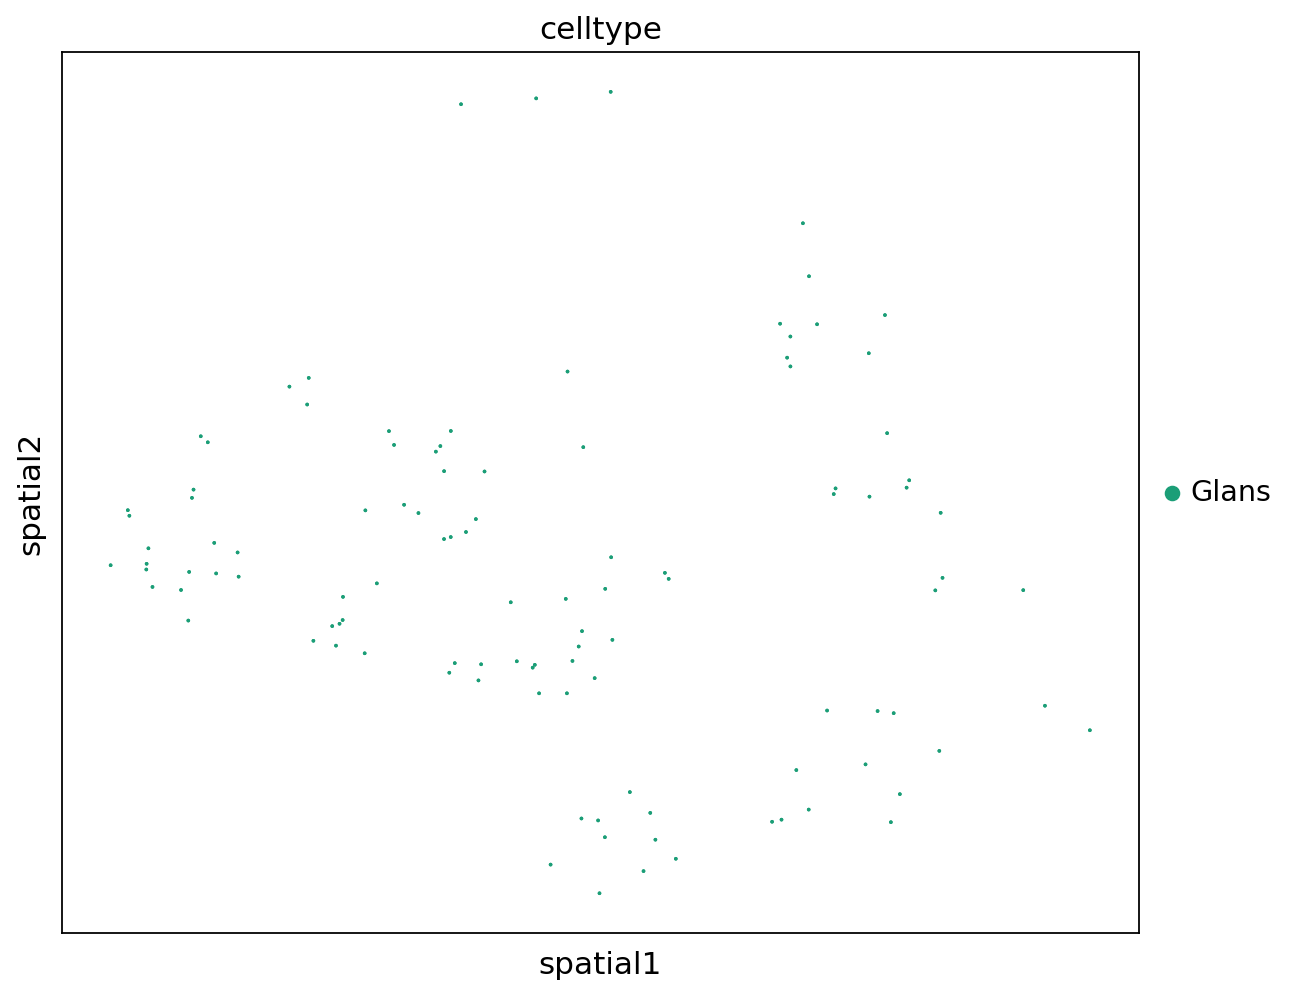

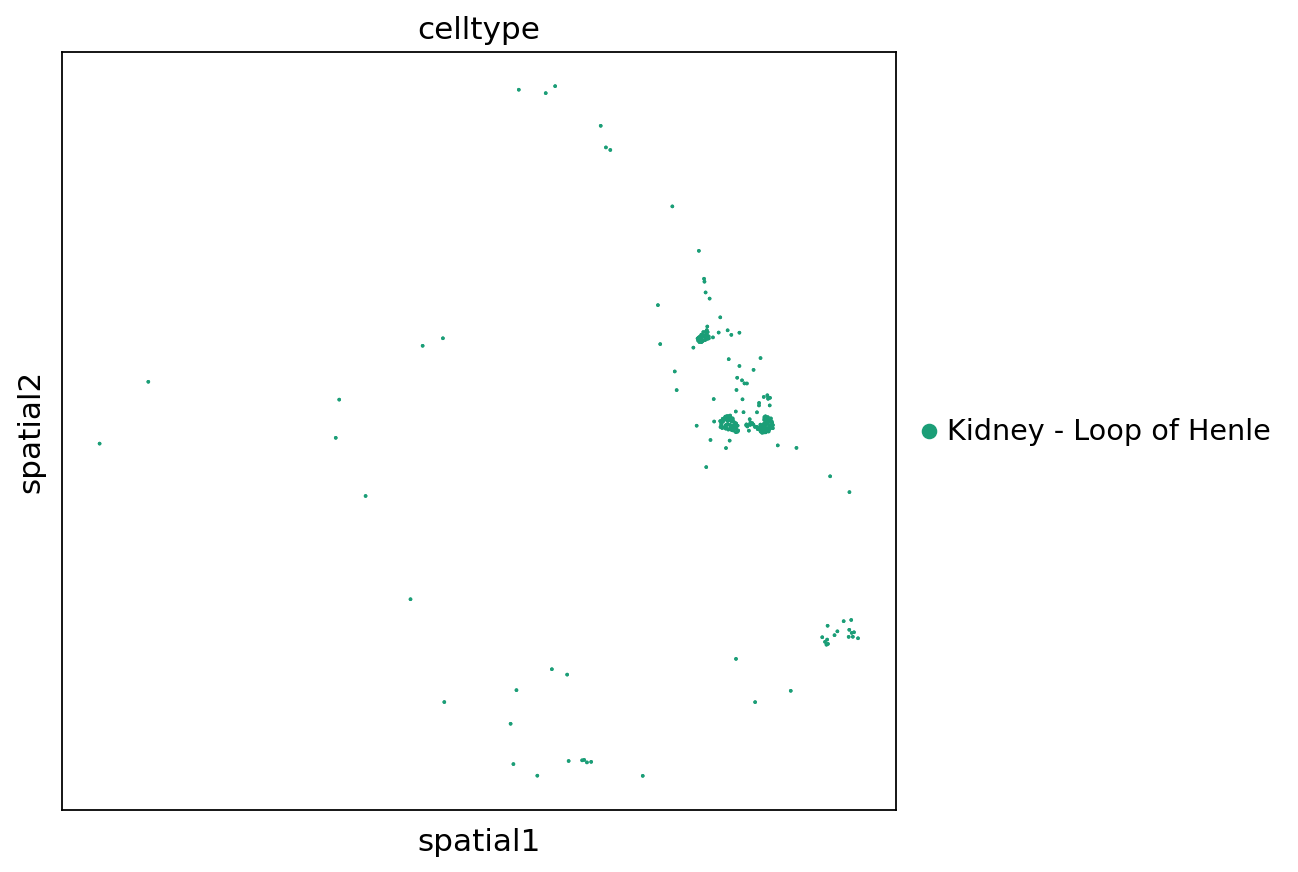

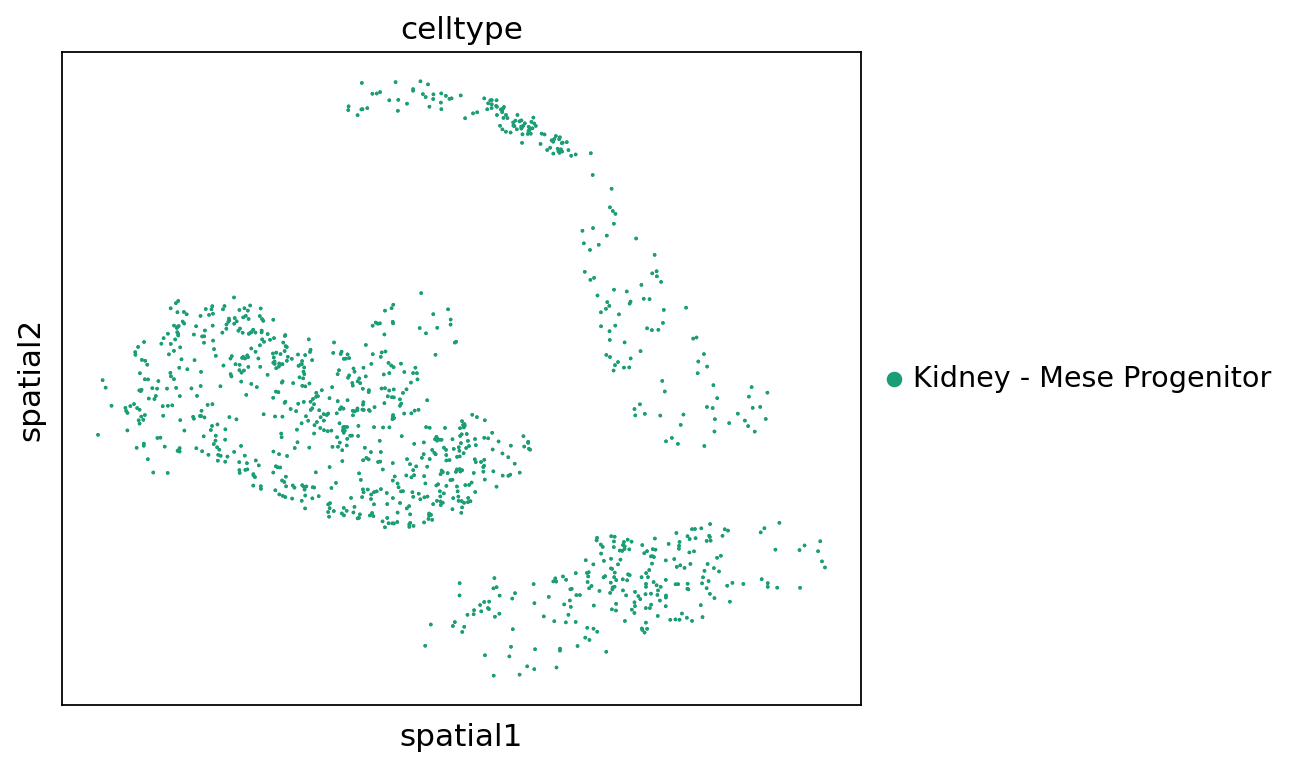

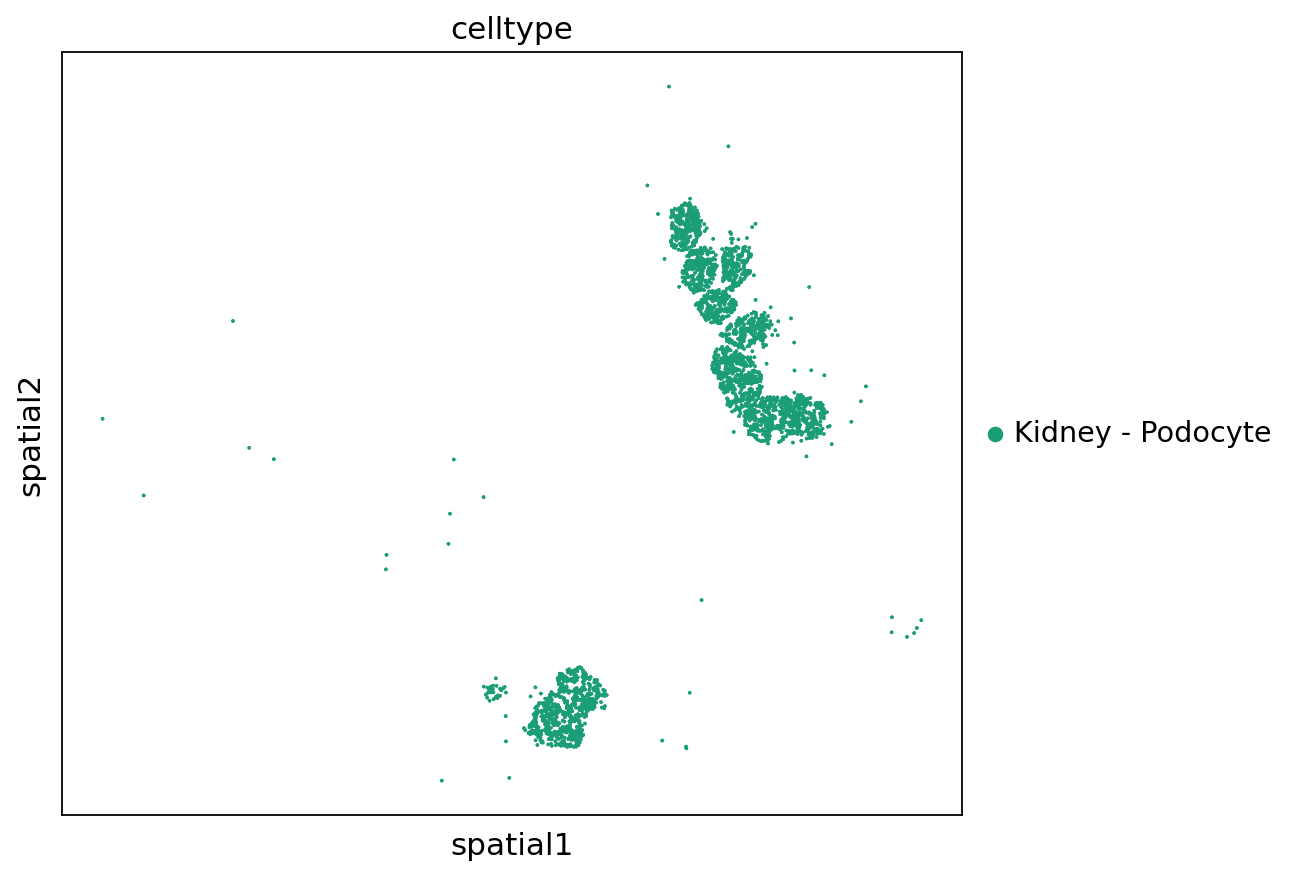

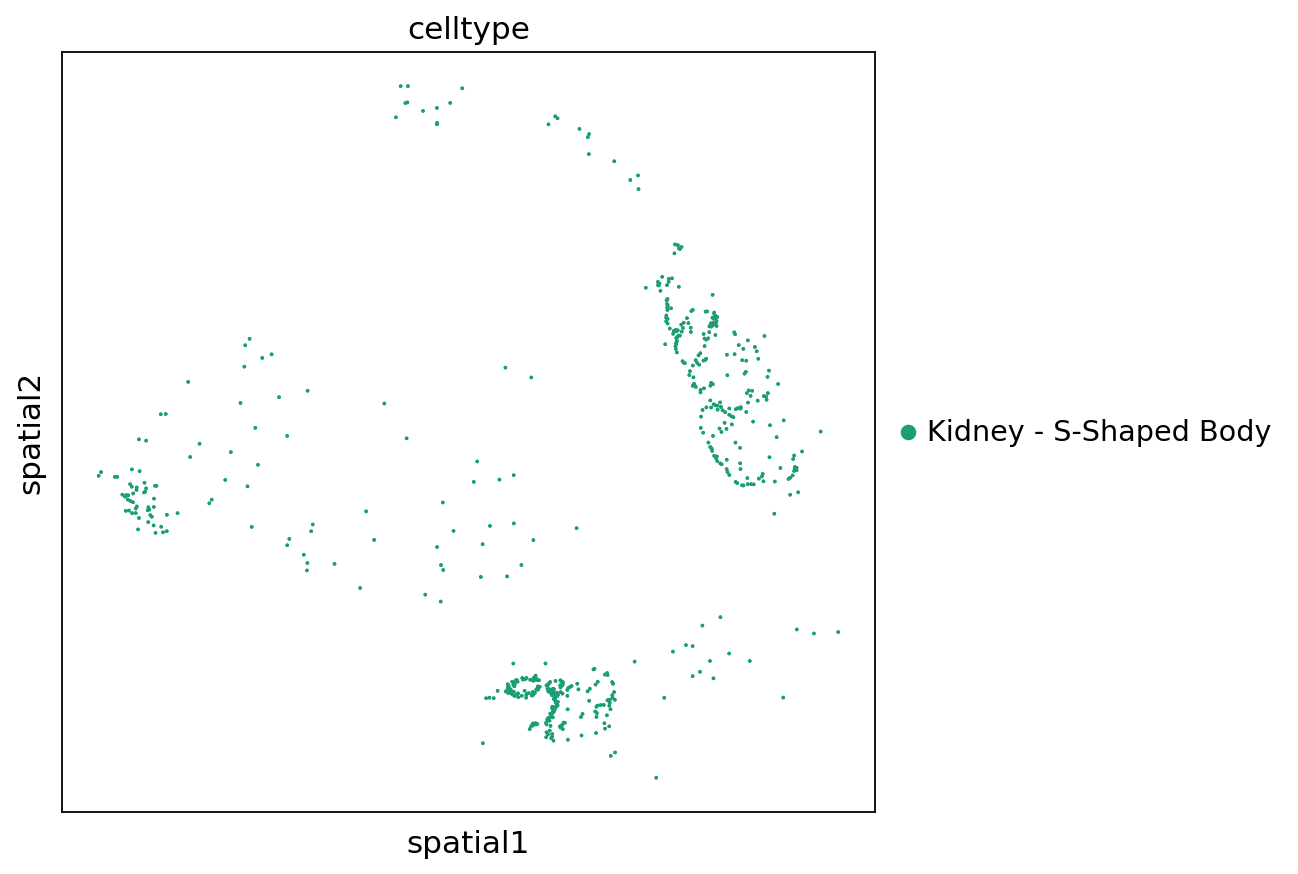

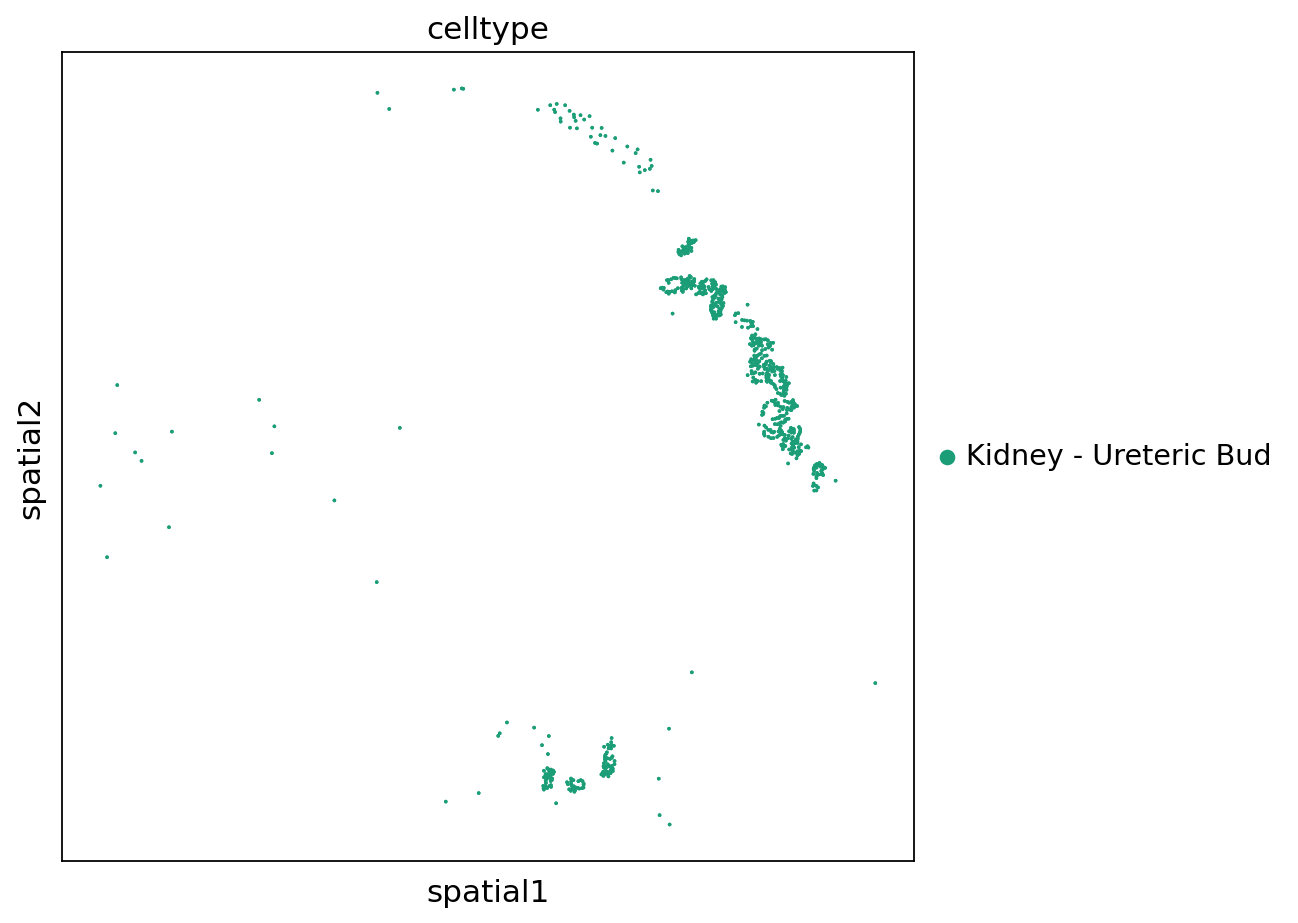

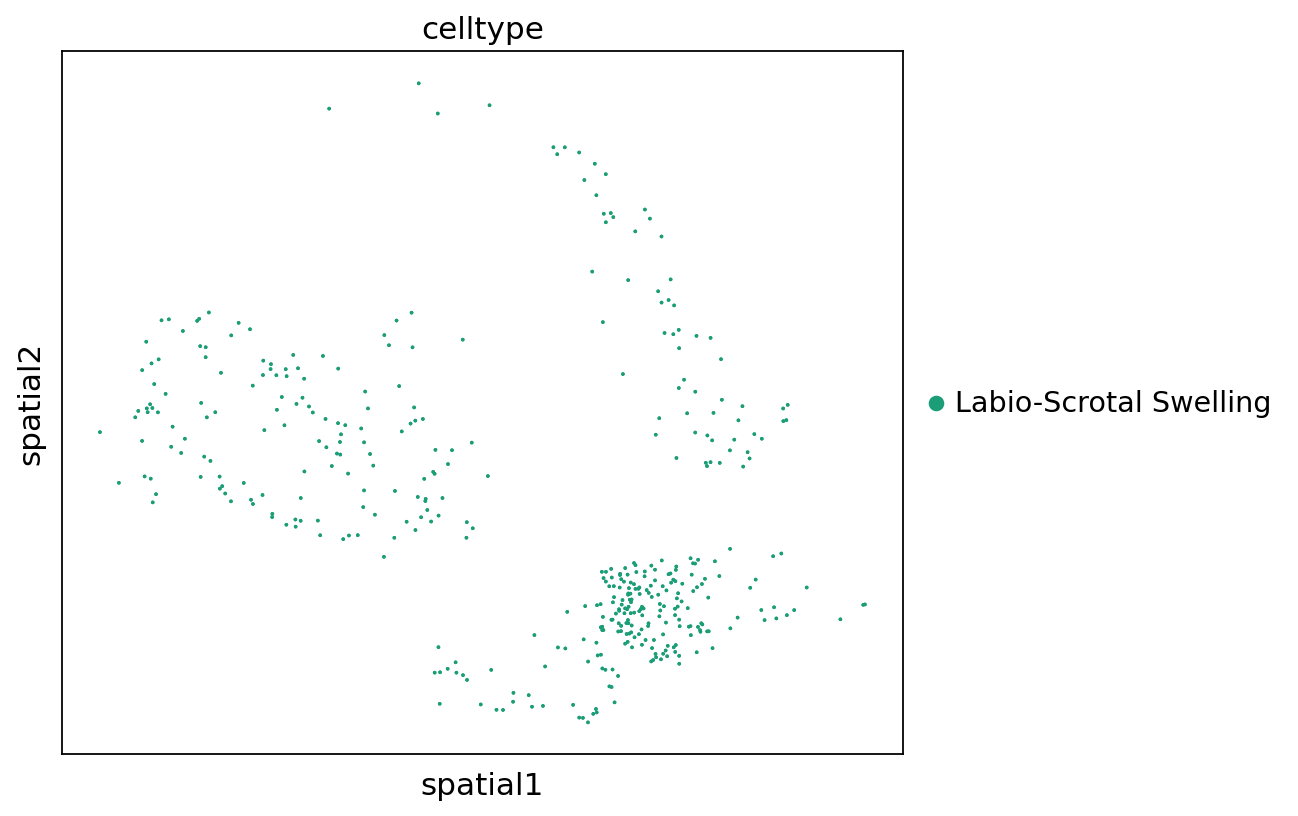

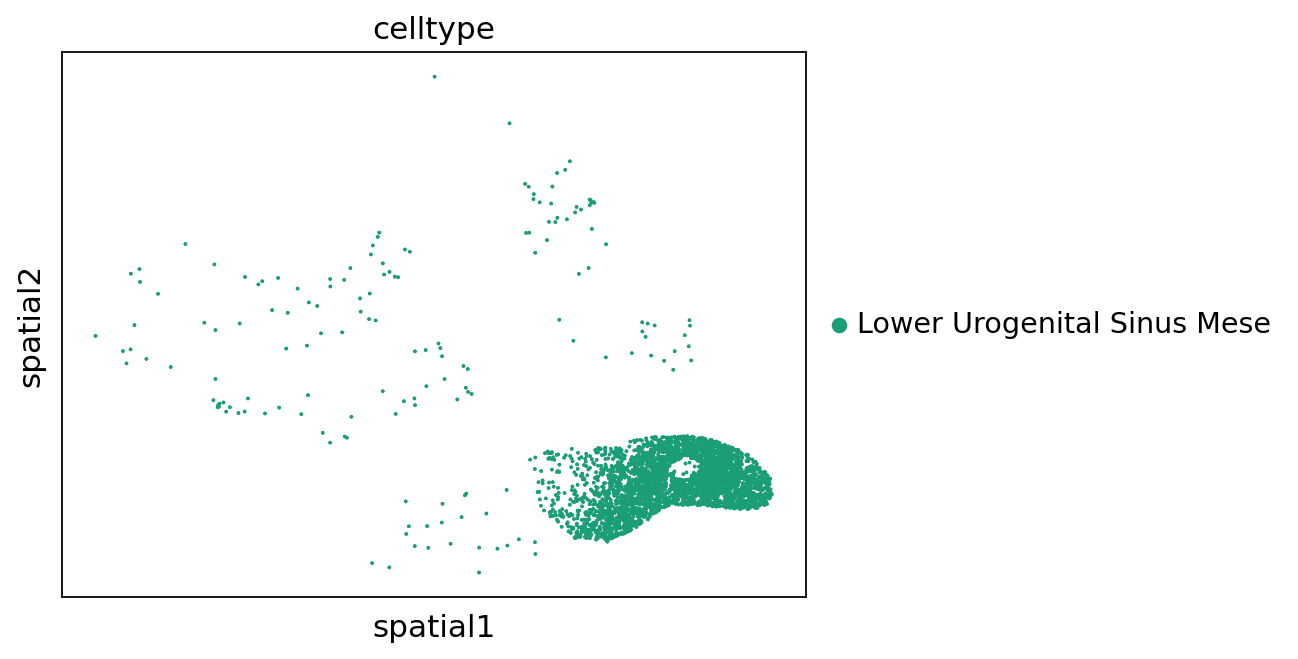

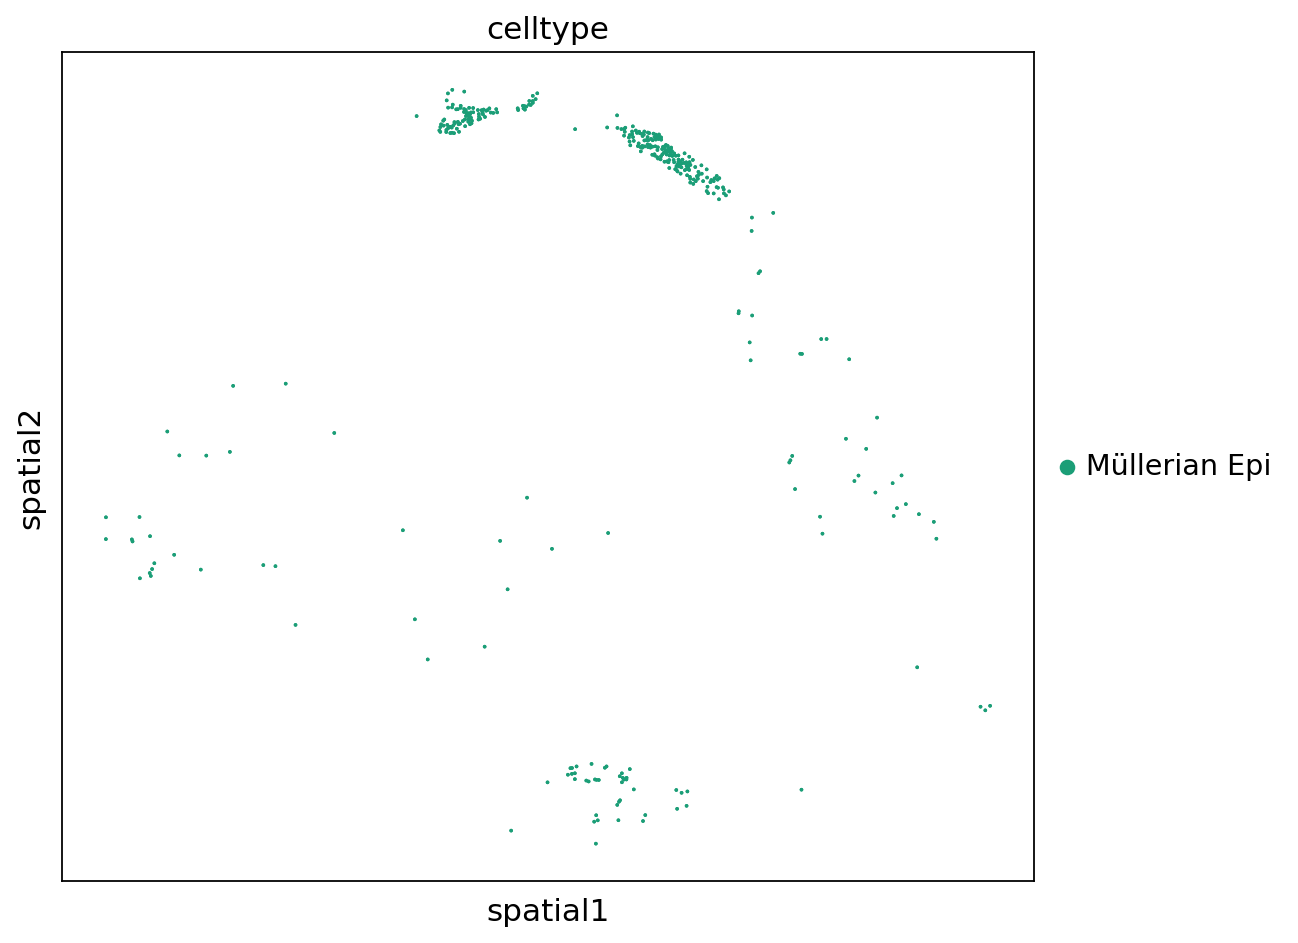

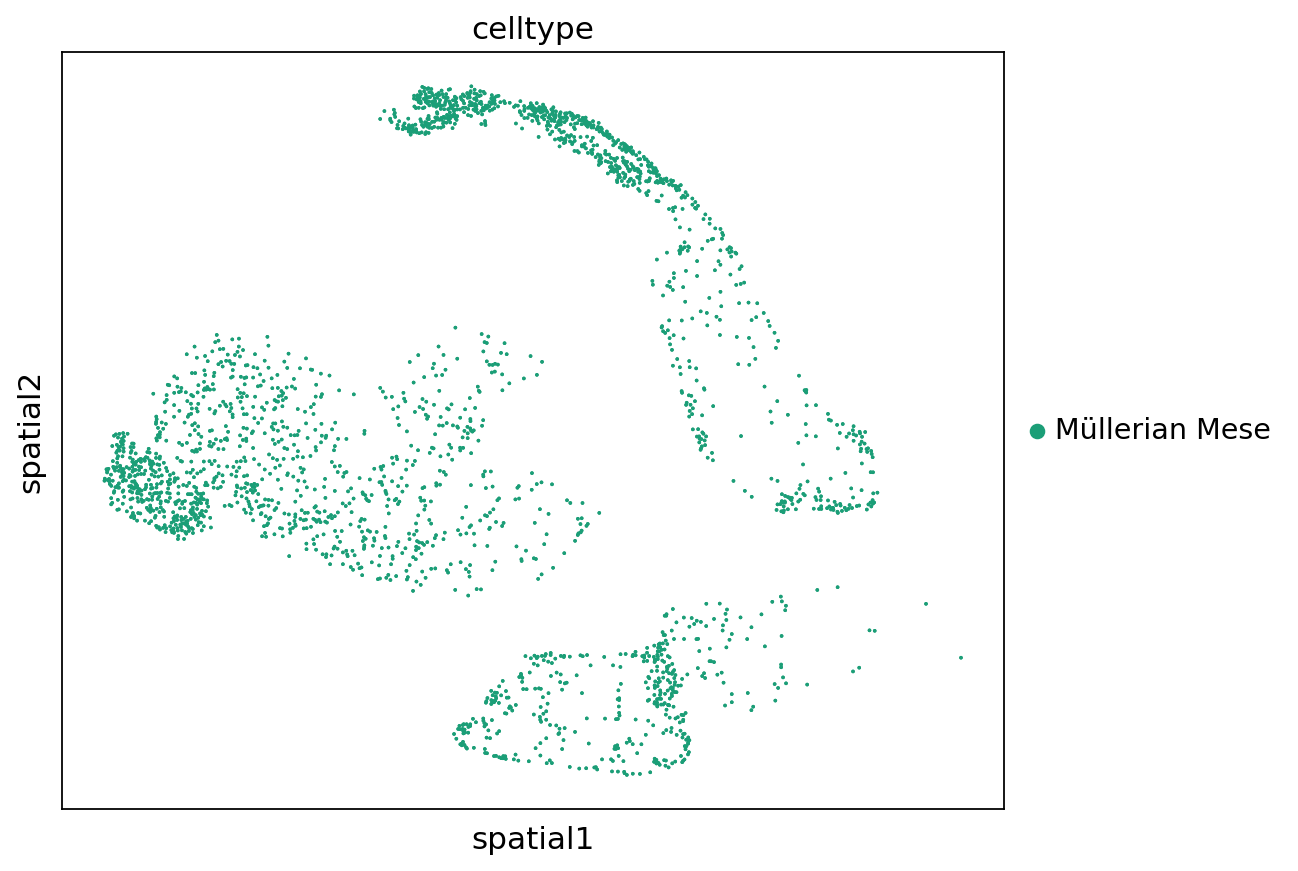

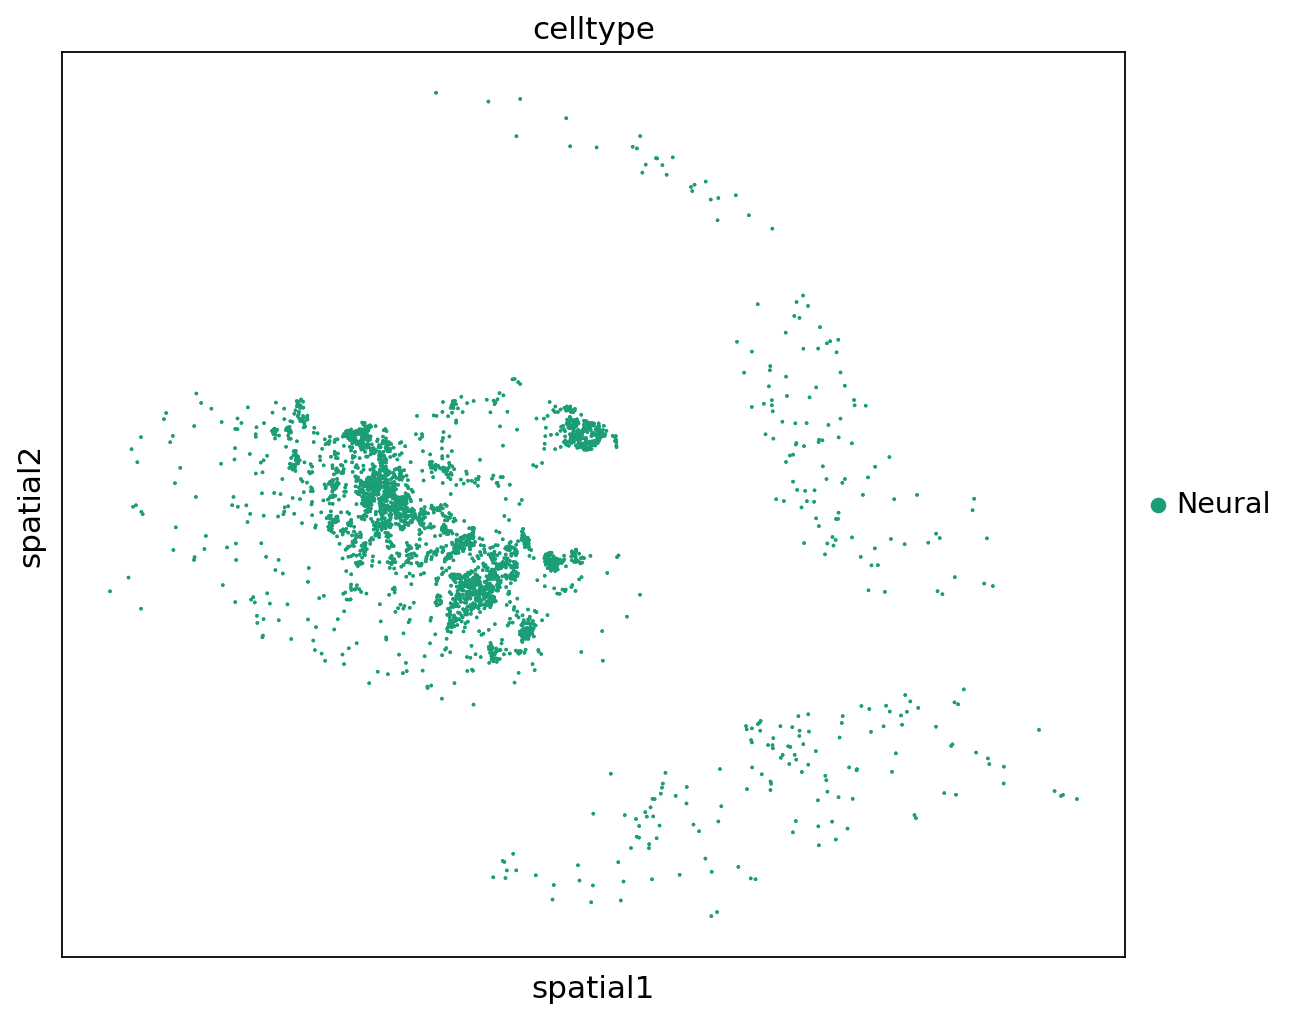

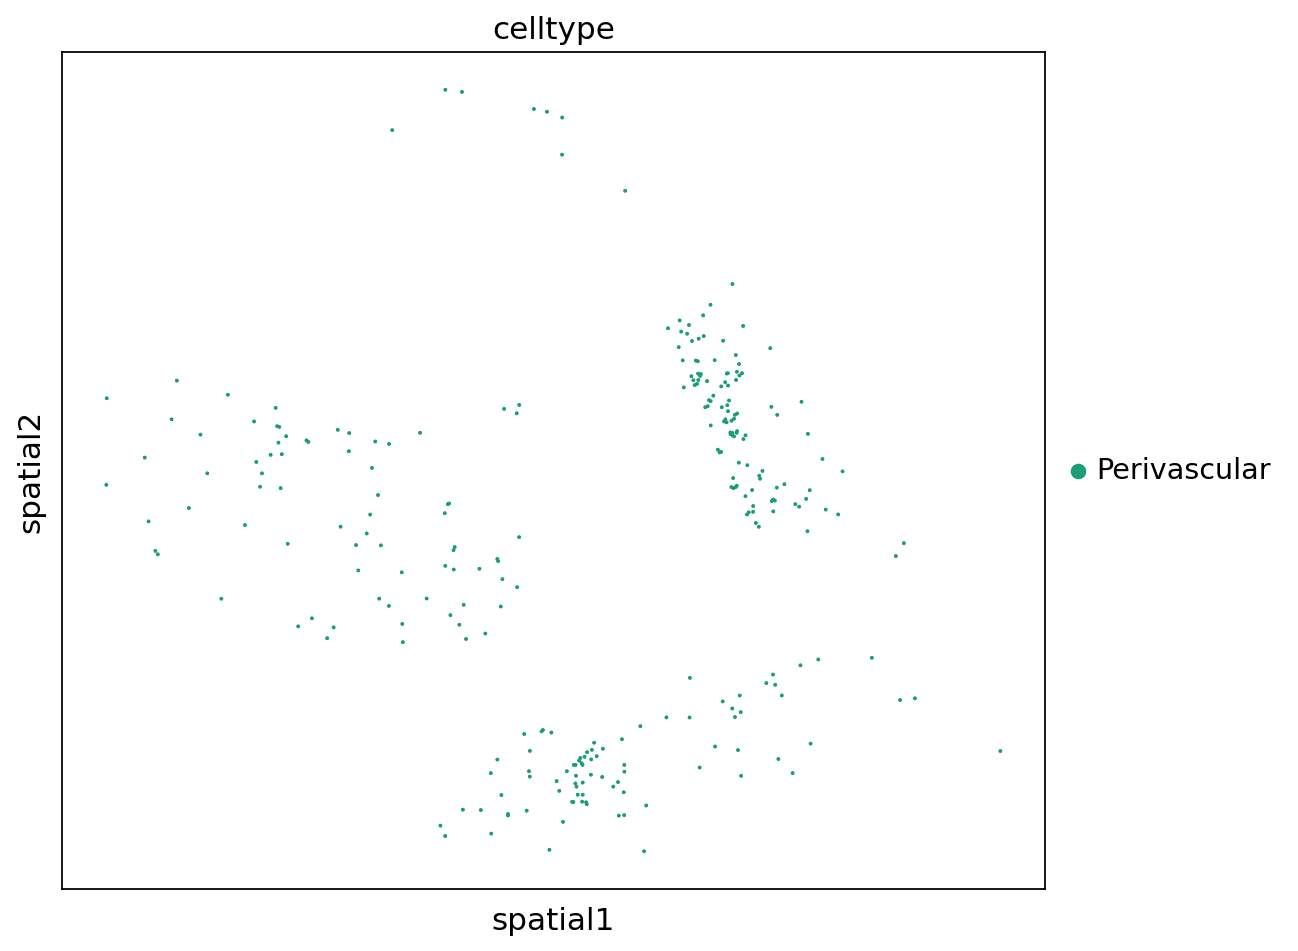

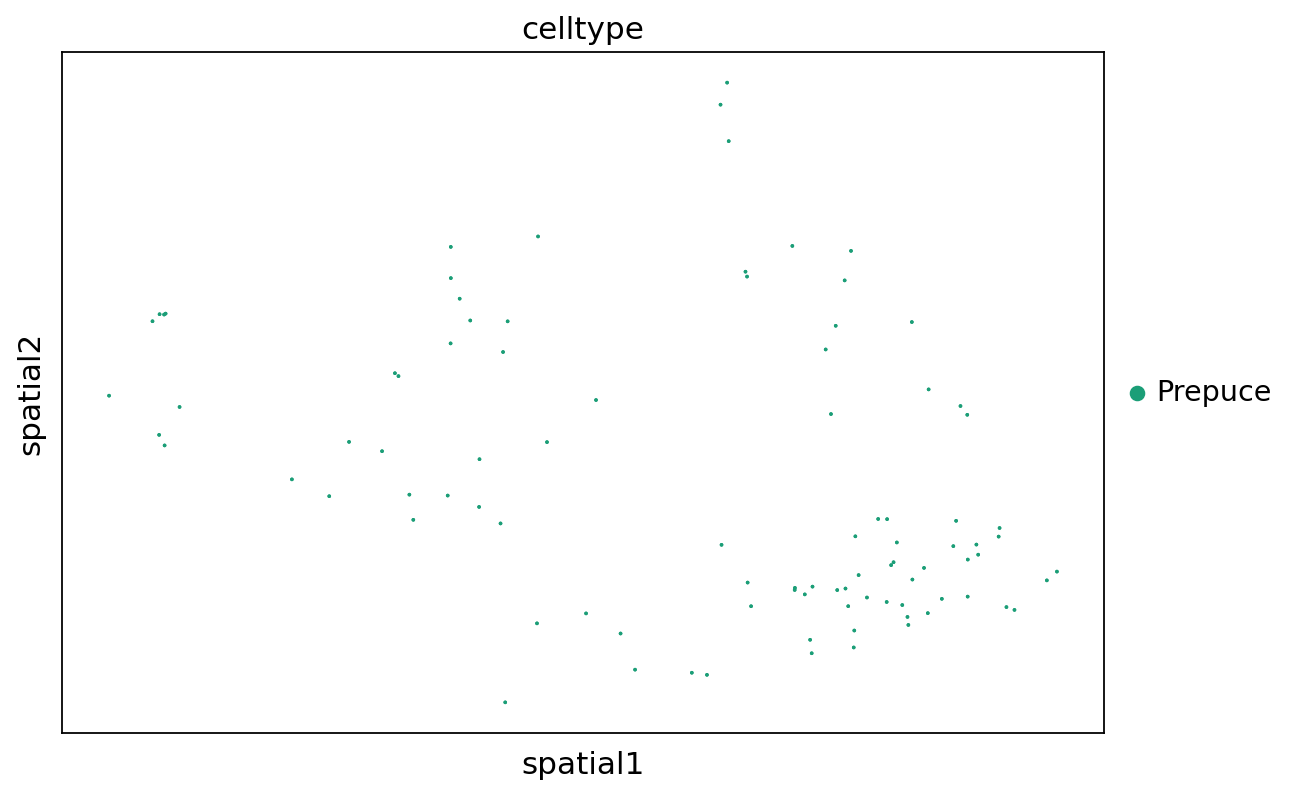

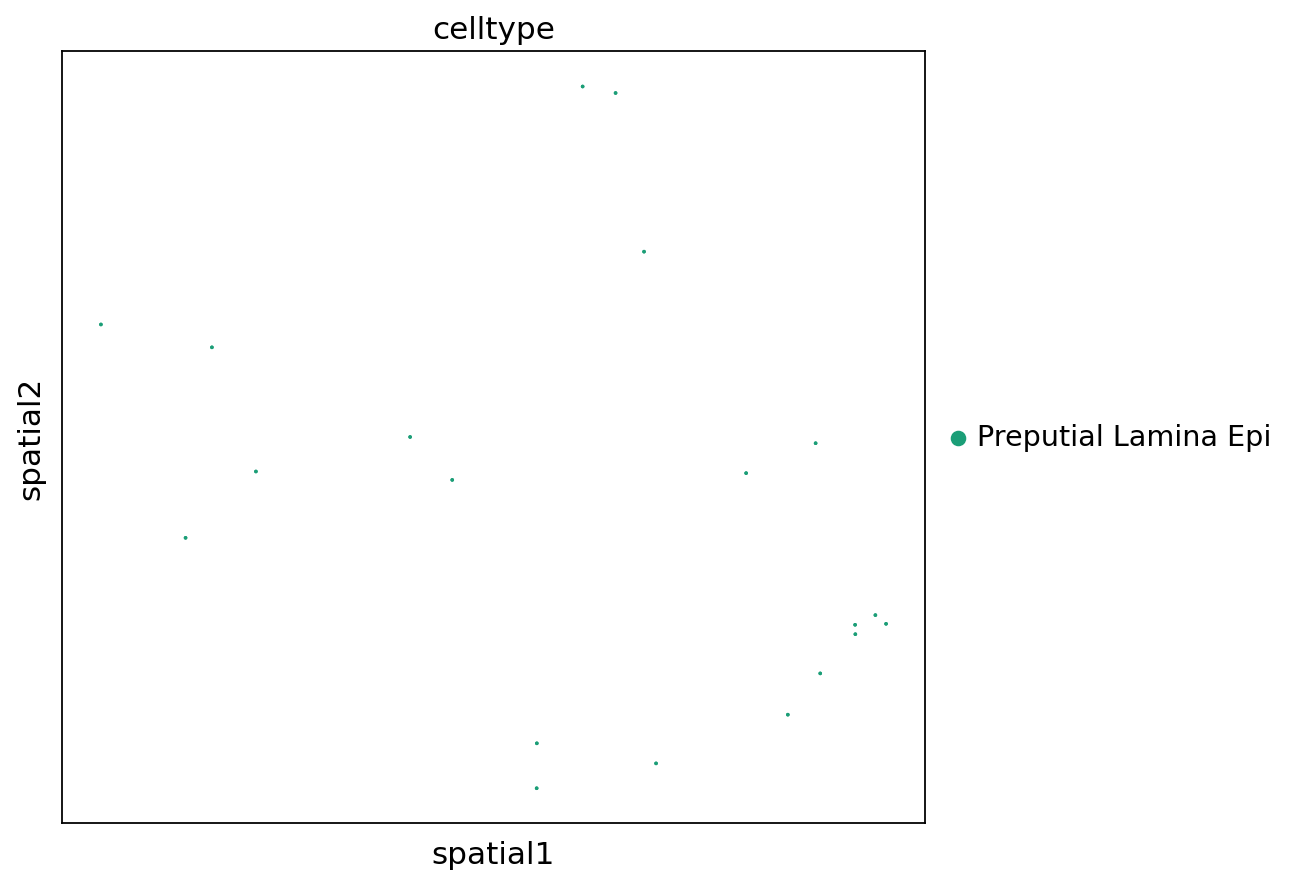

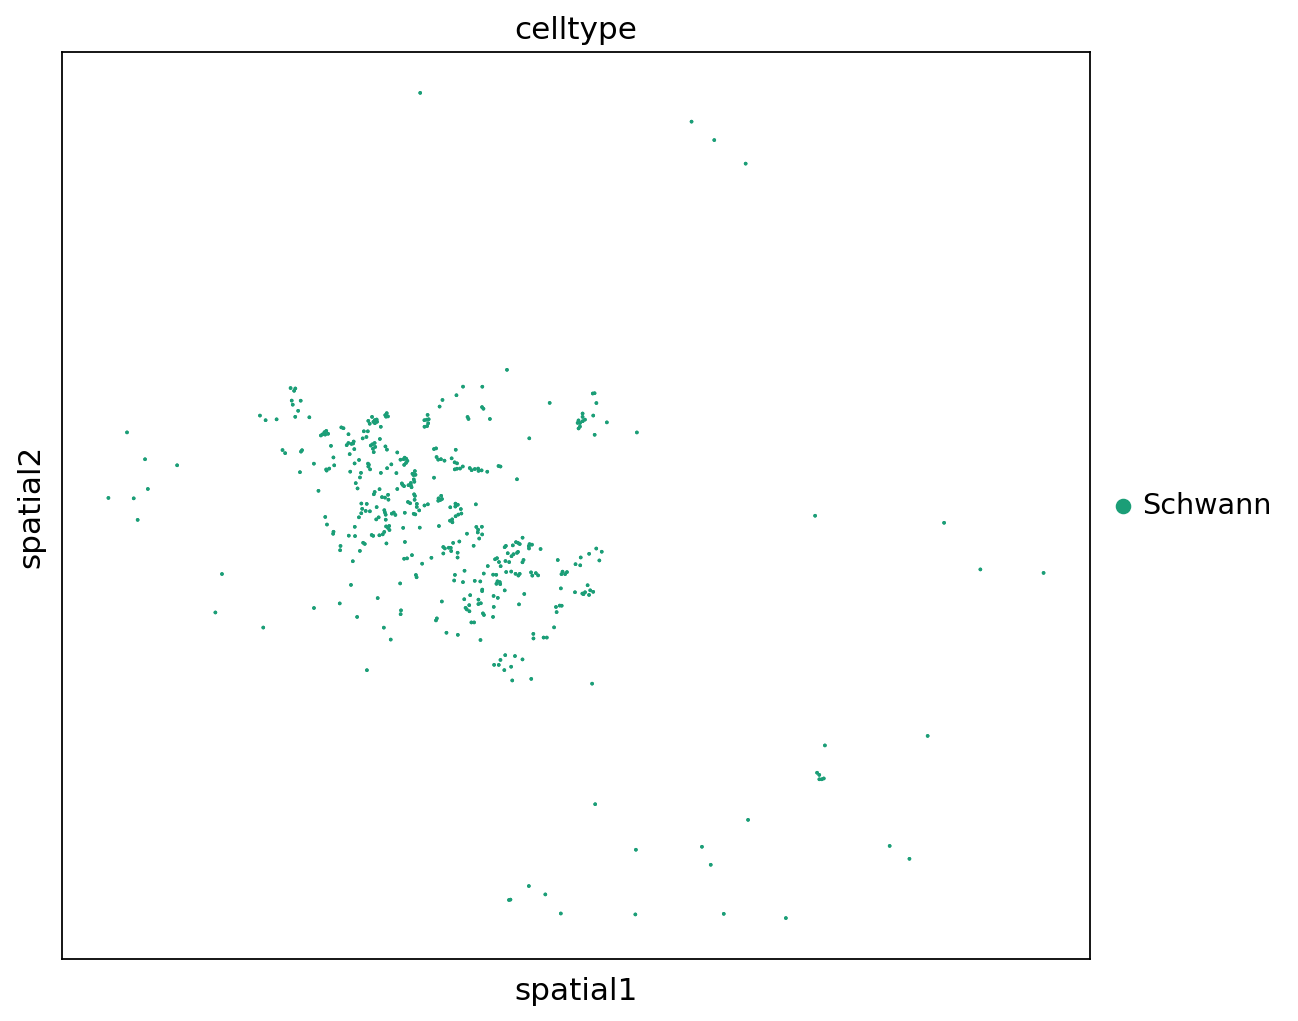

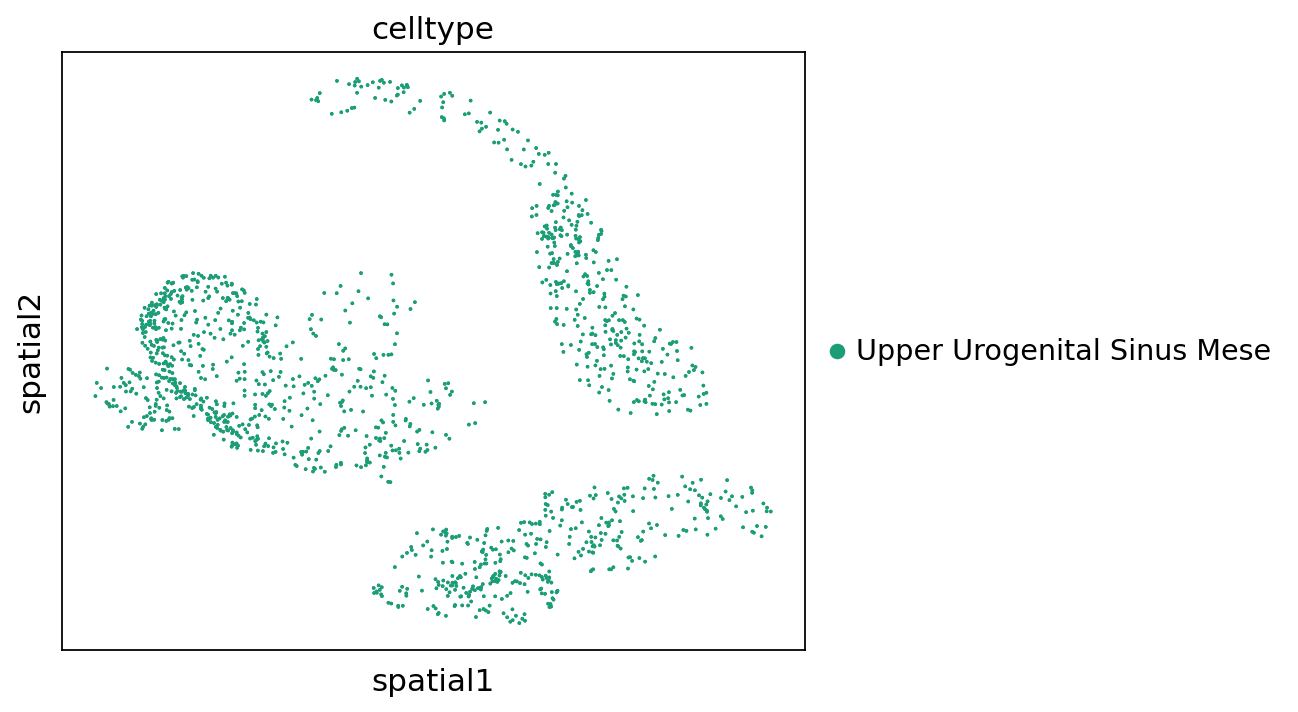

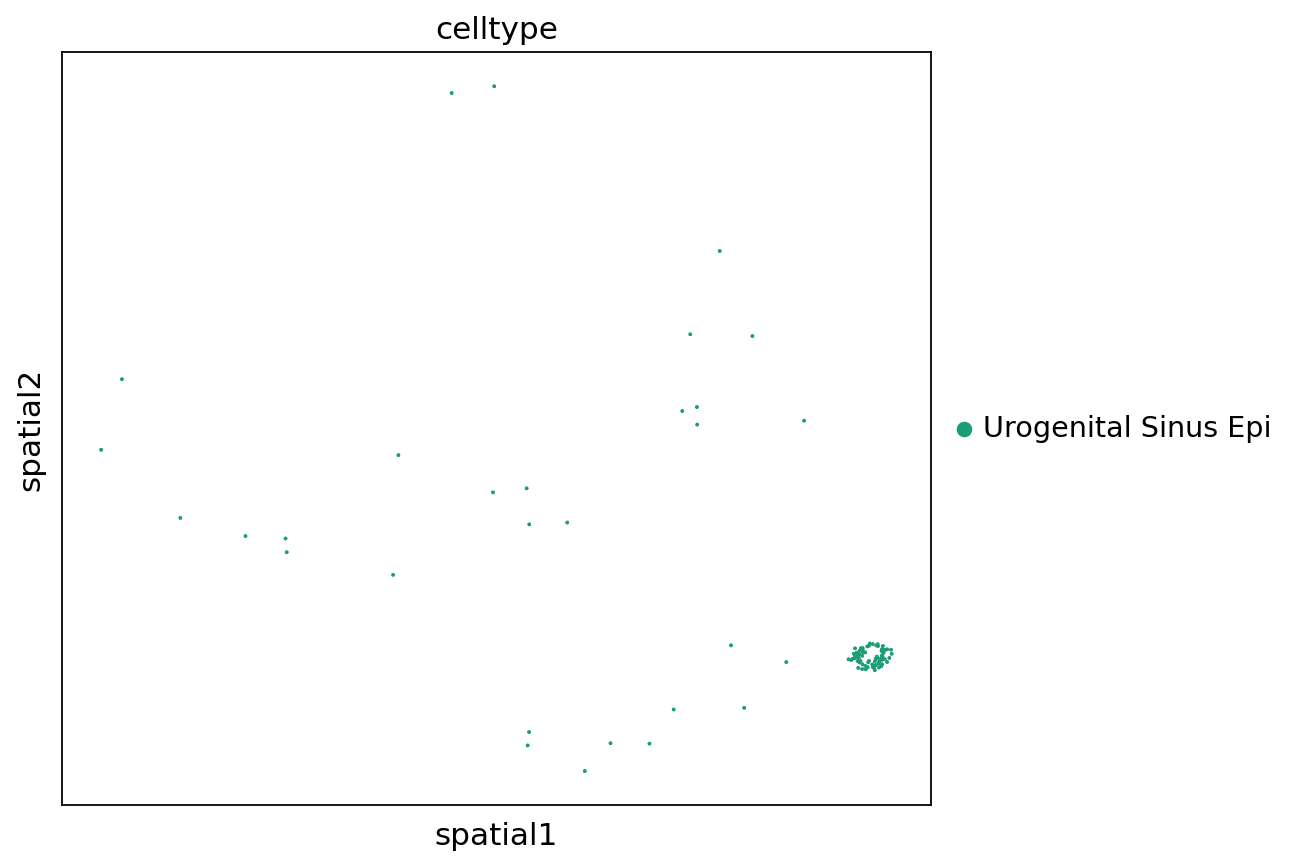

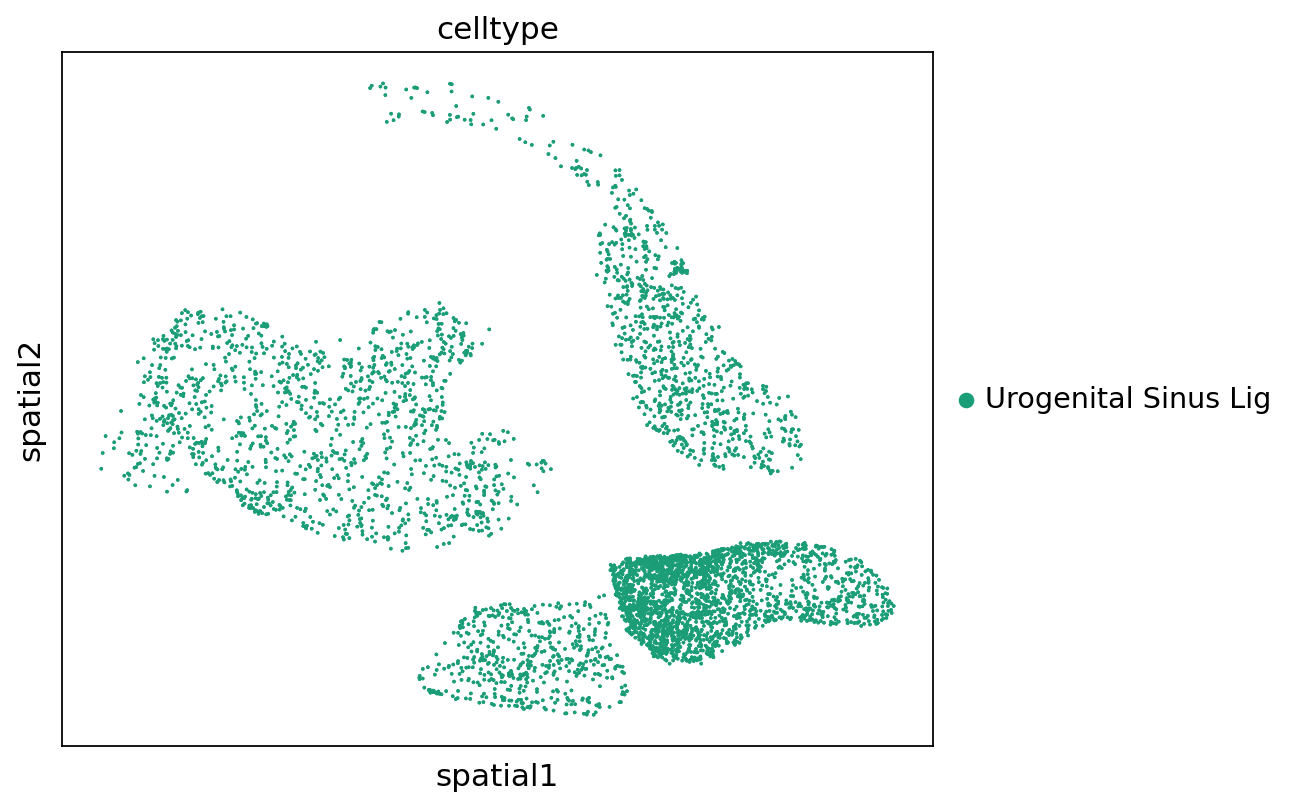

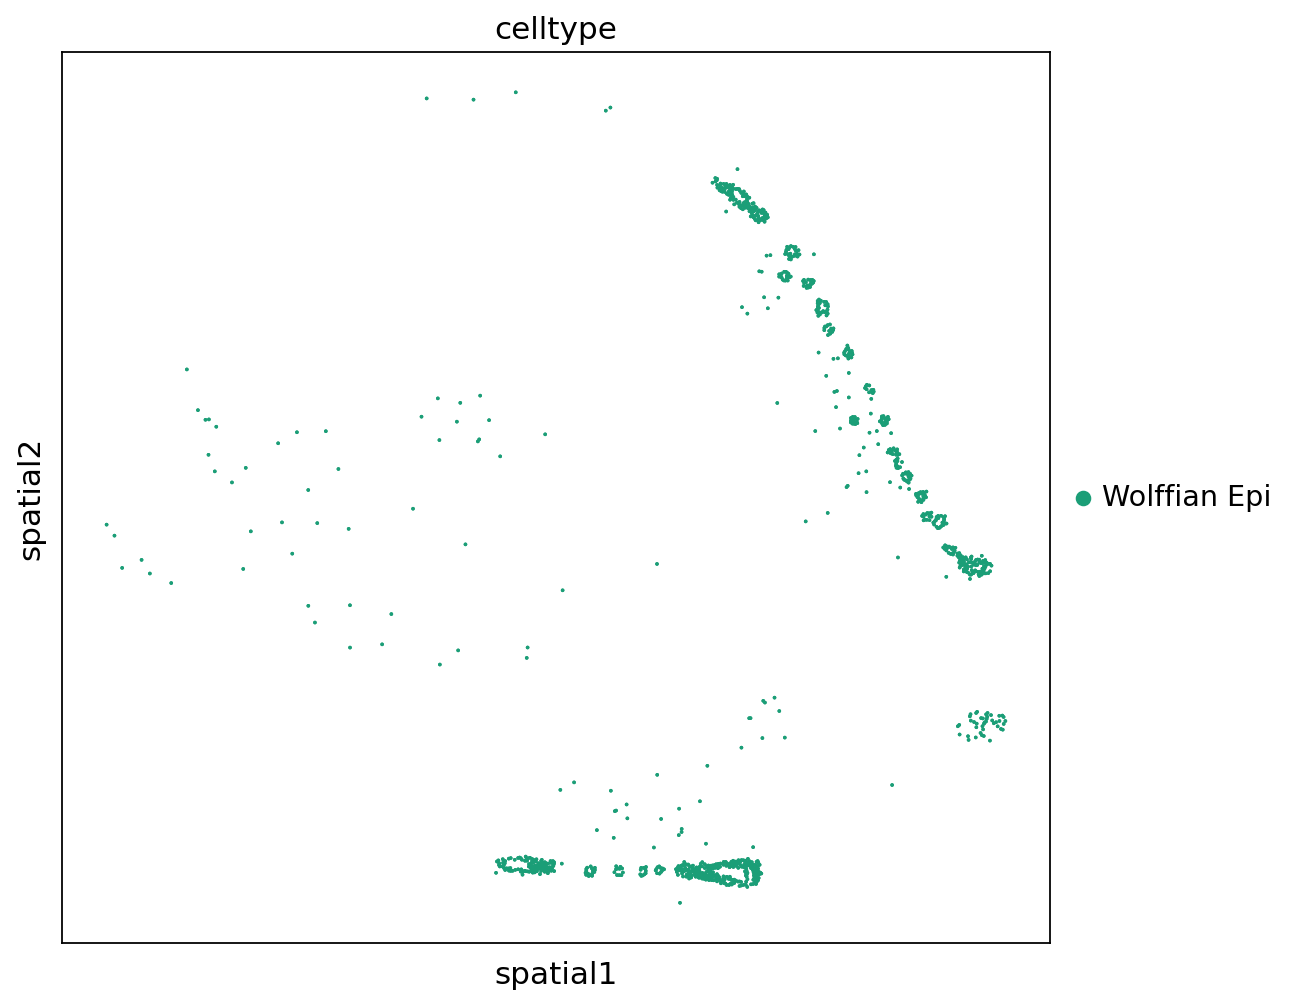

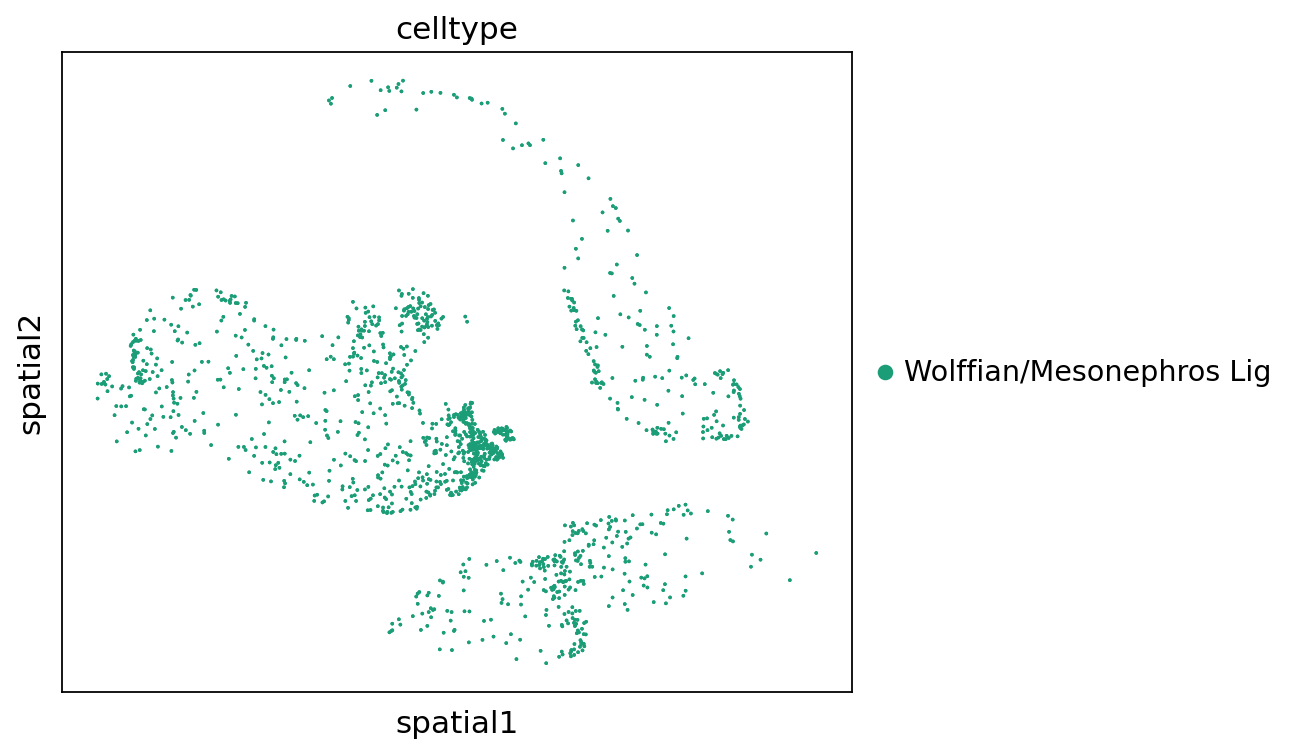

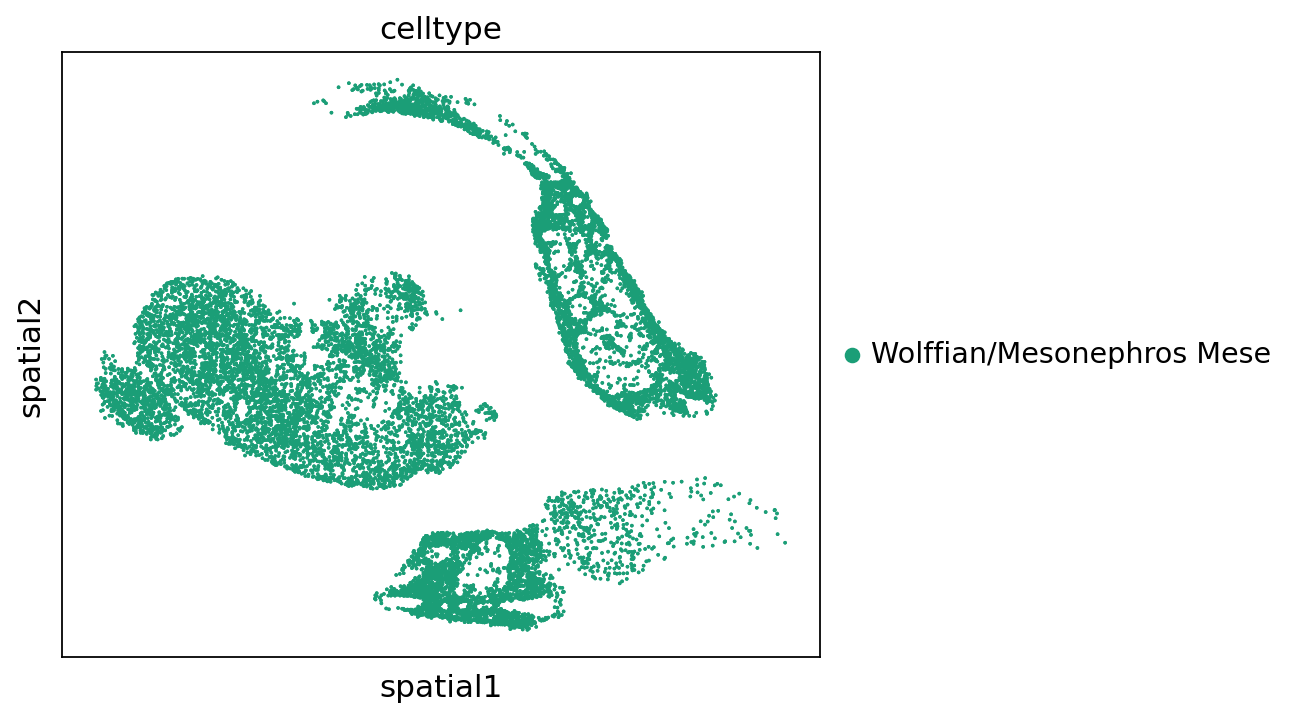

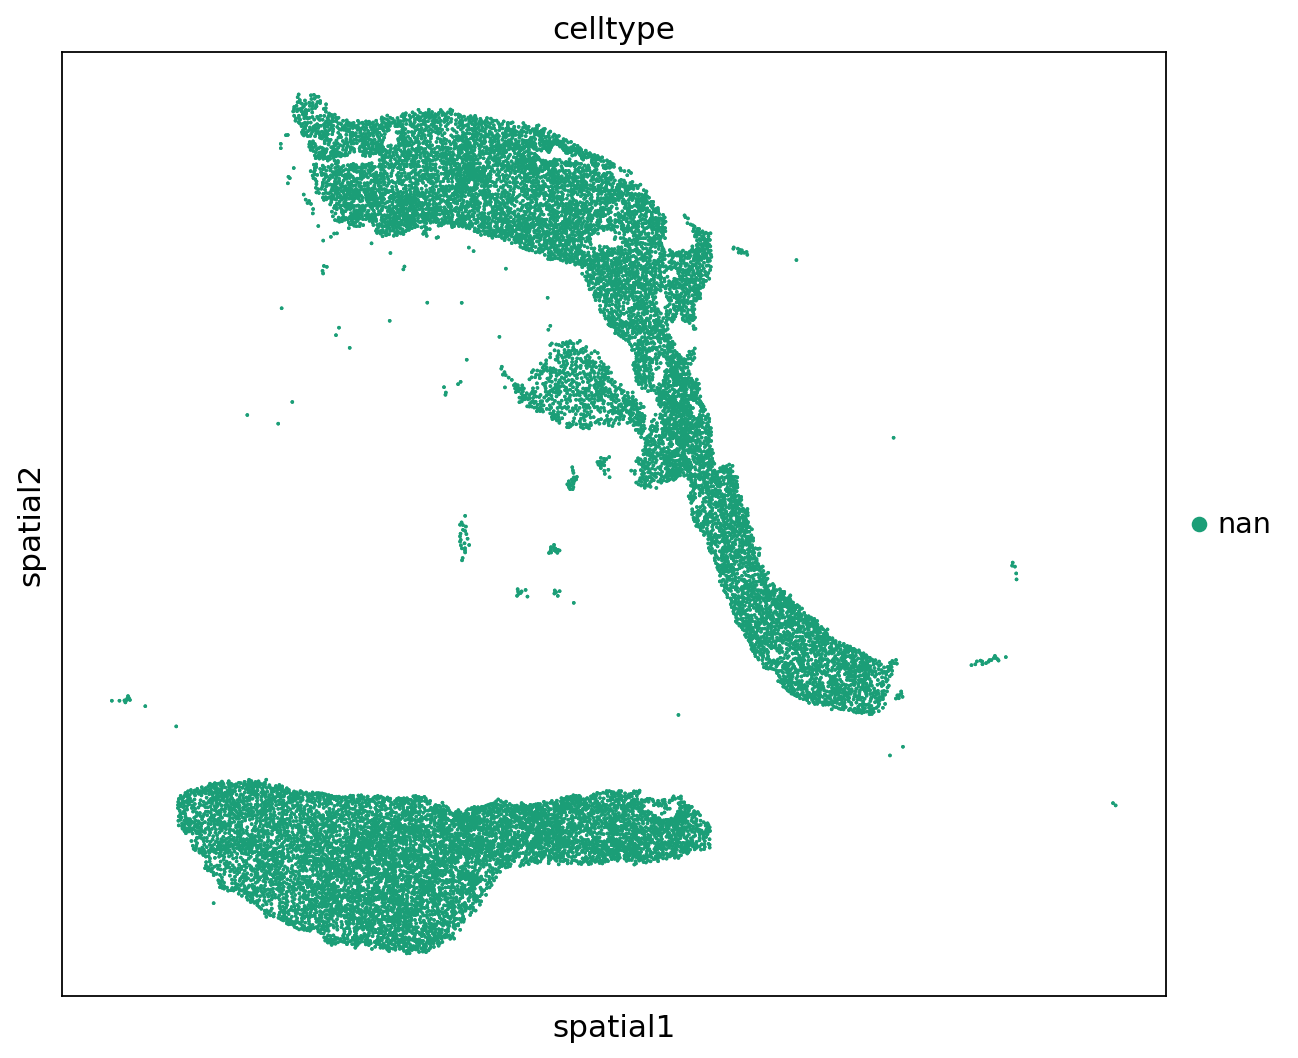

In [116]:
for i in np.unique(CM009.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM009,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [127]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Coelomic Epi',  'Müllerian Epi', 
       'Wolffian Epi', 'Urogenital Sinus Epi', 'Kidney - Ureteric Bud', 'Kidney - Loop of Henle', 'Kidney - S-Shaped Body', 
                            'Kidney - Podocyte',
                            
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM009.obs['ducts'] = CM009.obs.apply(new_column, axis=1)


In [128]:
CM009.obs['ducts'].value_counts(dropna=False)

NaN                       51233
Kidney - Podocyte          2170
Coelomic Epi               1218
Wolffian Epi                901
Kidney - Ureteric Bud       561
Kidney - S-Shaped Body      202
Kidney - Loop of Henle      170
Müllerian Epi               101
Urogenital Sinus Epi         71
Name: ducts, dtype: int64

In [129]:
CM009.obs['ducts'] = CM009.obs['ducts'].astype(str)
CM009.obs['ducts'] = CM009.obs['ducts'].astype('category')
CM009.obs['ducts'] = CM009.obs['ducts'].cat.reorder_categories([
    'Coelomic Epi',  'Müllerian Epi', 
       'Wolffian Epi', 'Urogenital Sinus Epi', 'Kidney - Ureteric Bud', 'Kidney - Loop of Henle', 'Kidney - S-Shaped Body', 
                            'Kidney - Podocyte', 'nan'
])


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


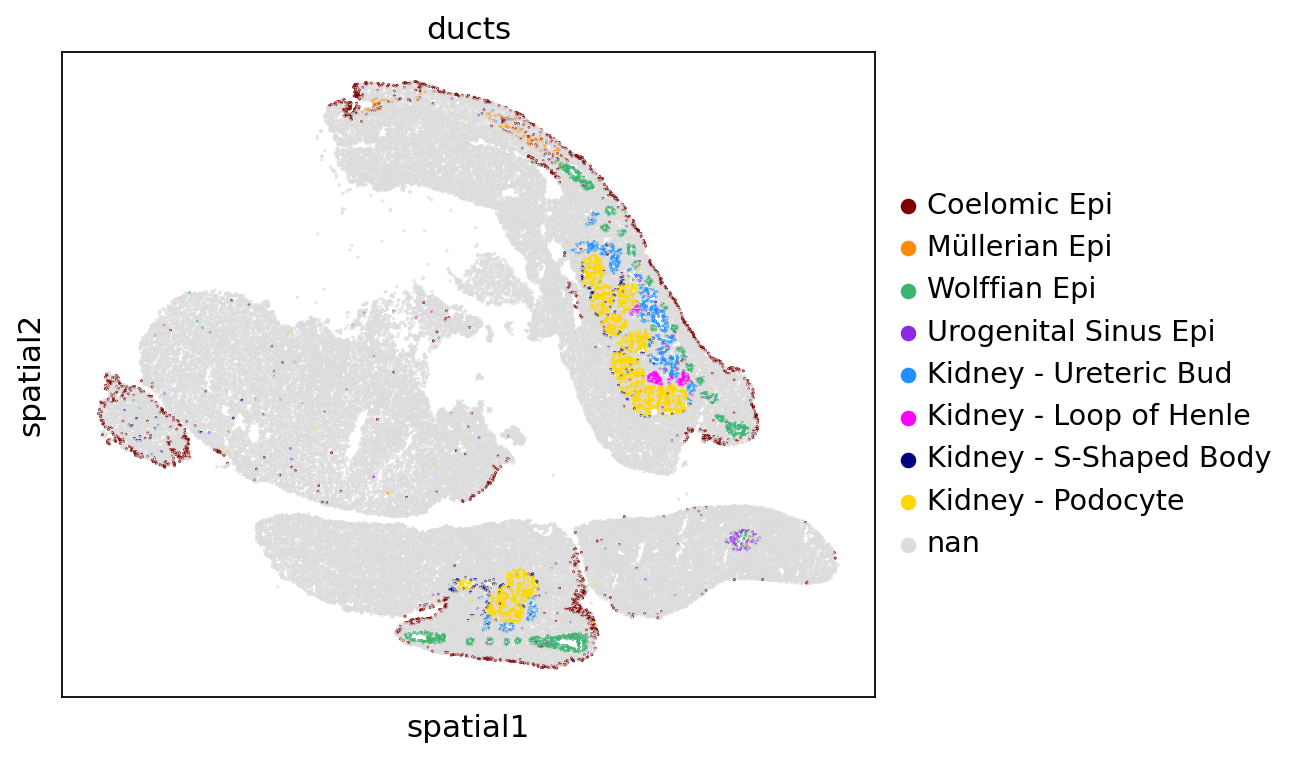

In [140]:
sq.pl.spatial_scatter(
    CM009,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=0.2,
    cmap = 'jet',
    figsize=(8,8), 
#            legend_loc = 'right margin',
#                              palette= {'Coelomic Epi' : 'maroon',  'Müllerian Epi' : 'darkorange', 
#                     'Wolffian Epi' : 'mediumseagreen',  'Urogenital Sinus Epi' : 'blueviolet',
#                                        'Kidney - Podocyte' : 'gold', 'Kidney - Loop of Henle' : 'magenta',
#                                        'Kidney - Ureteric Bud' : 'dodgerblue', 
#                                        'Kidney - S-Shaped Body' : 'navy',
#                 'nan' : 'gainsboro'
#                                       },
    save = 'CM009_ducts_filtered.pdf'
)

In [138]:
CM009.obs['broad_anatomy'].value_counts()

Adrenal            16139
Gonad              15308
Nephros            10549
UrogenitalSinus     7250
Ducts               7186
Background           105
Unassigned            90
Name: broad_anatomy, dtype: int64

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


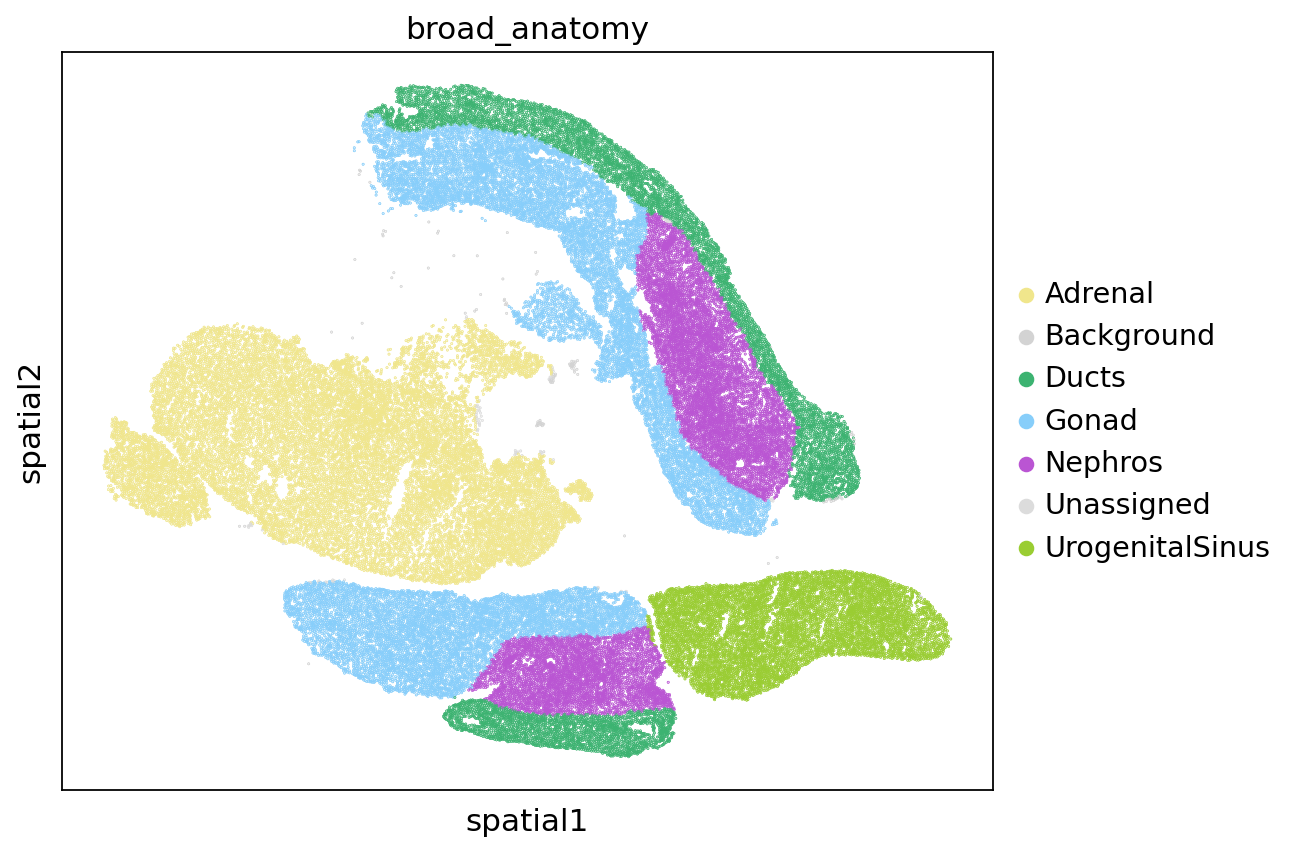

In [154]:
sq.pl.spatial_scatter(
    CM009,
    spatial_key="spatial",
    color=['broad_anatomy'],
    shape=None,
    use_raw = False,
    size=0.2,
    cmap = 'jet',
    figsize=(8,8), 
#            legend_loc = 'right margin',
#                              palette= {'Ducts' : 'mediumseagreen',  'UrogenitalSinus' : 'yellowgreen', 
#                     'Genital Tubercle' : 'burlywood',  
#                                        'Adrenal' : 'khaki', 
#                                        'Nephros' : 'mediumorchid', 
#                                        'Gonad' : 'lightskyblue', 
#                 'Unassigned' : 'gainsboro', 'Background' : 'lightgrey',
#                                       },
    save = 'CM009_ducts_anatomy.pdf'
)

## CM007

Adrenal Cortex
Coelomic Epi
Corpus Cavernosum
Corpus Spongiosum
Endothelial
Glans
Kidney - Loop of Henle
Kidney - Mese Progenitor
Kidney - Podocyte
Kidney - S-Shaped Body
Kidney - Ureteric Bud


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Labio-Scrotal Swelling
Lower Urogenital Sinus Mese
Müllerian Epi
Müllerian Mese
Neural
Perivascular
Prepuce
Preputial Lamina Epi
Schwann
Upper Urogenital Sinus Mese


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

Urogenital Sinus Epi
Urogenital Sinus Lig
Wolffian Epi
Wolffian/Mesonephros Lig
Wolffian/Mesonephros Mese
nan


/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

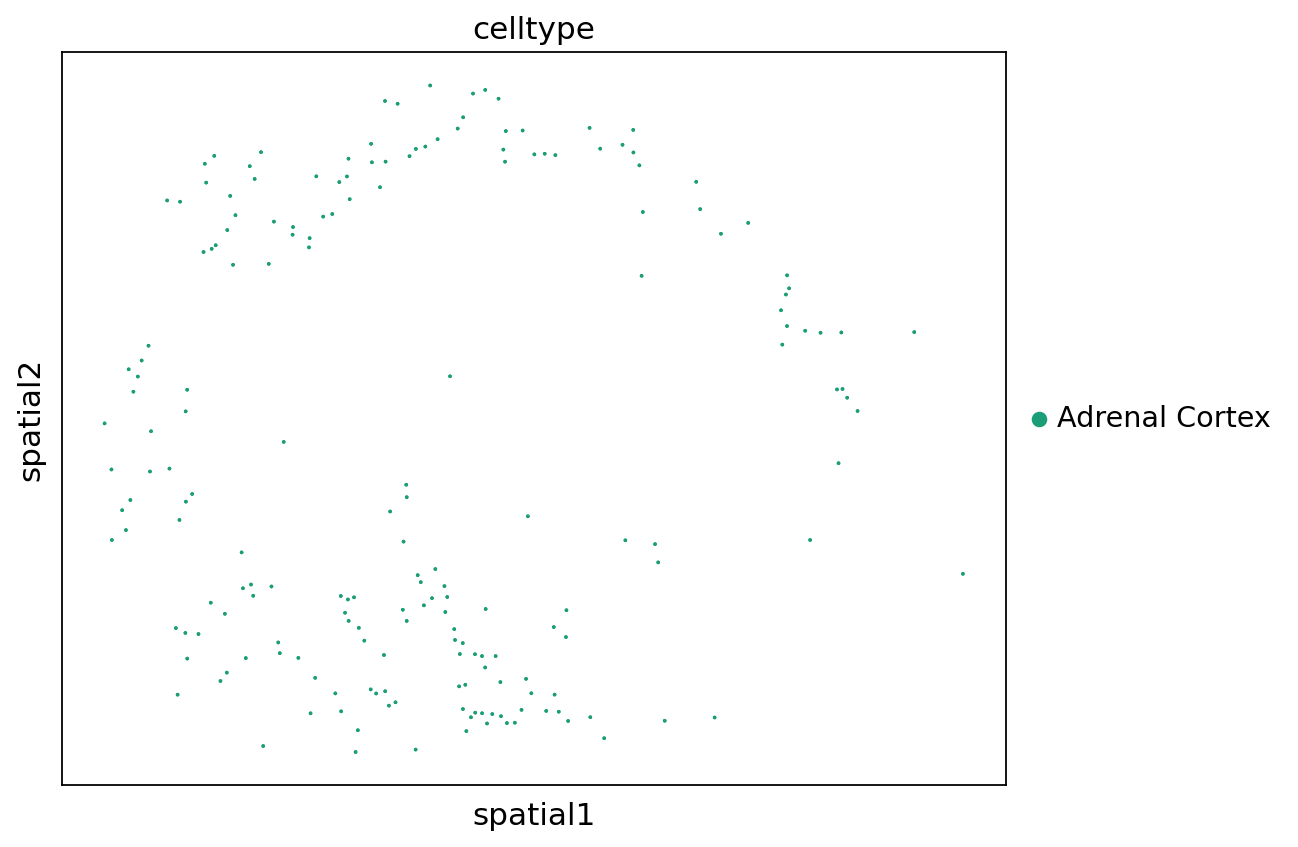

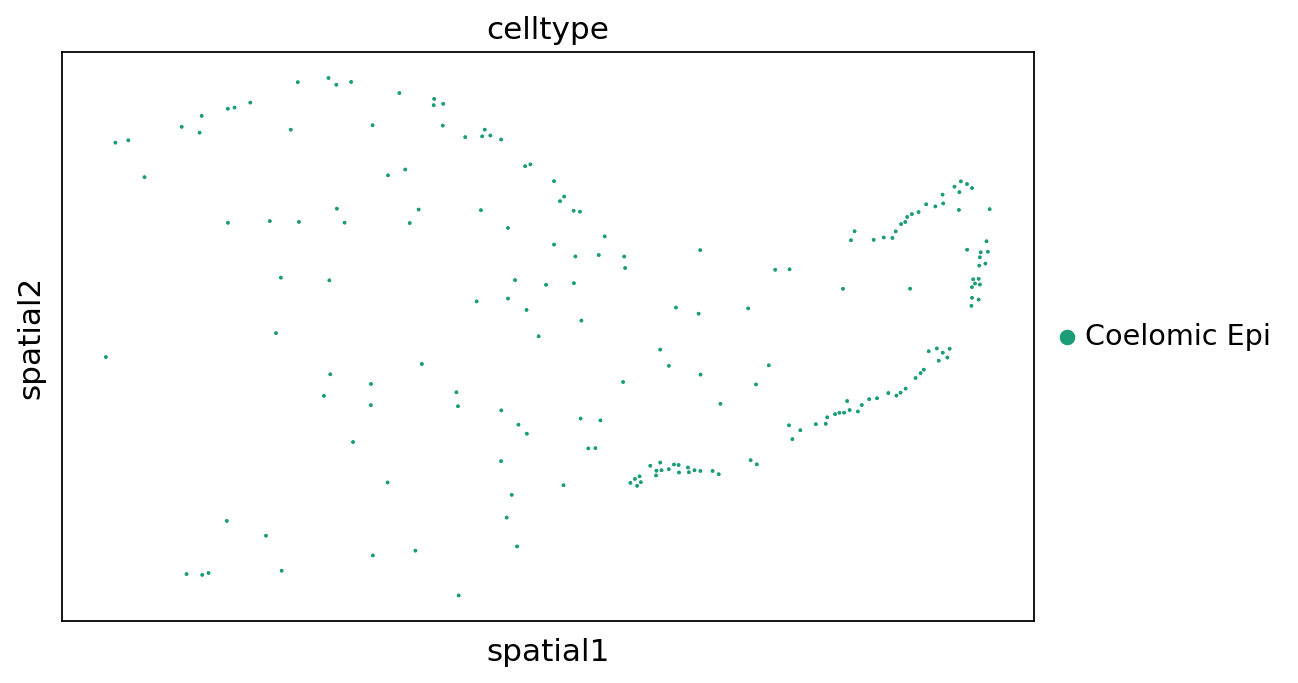

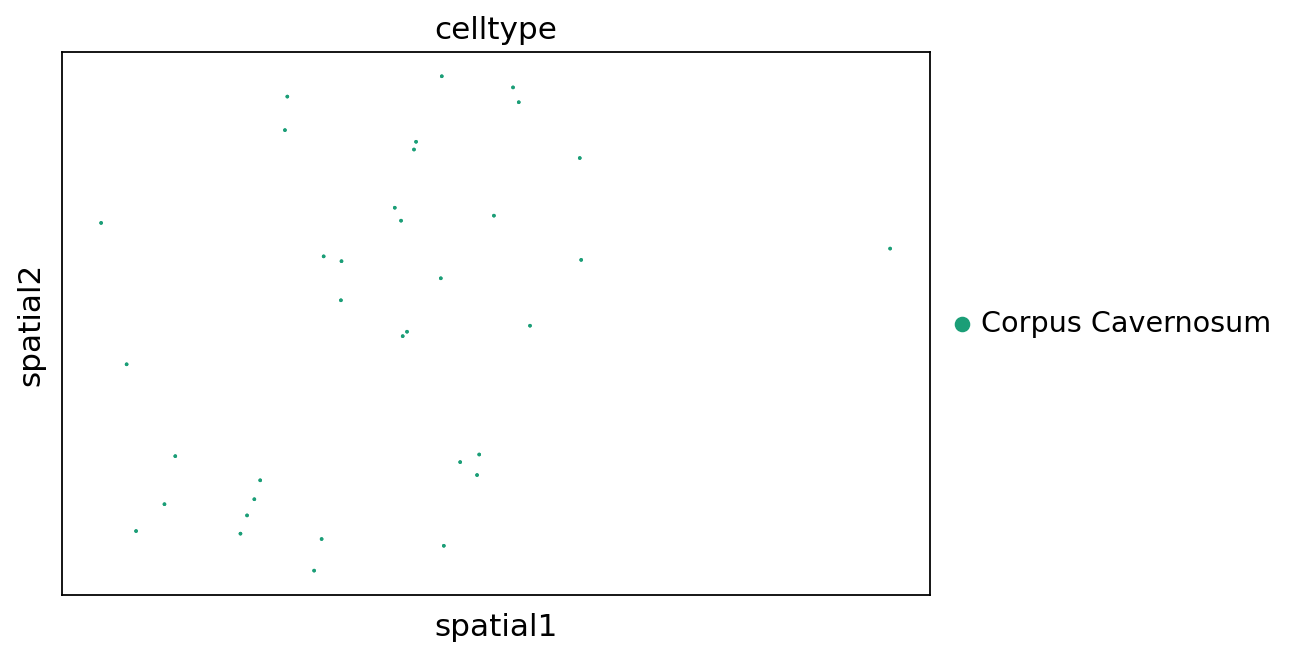

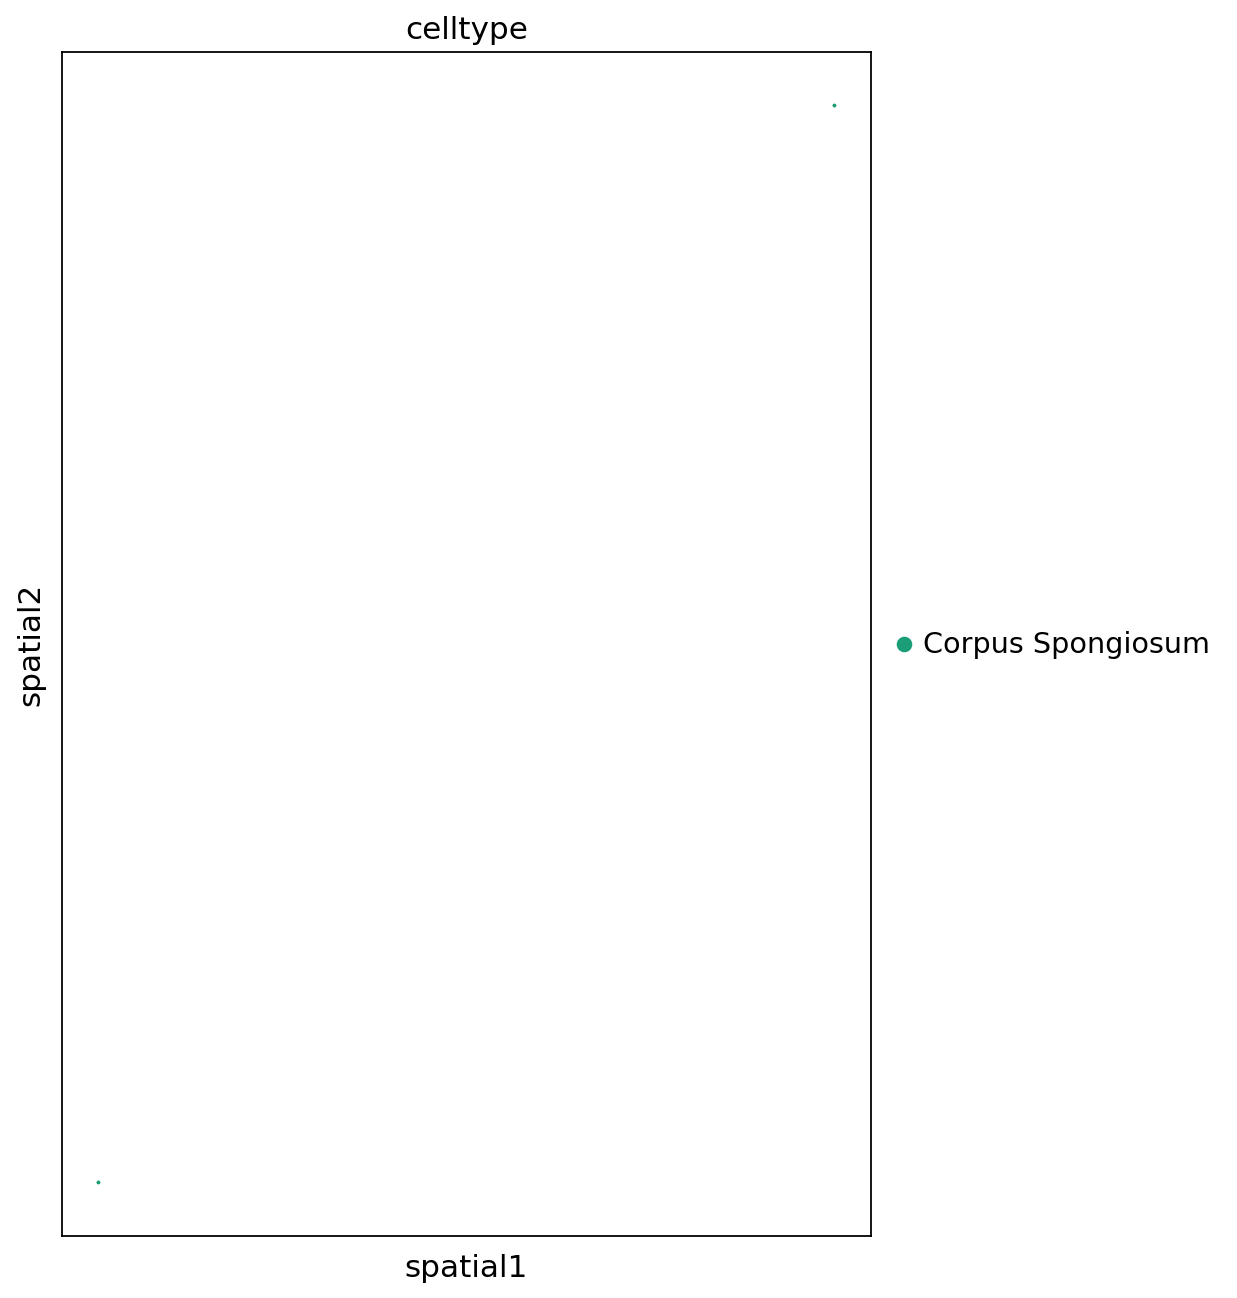

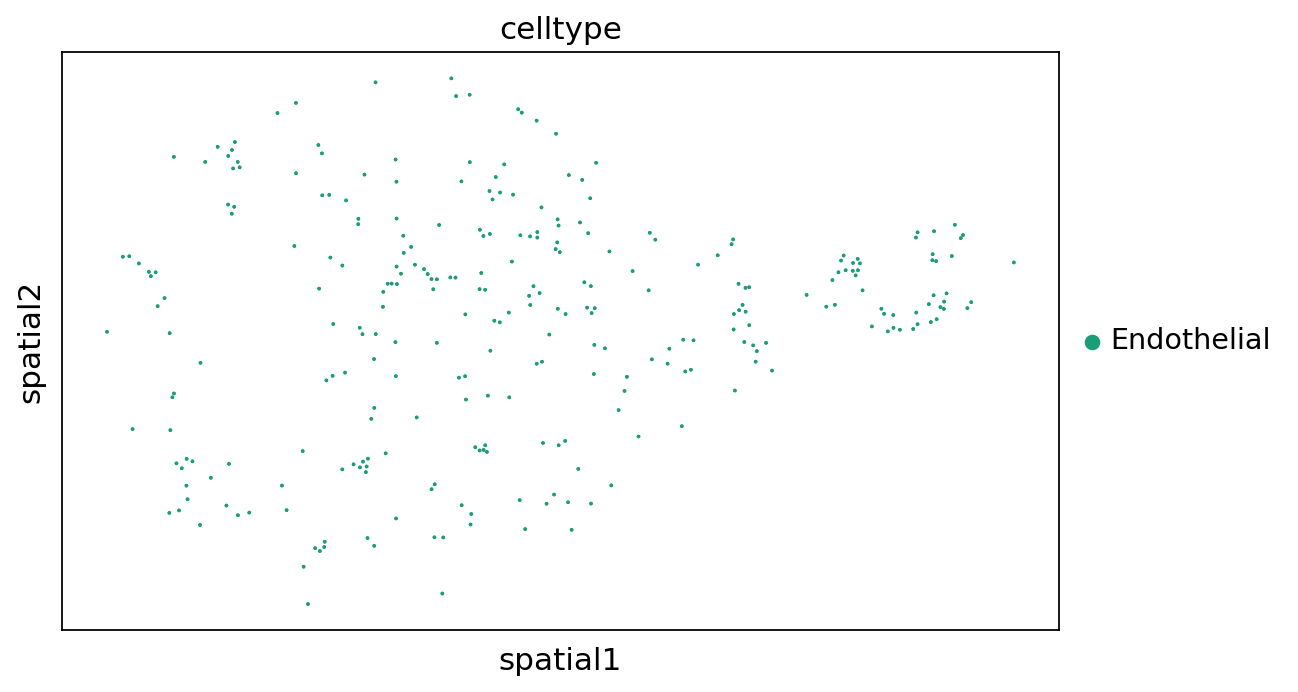

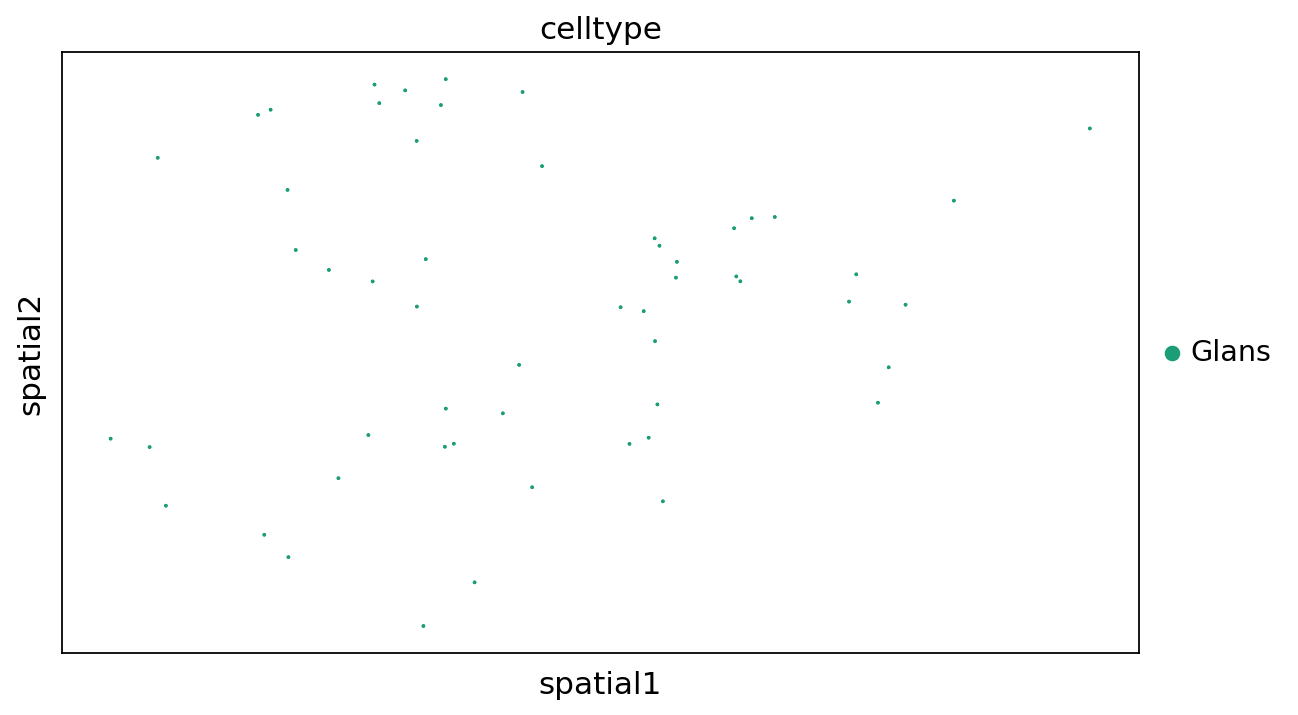

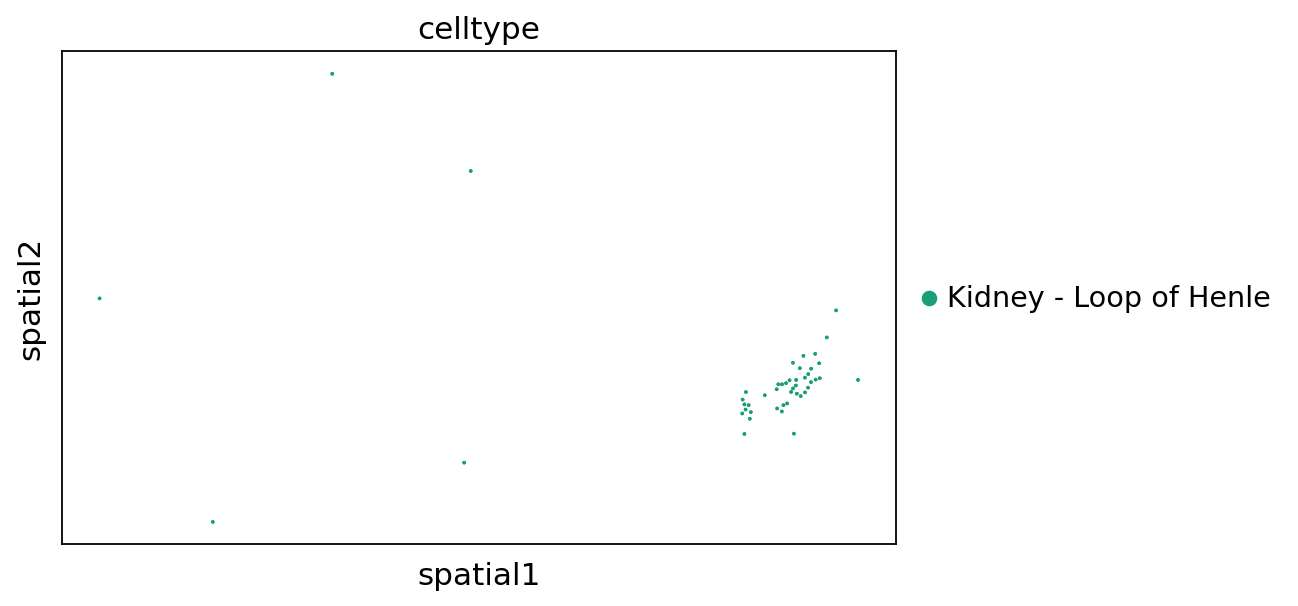

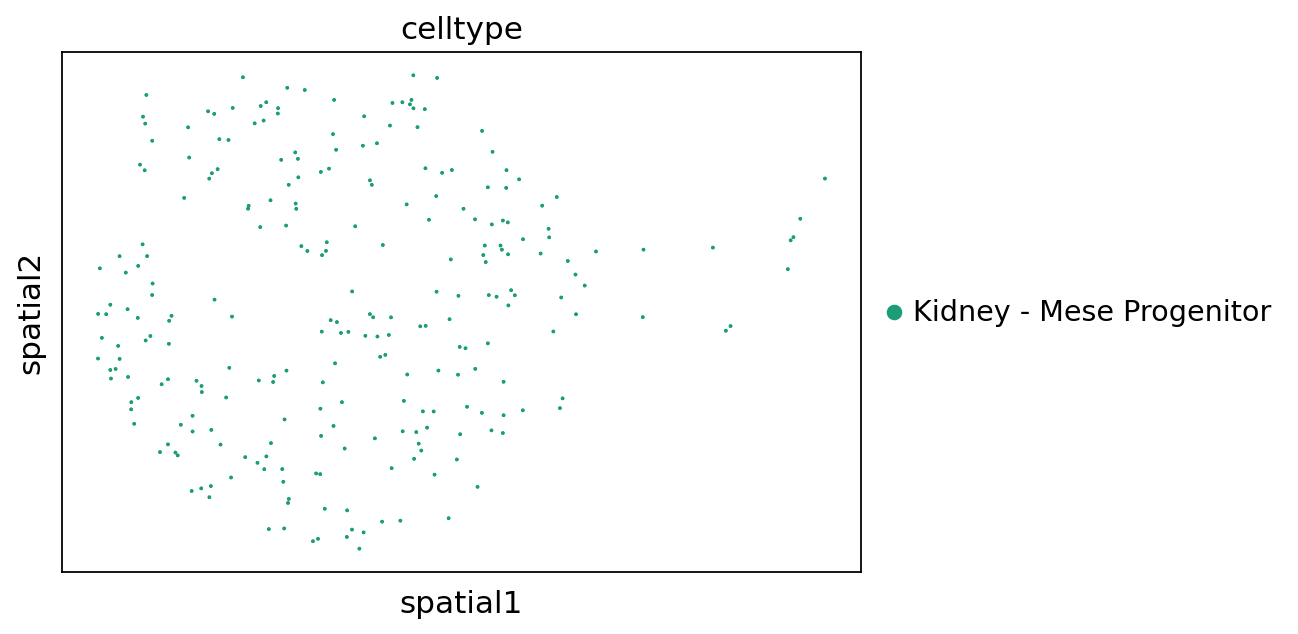

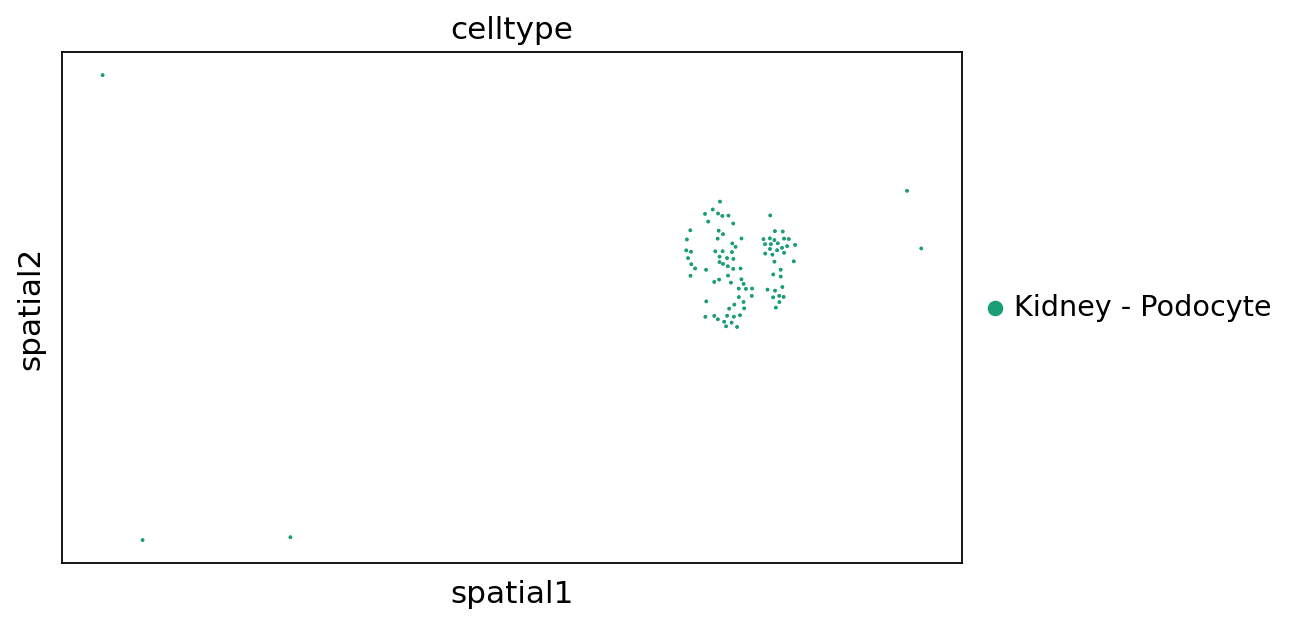

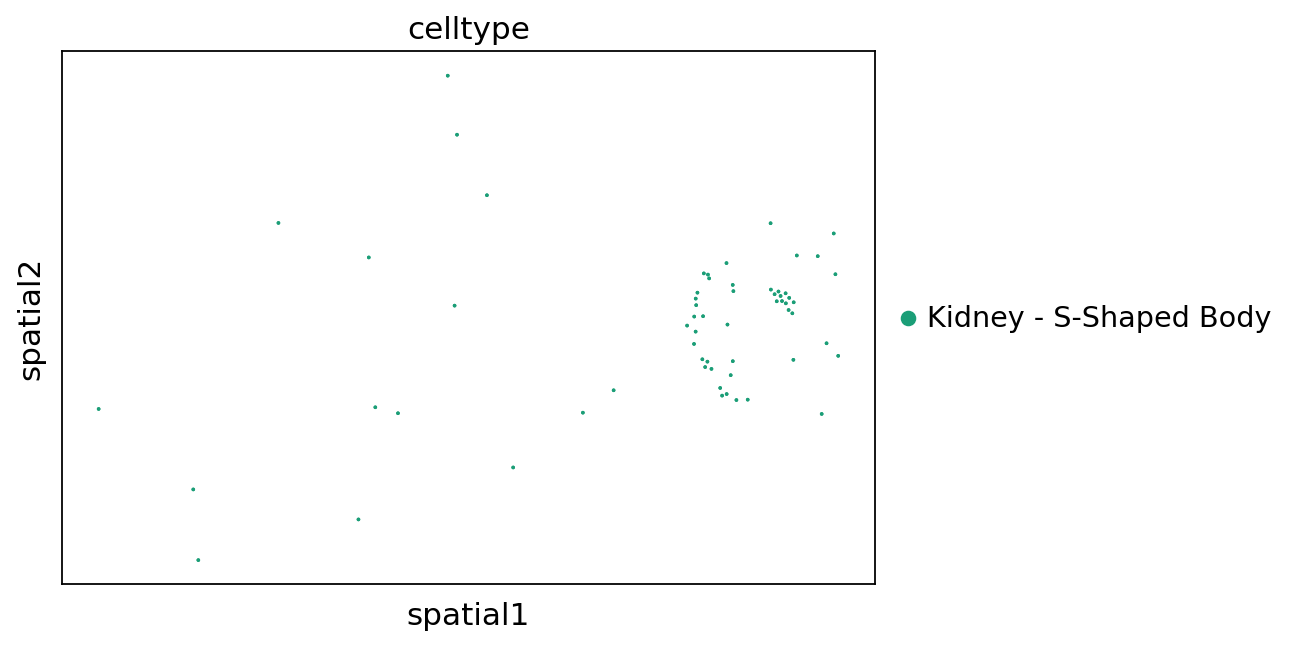

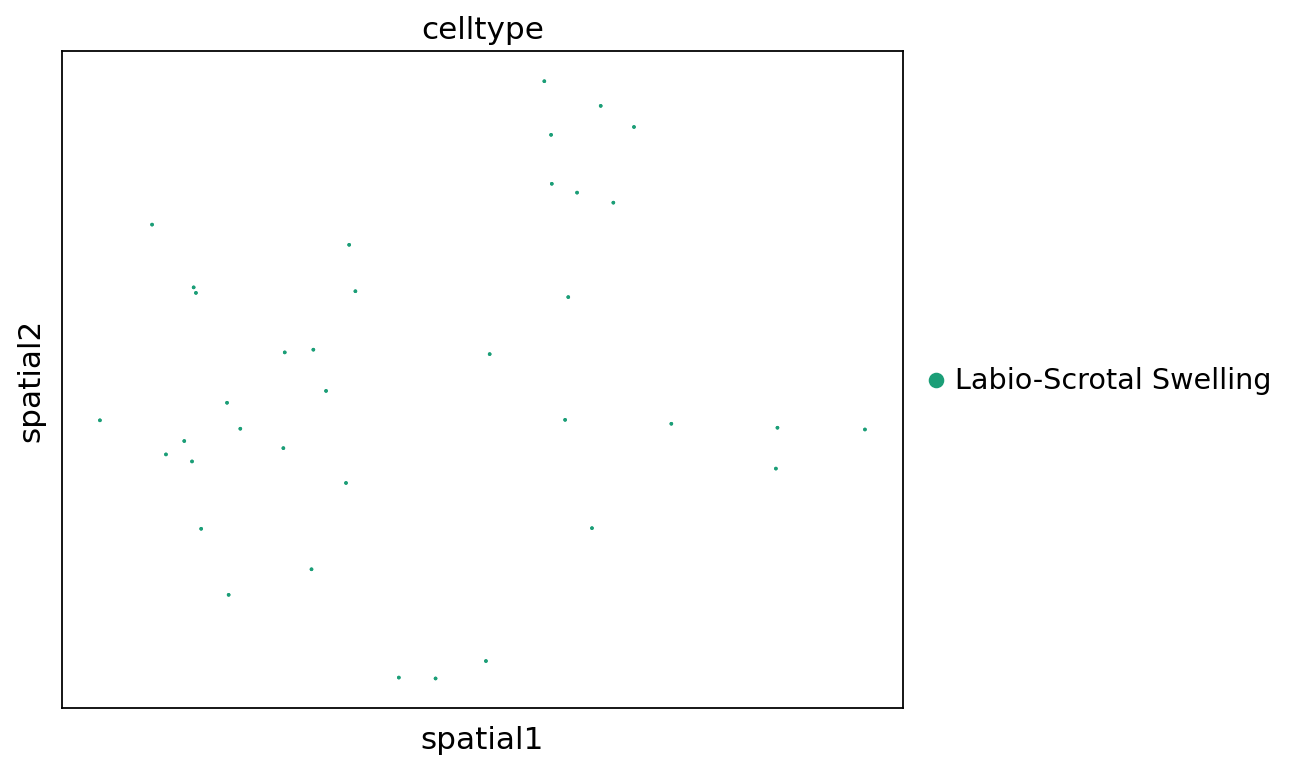

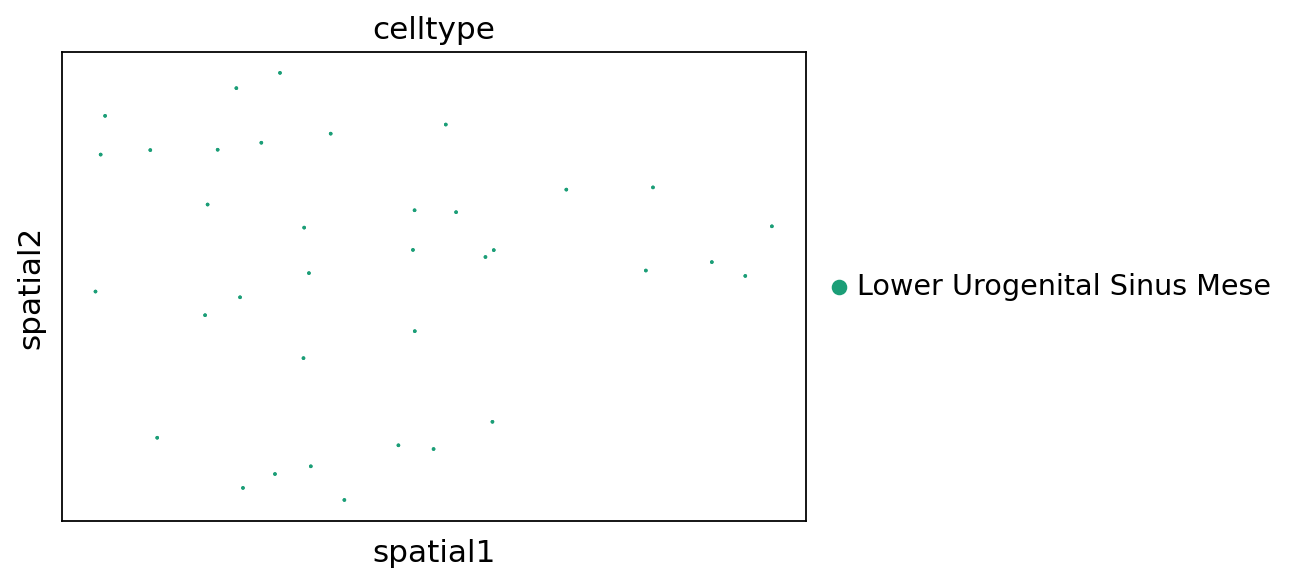

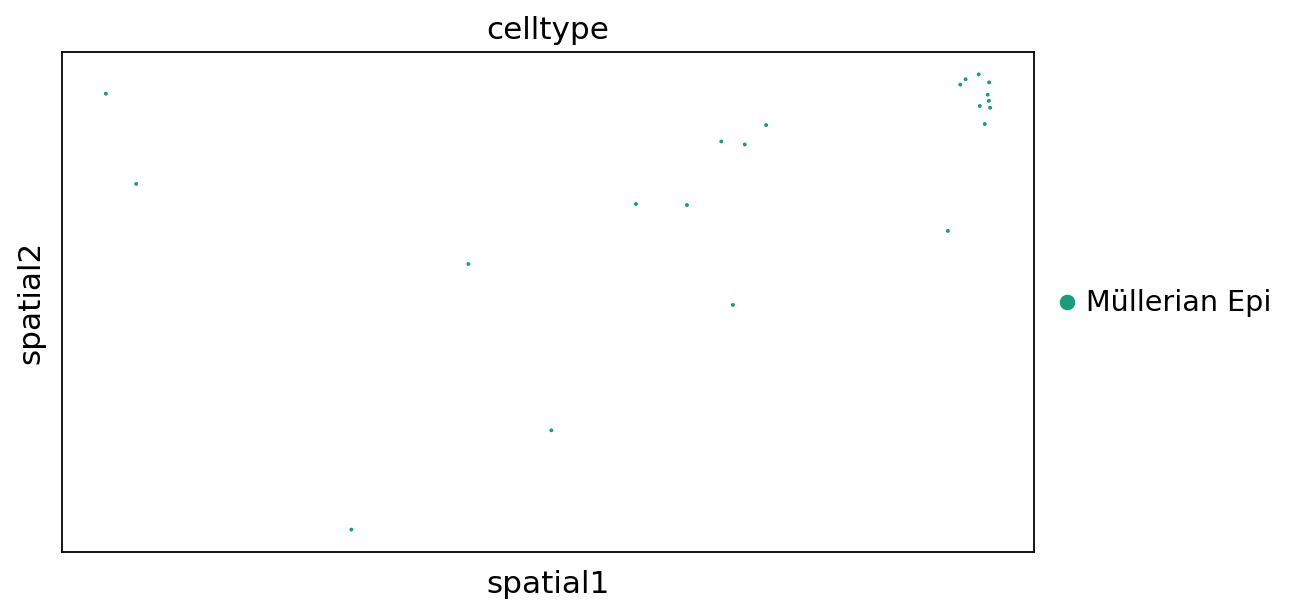

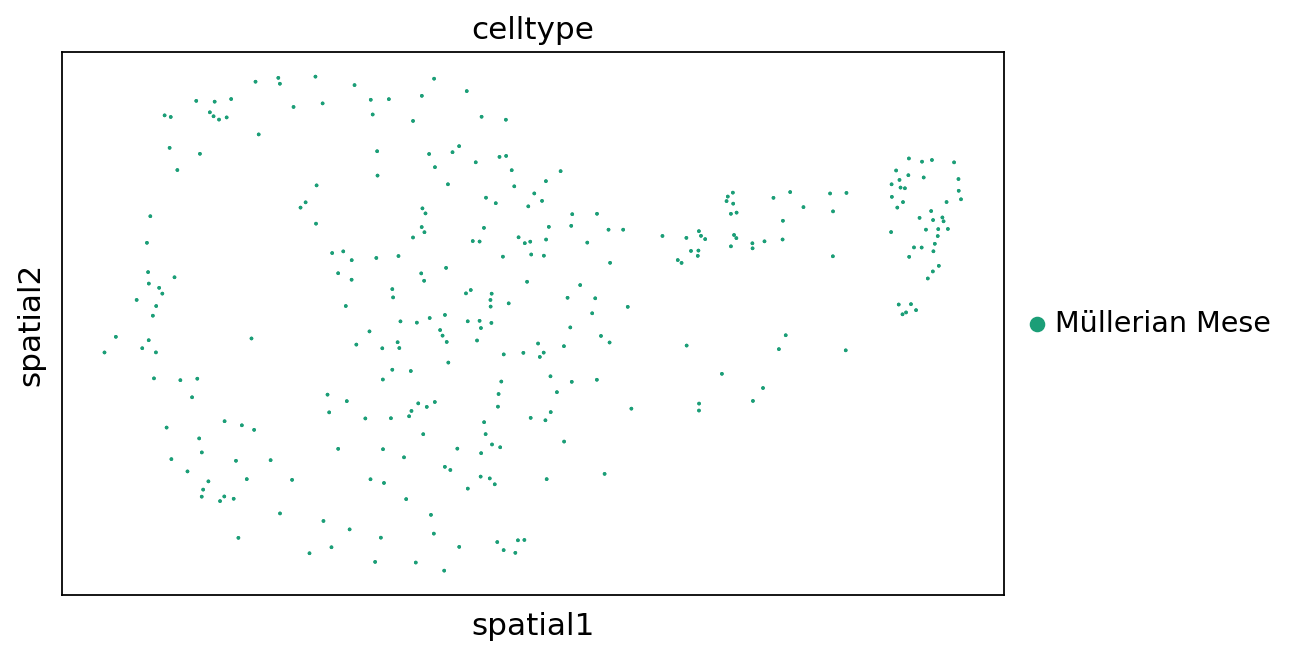

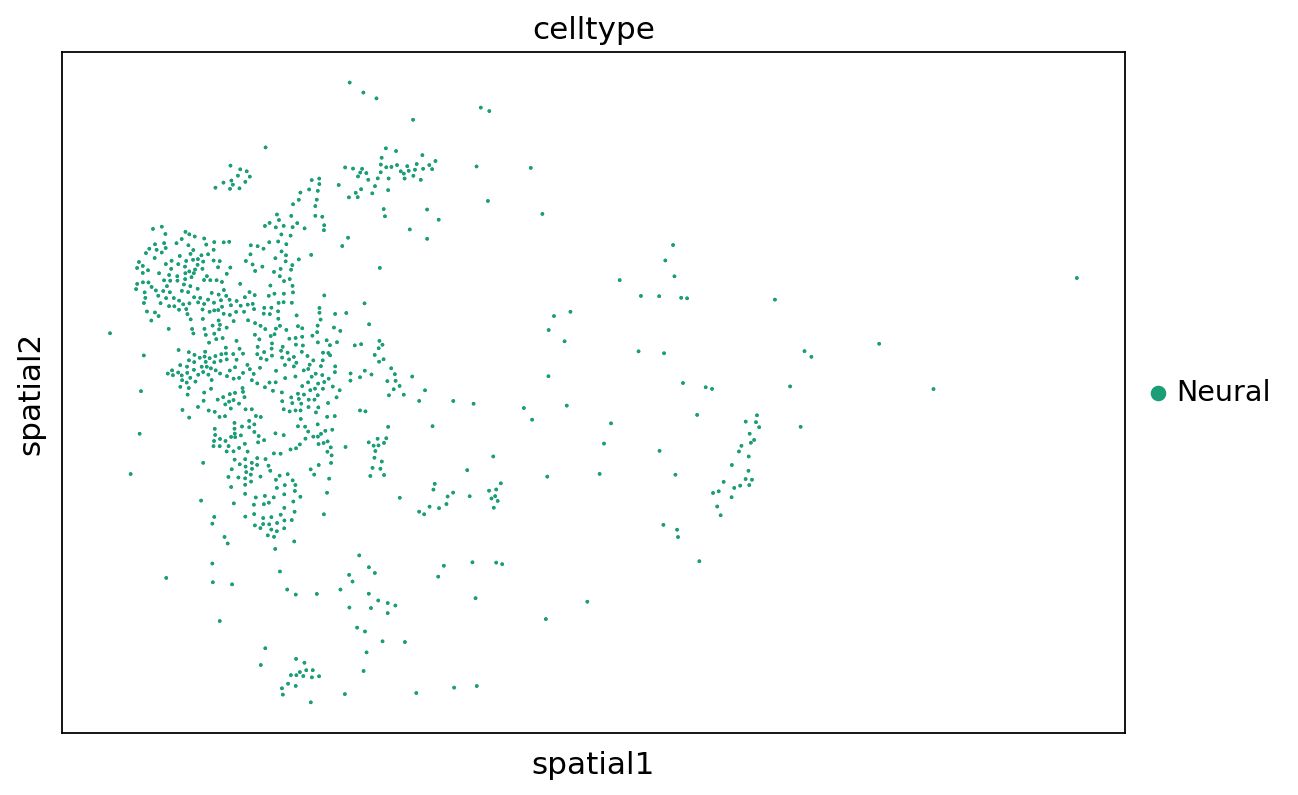

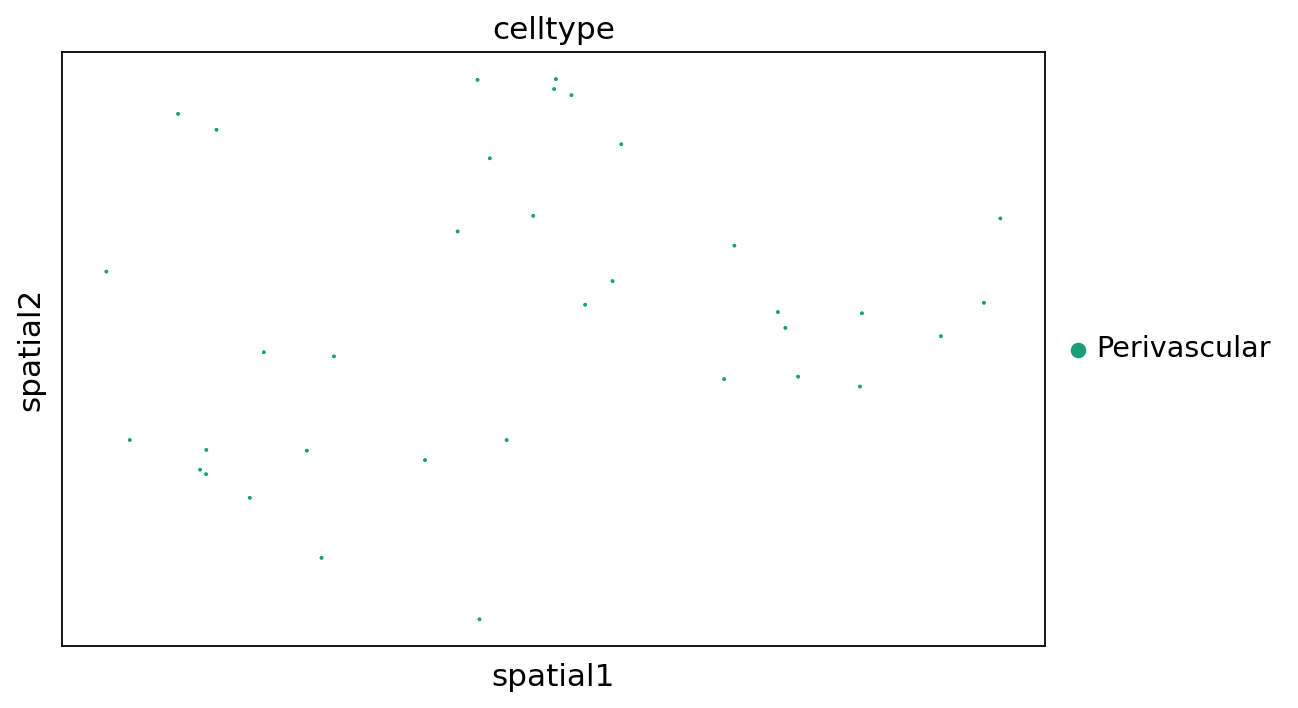

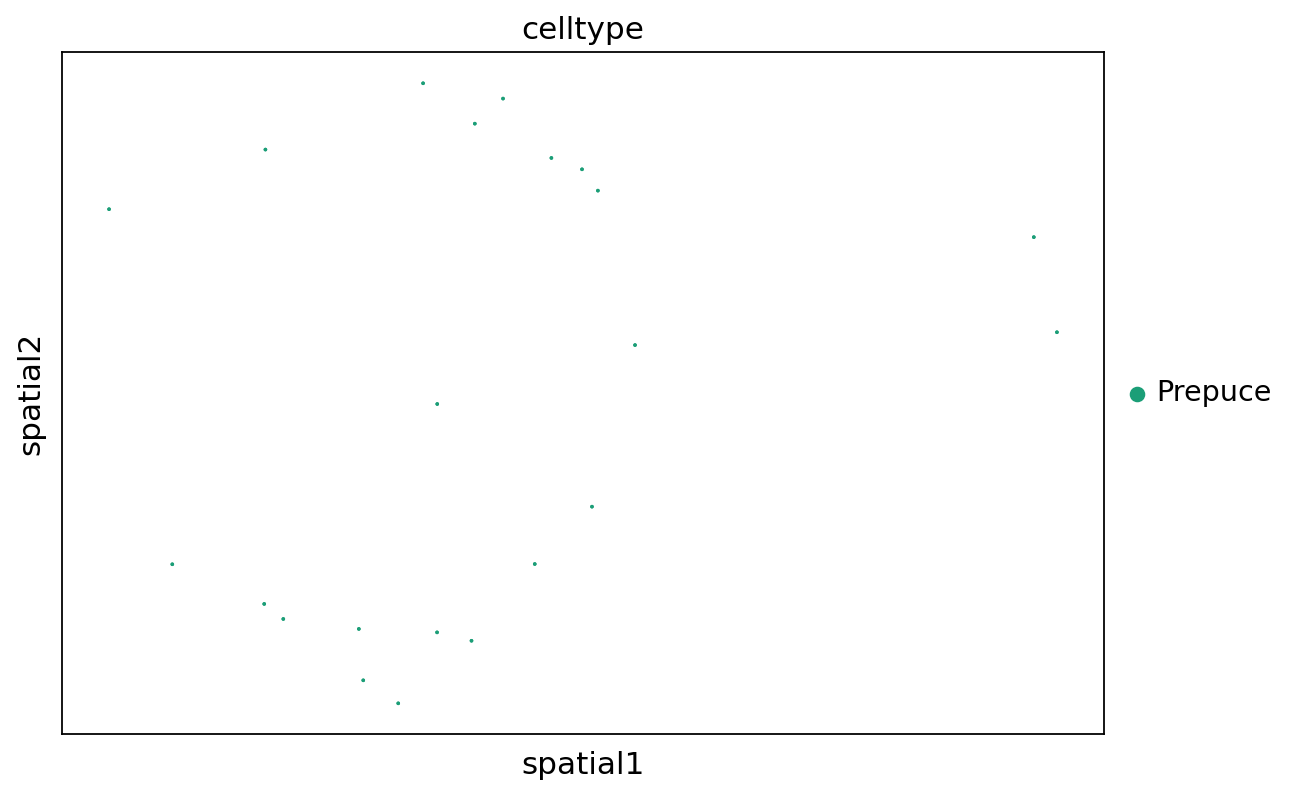

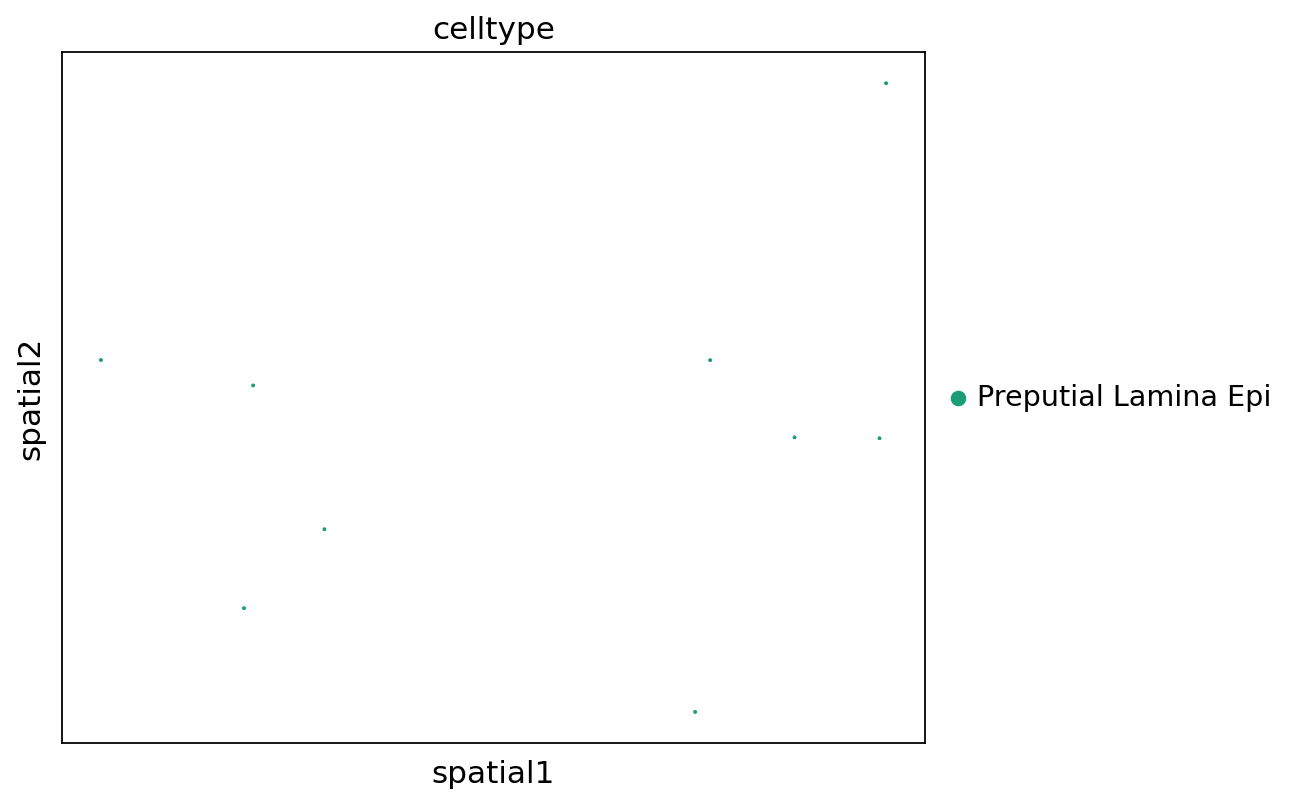

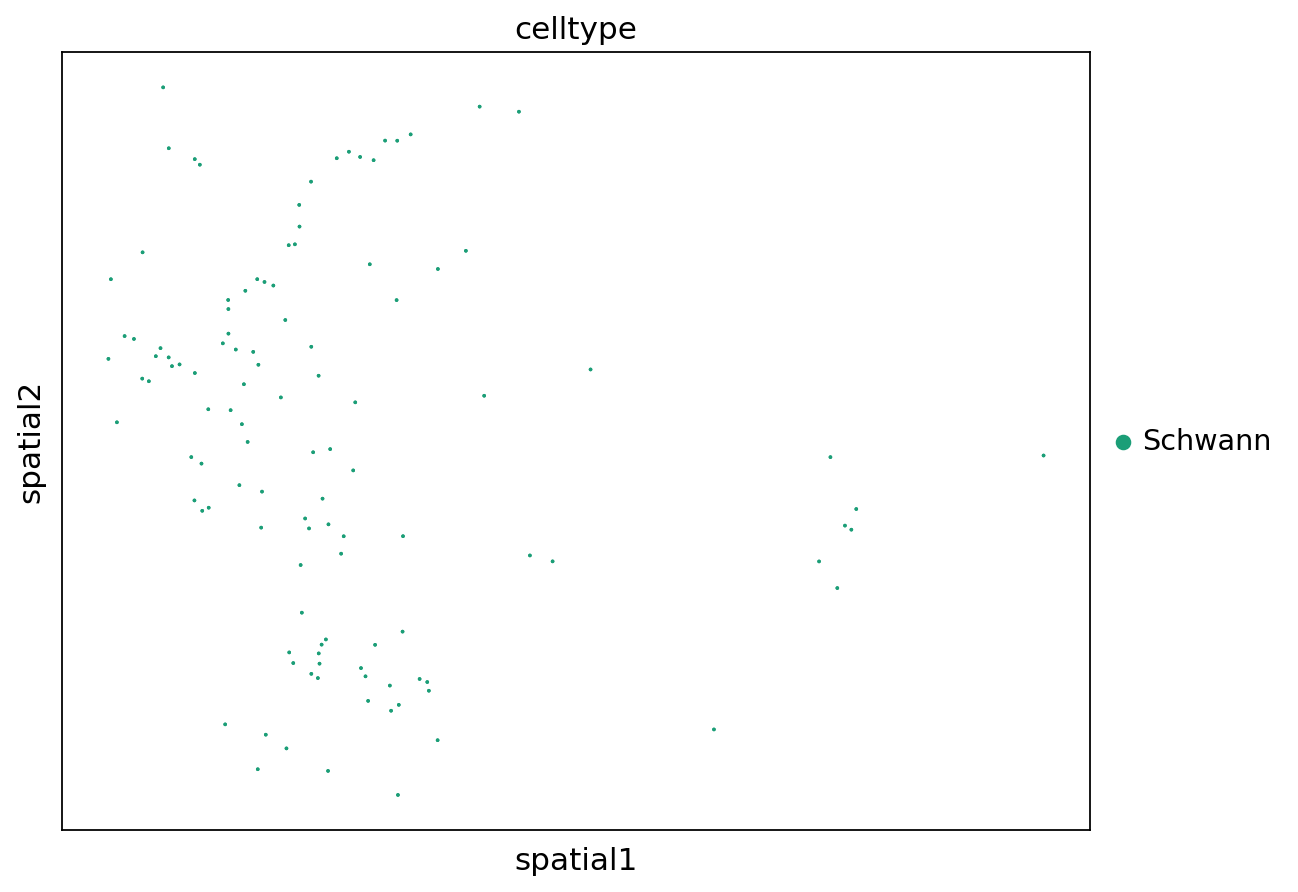

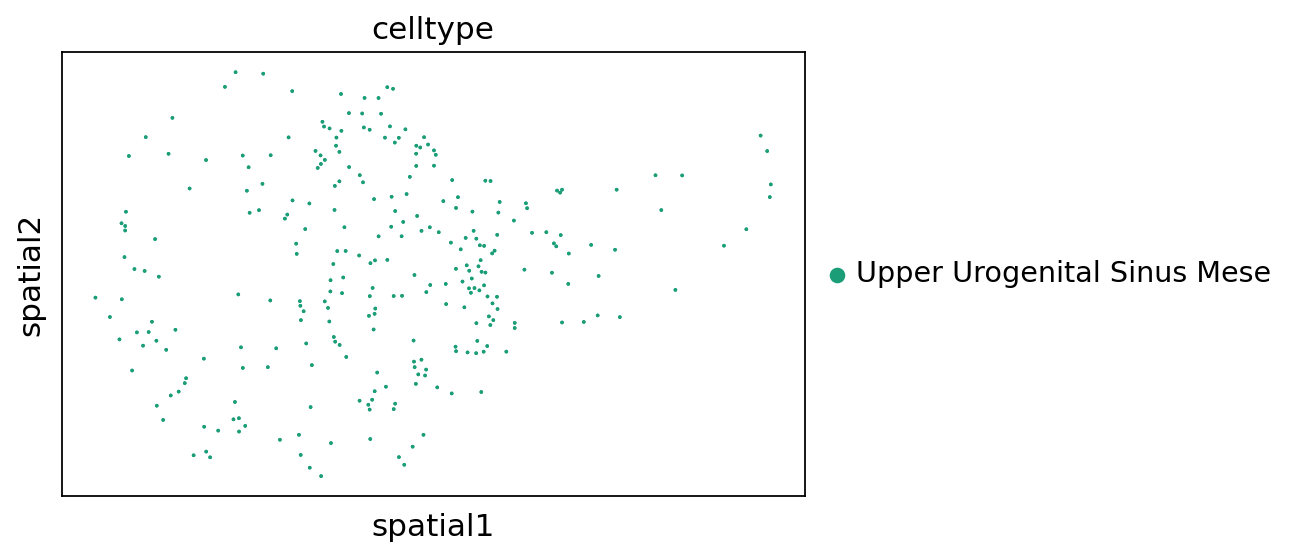

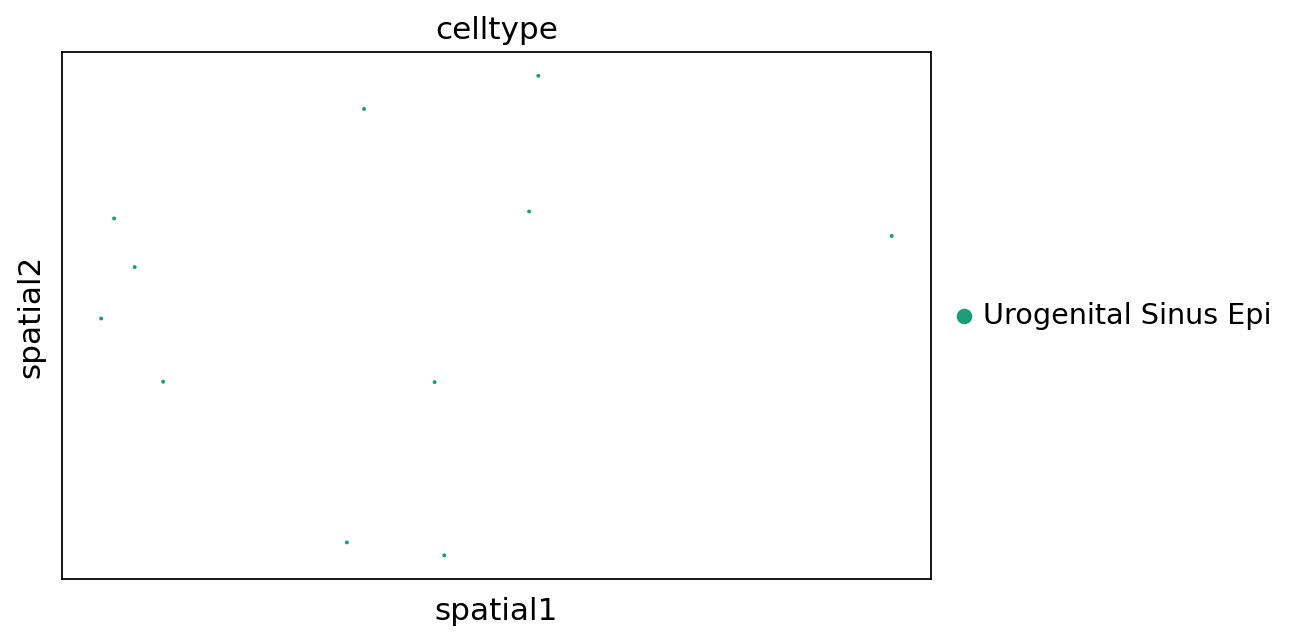

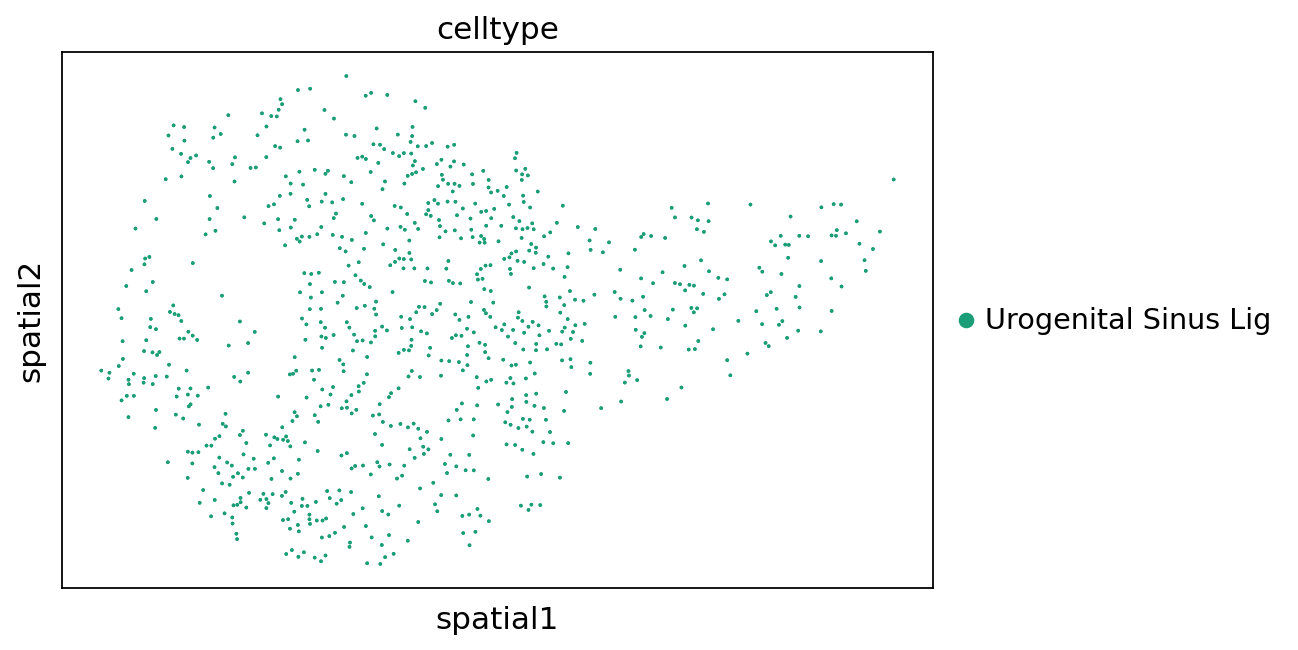

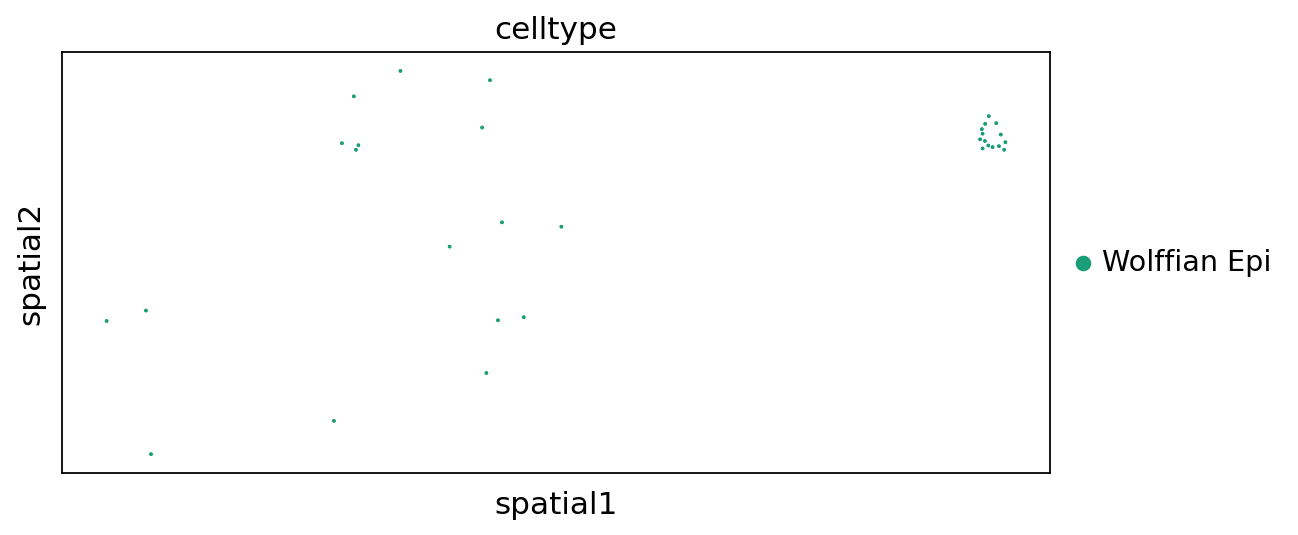

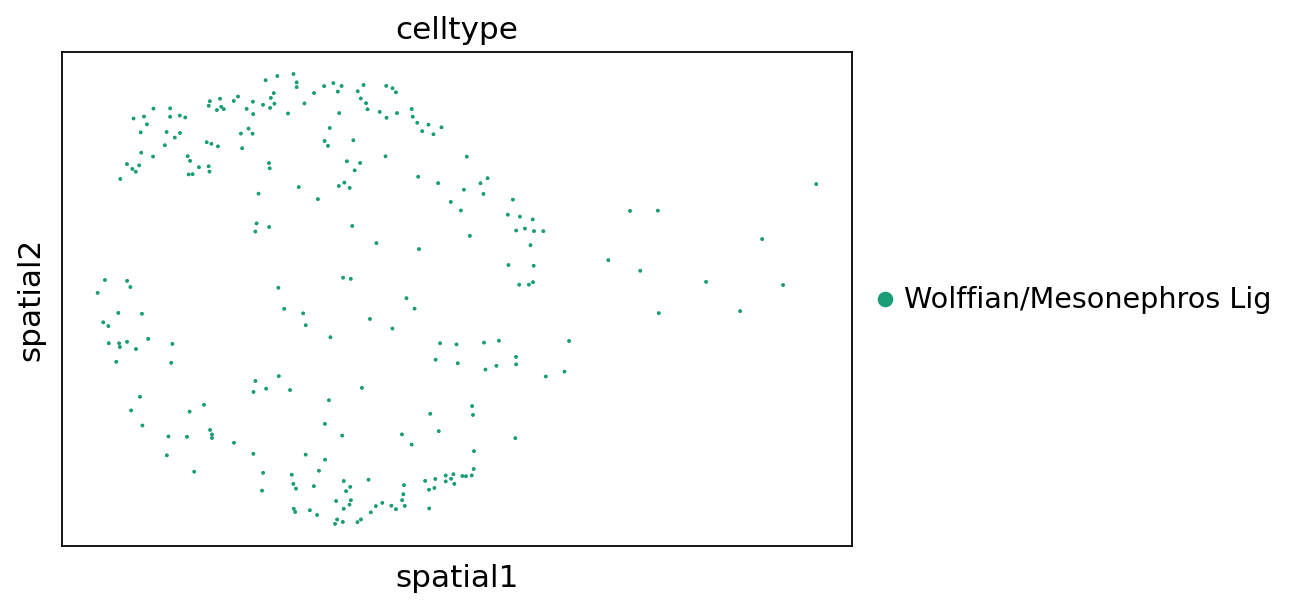

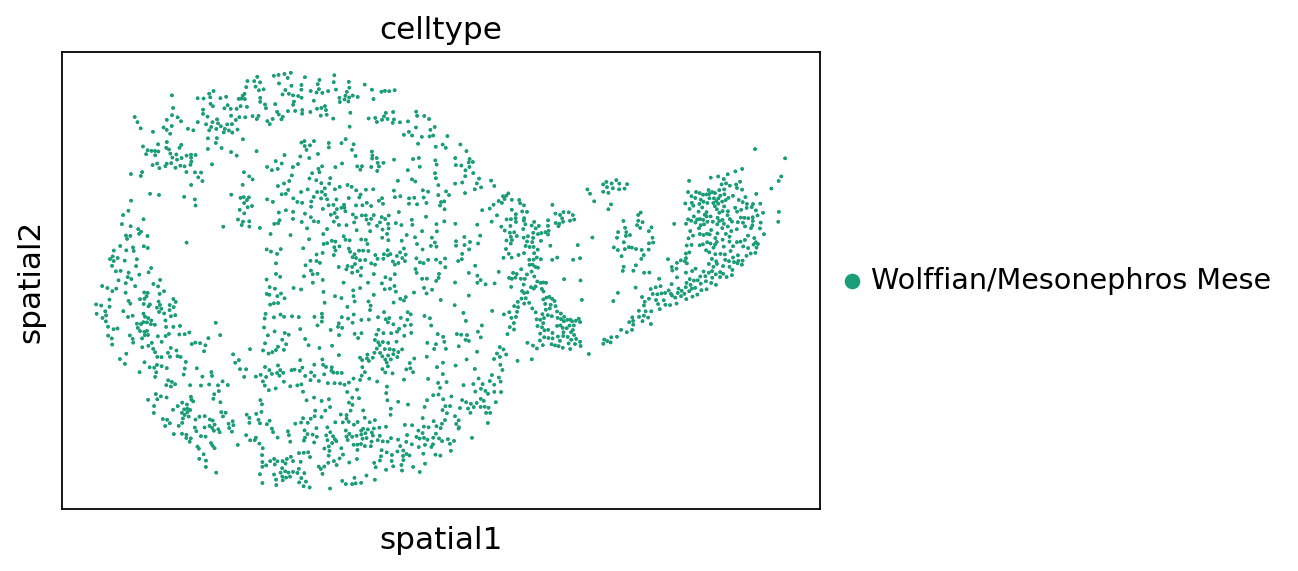

In [141]:
for i in np.unique(CM007.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM007,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [51]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Coelomic_Epithelium',  'MüllerianDuct_Epithelium', 
       'WolffianDuct_Epithelium', 'Kidney_UretericBud', 
                            'Kidney_Podocyte', 'AdrenalCortex'
                            
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM007.obs['ducts'] = CM007.obs.apply(new_column, axis=1)


In [52]:
CM007.obs['ducts'] = CM007.obs['ducts'].astype(str)
CM007.obs['ducts'] = CM007.obs['ducts'].astype('category')
CM007.obs['ducts'] = CM007.obs['ducts'].cat.reorder_categories([
    'Coelomic_Epithelium', 'MüllerianDuct_Epithelium', 'WolffianDuct_Epithelium', 
    'Kidney_Podocyte' ,  'Kidney_UretericBud', 
    'AdrenalCortex', 'nan'
])


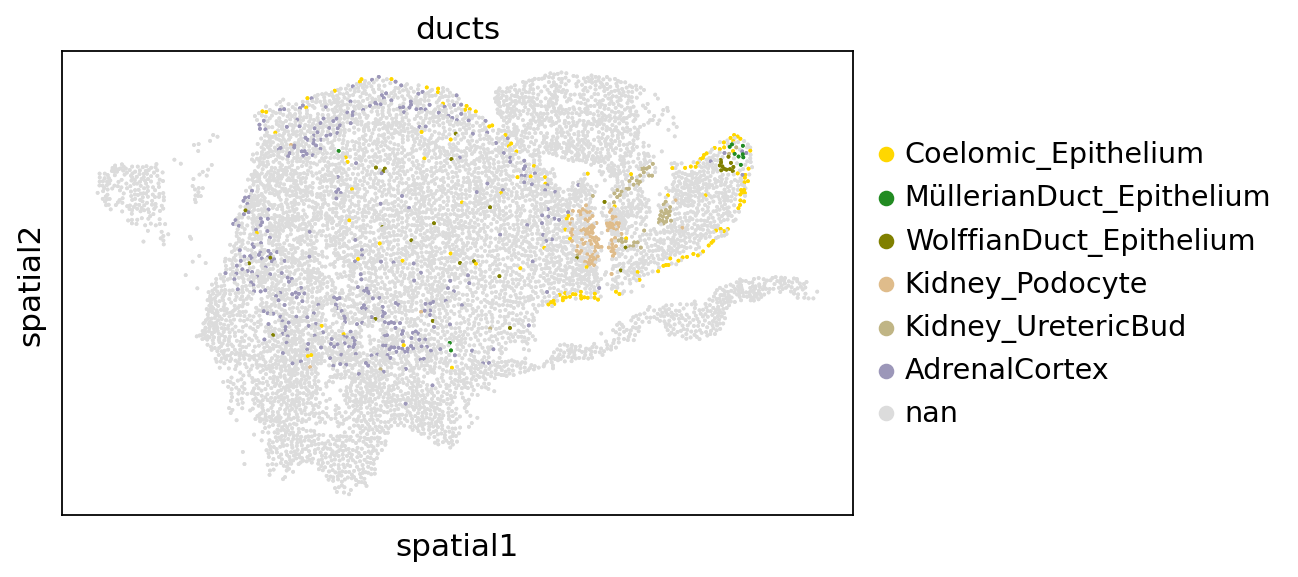

In [65]:
sq.pl.spatial_scatter(
    CM007,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=2,
    cmap = 'jet',
    figsize=(8,8), 
           # legend_loc = 'right margin',
           #                   palette= {'Coelomic_Epithelium' : 'gold',  'MüllerianDuct_Epithelium' : 'forestgreen', 
           #          'WolffianDuct_Epithelium' : 'olive',  
           #                             'Kidney_Podocyte' : '#dfbc8b', 
           #                             'Kidney_UretericBud' : '#c0b585', 'AdrenalCortex': '#9c97b9',
           #      'nan' : 'gainsboro'
           #                            },
    save = 'CM007_ducts_filtered.pdf'
)

In [61]:
CM007.obs['broad_anatomy'].value_counts()

Adrenal       4818
Unassigned    1689
Nephros        949
Gonad          690
Ducts          225
Background      20
Name: broad_anatomy, dtype: int64

In [64]:
sq.pl.spatial_scatter(
    CM007,
    spatial_key="spatial",
    color=['broad_anatomy'],
    shape=None,
    use_raw = False,
    size=2,
    cmap = 'jet',
    figsize=(8,8), 
           # legend_loc = 'right margin',
           #                   palette= {'Ducts' : '#80c6ab',   
           #                             'Adrenal' : '#dbcace', 
           #                             'Nephros' : '#dac9b6', 
           #                             'Gonad' : '#bdd1d6', 
           #      'Unassigned' : 'gainsboro', 'Background' : 'gainsboro',
           #                            },
    save = 'CM007_ducts_anatomy.pdf'
)